#Siniestros Viales

##Preprocesamiento de los datasets

In [ ]:
#descargar el csv para pruebas

# nombre_salida = "dataset_siniestros.csv"

# df_ausa.to_csv(nombre_salida, sep=";", index=False, encoding="utf-8-sig")

# print(f"✅ Dataset guardado como '{nombre_salida}' en el directorio actual.")

# from google.colab import files
# files.download(nombre_salida)


In [ ]:
#csv ya limpio usar a partir de despues de la subida a github
#ejecutar primero para tener los 3 dataset acomodados por fecha.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil import parser

# usa el link raw de github
siniestro2024 = "https://raw.githubusercontent.com/gabydomingo/datasets_viales/main/siniestros-2024.csv"
siniestro2023 = "https://raw.githubusercontent.com/gabydomingo/datasets_viales/main/siniestros-2023.csv"
siniestro2022 = "https://raw.githubusercontent.com/gabydomingo/datasets_viales/main/siniestros-2022.csv"


#funcion para leerlos y juntarlos, ya que el 2022 tiene algunos datos en otro orden o distinto encoding
def cargar_csv(path, year, encoding):
    df = pd.read_csv(path, sep=";", encoding=encoding)

    # Renombrar columnas problemáticas
    df = df.rename(columns={
        "ï»¿FECHA": "FECHA",
        "FECHA": "FECHA",
        "CONDICIONES METEOROLÃ\x93GICAS": "CONDICIONES METEOROLOGICAS",
        "CONDICIONES METEOROLÓGICAS": "CONDICIONES METEOROLOGICAS"
    })

    df["AÑO"] = year
    return df

# Cargar cada dataset con el encoding correcto
df_2022 = cargar_csv(siniestro2022, 2022, encoding="latin1")
df_2023 = cargar_csv(siniestro2023, 2023, encoding="utf-8-sig")
df_2024 = cargar_csv(siniestro2024, 2024, encoding="utf-8-sig")

# Unir todo
df_siniestros = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)


display(df_siniestros.head())

#esta anda bien no se toca!!

FECHA  HORA         AUTOPISTA BANDA y/o RAMAL    PK  \
0  2022-06-01    14     AU 25 DE MAYO      ASCENDENTE   400   
1  2022-06-02     7     AU 25 DE MAYO      ASCENDENTE  6400   
2  2022-06-02     7          AU ILLIA      ASCENDENTE  2500   
3  2022-06-02    17       AU FRONDIZI     DESCENDENTE  1500   
4  2022-06-02    17  AU PERITO MORENO     DESCENDENTE   500   

  CONDICIONES METEOROLOGICAS SUPERFICIE DE LA VIA  LESIONADOS  FALLECIDOS  \
0                      BUENO                 SECA           0           0   
1                      BUENO                 SECA           1           0   
2                      BUENO                 SECA           0           0   
3                      BUENO                 SECA           0           0   
4                      BUENO                 SECA           1           0   

                              TIPO DE SINIESTRO  MOTO  LVIANO  BUS  CAMION  \
0                             OBSTACULO NO FIJO     1       1    0       0   
1  SINIESTRO DE UN SOLO VEHICULO / SIN COLISION     1       0    0       0   
2                             OBSTACULO NO FIJO     0       0    0       1   
3              COLISION CON DOS O MAS VEHICULOS     0       3    0       0   
4              COLISION CON DOS O MAS VEHICULOS     1       0    0       1   

    AÑO  
0  2022  
1  2022  
2  2022  
3  2022  
4  2022

In [ ]:
#ejecutar 2do para reemplazar los ;-;.

df = df_siniestros  # alias mas corto y comodo

# Mascara de celdas cuyo valor EXACTO es '-' no toma las que tienen '-' en el nombre solo las ;-;
mask_dash = df.applymap(lambda x: str(x).strip() == '-')

# Identificar columnas objetivo
cols = df.columns.tolist()
pk_cols = [c for c in cols if 'pk' in c.lower()]
banda_cols = [c for c in cols if 'banda' in c.lower()]
ramal_cols = [c for c in cols if 'ramal' in c.lower()]

print("Columnas detectadas para PK:", pk_cols)
print("Columnas detectadas para BANDA:", banda_cols)
print("Columnas detectadas para RAMAL:", ramal_cols)
print()

replacements = {}  # llevar control de reemplazos por columna

# --- 1) PK: convertir a num, calcular media (fallback mediana) y reemplazar '-' por la media ---
for c in pk_cols:
    # Contar '-' en la columna (deberia haber 104 en principio)
    mask_c = mask_dash[c]
    count_dash = int(mask_c.sum())

    if count_dash == 0:
        replacements[c] = {"replaced": 0, "fill_value": None}
        continue

    # Crear columna numérica temporal propiciamente transformada
    # Primero convertimos valores '-' a NaN forzando coerción
    col_numeric = pd.to_numeric(df[c].replace('-', np.nan), errors='coerce')

    mean_val = col_numeric.mean(skipna=True)
    if pd.isna(mean_val):
        # intentar mediana
        median_val = col_numeric.median(skipna=True)
        fill_val = median_val if not pd.isna(median_val) else None
    else:
        fill_val = mean_val

    # Si no hay mean ni mediana, no rellenamos (dejamos NaN/pd.NA)
    if fill_val is None:
        # aplicar np.nan donde estaba '-'
        df.loc[mask_c, c] = pd.NA
        replacements[c] = {"replaced": count_dash, "fill_value": None, "note": "no mean/median available -> set pd.NA"}
    else:
        # Reemplazar en el df original (manteniendo tipo numérico)
        # Convertir toda la columna a num (coerce) y luego fillna con fill_val where mask was True
        df[c] = pd.to_numeric(df[c].replace('-', np.nan), errors='coerce')
        df.loc[mask_c, c] = fill_val
        replacements[c] = {"replaced": count_dash, "fill_value": float(fill_val)}

# --- 2) BANDA / RAMAL: reemplazar '-' por la moda (si existe) o por 'DESCONOCIDO' ---
for c in (banda_cols + ramal_cols):
    mask_c = mask_dash[c]
    count_dash = int(mask_c.sum())
    if count_dash == 0:
        replacements[c] = {"replaced": 0, "fill_value": None}
        continue

    # Consideramos como válidos los valores que no son '-' y no son nulos
    valid_series = df.loc[~mask_dash[c], c].replace('', np.nan).dropna().astype(str).str.strip()
    # calcular moda
    try:
        mode_val = valid_series.mode(dropna=True)
        if not mode_val.empty:
            fill_val = mode_val.iloc[0]
        else:
            fill_val = None
    except Exception:
        fill_val = None

    if fill_val is None or fill_val == '':
        fill_val = 'DESCONOCIDO'

    # Reemplazar sólo las celdas que eran exactamente '-'
    df.loc[mask_c, c] = fill_val
    replacements[c] = {"replaced": count_dash, "fill_value": fill_val}

# --- Resumen de lo hecho ---
print("Resumen de reemplazos realizados (columna: cantidad, valor usado):")
for col, info in replacements.items():
    print(f" - {col}: reemplazadas = {info.get('replaced', 0):,}, fill_value = {info.get('fill_value')}")

# --- Mostrar ejemplos antes/después ---
# Mostrar hasta 10 filas donde se aplicó algún reemplazo (antes y después)
rows_changed_mask = mask_dash.any(axis=1)
sample_rows_idx = df.index[rows_changed_mask].tolist()[:10]

if sample_rows_idx:
    print(f"\nMostrando hasta 10 filas donde había '-' (filas ejemplo): {len(sample_rows_idx)} encontradas (muestro primeras {len(sample_rows_idx)})\n")
    display(df.loc[sample_rows_idx])
else:
    print("\nNo se encontraron filas con '-' en las columnas objetivo.")

# Actualizar el df_siniestros original por seguridad (si querés mantener el cambio)
df_siniestros = df

# FIN del bloque


Columnas detectadas para PK: ['PK']
Columnas detectadas para BANDA: ['BANDA y/o RAMAL']
Columnas detectadas para RAMAL: ['BANDA y/o RAMAL']

Resumen de reemplazos realizados (columna: cantidad, valor usado):
 - PK: reemplazadas = 104, fill_value = 4254.418498168498
 - BANDA y/o RAMAL: reemplazadas = 5, fill_value = DESCENDENTE

Mostrando hasta 10 filas donde había '-' (filas ejemplo): 10 encontradas (muestro primeras 10)



/tmp/ipython-input-247032775.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask_dash = df.applymap(lambda x: str(x).strip() == '-')


FECHA  HORA              AUTOPISTA      BANDA y/o RAMAL  \
14   2022-06-04    16     TRANSICION RAMAL 1      RAMAL DE EGRESO   
114  2022-08-21     0     TRANSICION RAMAL 2      RAMAL DE ENLACE   
125  2022-08-25     1         PASEO DEL BAJO  DIST. SUR - RAMAL 1   
143  2022-08-31    15       DIST. 9 DE JULIO          RAMAL 2 BIS   
158  2022-09-07    17  PTE. SCALABRINI ORTIZ          DESCENDENTE   
168  2022-09-10    14     TRANSICION RAMAL 3      RAMAL DE ENLACE   
204  2022-09-19    17     TRANSICION RAMAL 3      RAMAL DE ENLACE   
215  2022-09-22    17       DIST. 9 DE JULIO          RAMAL 2 BIS   
228  2022-09-27     9          AU 25 DE MAYO          DESCENDENTE   
229  2022-09-27     9       DIST. DELLEPIANE             RAMAL 11   

              PK CONDICIONES METEOROLOGICAS SUPERFICIE DE LA VIA  LESIONADOS  \
14   4254.418498                      BUENO                 SECA           0   
114  4254.418498                      BUENO                 SECA           0   
125  4254.418498                      BUENO                 SECA           0   
143  4254.418498                      BUENO                 SECA           0   
158  4254.418498                      BUENO                 SECA           1   
168  4254.418498                      BUENO                 SECA           1   
204  4254.418498                      BUENO                 SECA           0   
215  4254.418498                      BUENO                 SECA           1   
228  4254.418498                      BUENO                 SECA           0   
229  4254.418498                      BUENO                 SECA           0   

     FALLECIDOS                 TIPO DE SINIESTRO  MOTO  LVIANO  BUS  CAMION  \
14            0       COLISION CON OBSTACULO FIJO     0       1    0       0   
114           0       COLISION CON OBSTACULO FIJO     0       1    0       0   
125           0       COLISION CON OBSTACULO FIJO     0       1    0       0   
143           0       COLISION CON OBSTACULO FIJO     1       0    0       0   
158           0  COLISION CON DOS O MAS VEHICULOS     1       1    0       0   
168           0       COLISION CON OBSTACULO FIJO     1       0    0       0   
204           0  COLISION CON DOS O MAS VEHICULOS     0       1    0       1   
215           0       COLISION CON OBSTACULO FIJO     1       0    0       0   
228           0  COLISION CON DOS O MAS VEHICULOS     0       1    0       0   
229           0  COLISION CON DOS O MAS VEHICULOS     0       2    0       0   

      AÑO  
14   2022  
114  2022  
125  2022  
143  2022  
158  2022  
168  2022  
204  2022  
215  2022  
228  2022  
229  2022

In [ ]:
#ejecutar 3ero para formatear y desglosar fechas, dias y horarios
df = df_siniestros  # alias

# 1. Combinar FECHA y HORA en una sola cadena de texto
df['FECHA_HORA_RAW'] = df['FECHA'].astype(str) + ' ' + df['HORA'].astype(str)

# 2. Definir la función de parseo condicional y estricto
def parse_date_strict_conditional(row):
    date_time_str = row['FECHA_HORA_RAW']
    year = row['AÑO']

    # -----------------------------------------------------
    # Caso 1: AÑO 2022 -> Formato YYYY-MM-DD (Mes/Día Correcto)
    # -----------------------------------------------------
    if year == 2022:
        # Intentar el formato AAAA-MM-DD H (con hora de 1 o 2 dígitos sin relleno)
        try:
            # Usar strptime con manejo de H (hora sin relleno)
            dt = datetime.strptime(date_time_str, '%Y-%m-%d %H')
            return pd.to_datetime(dt)
        except ValueError:
            # Fallback (por si hay minutos/segundos u otro error)
            return pd.to_datetime(date_time_str, errors='coerce', dayfirst=False, infer_datetime_format=True)

    # -----------------------------------------------------
    # Caso 2: AÑO 2023/2024 -> Formato D/M/YYYY (Día/Mes Correcto)
    # -----------------------------------------------------
    elif year in [2023, 2024]:
        # Intentar el formato D/M/YYYY H (con día, mes y hora de 1 o 2 dígitos sin relleno)
        try:
            # Usar strptime con manejo de d, m, H (día/mes/hora sin relleno)
            dt = datetime.strptime(date_time_str, '%d/%m/%Y %H')
            return pd.to_datetime(dt)
        except ValueError:
             # Fallback (por si hay formato diferente con barras)
            return pd.to_datetime(date_time_str, errors='coerce', dayfirst=True, infer_datetime_format=True)

    return pd.NaT


# 3. Aplicar el parseo corregido a la columna combinada
if "FECHA_orig" not in df.columns:
    df["FECHA_orig"] = df["FECHA"]

# Aplicamos la función condicional en lugar de un .apply simple
df["FECHA_parsed"] = df.apply(parse_date_strict_conditional, axis=1)

# 4. Extraer componentes y el día de la semana
df["FECHA_AÑO"] = df["FECHA_parsed"].dt.year.astype('Int64')
df["FECHA_MES"] = df["FECHA_parsed"].dt.month.astype('Int64')
df["FECHA_DIA"] = df["FECHA_parsed"].dt.day.astype('Int64')
df["FECHA_HORA"] = df["FECHA_parsed"].dt.hour.astype('Int64')

# Mapeo de días de la semana a español
df["FECHA_DIASEMANA"] = df["FECHA_parsed"].dt.day_name().map({
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado',
    'Sunday': 'Domingo'
})

# 5. Diagnóstico final
n_invalid_dates = df["FECHA_parsed"].isna().sum()
n_total = len(df)
print(f"Fechas inválidas/no parseables después de la corrección: {n_invalid_dates:,} de {n_total:,} filas ({100*n_invalid_dates/n_total:.2f}%)")

if n_invalid_dates == 0:
    print("\n¡Todas las 2,288 fechas han sido parseadas correctamente!")
else:
    print("\nAVISO: Aún quedan fechas sin parsear. Revisar los siguientes ejemplos:")
    # Solo mostramos el head de los NaT
    display(df.loc[df["FECHA_parsed"].isna(), ["FECHA_orig", "HORA", "AÑO", "FECHA_HORA_RAW"]].head(10))

# 6. Mostrar ejemplos corregidos (2022 y 2023)
print("\nVerificación de fechas corregidas (2022 y 2023):")
print("\nAño 2022 (Junio) y la hora ya está correcta:")
display(df.loc[df['AÑO']==2022, ["FECHA_orig", "HORA", "AÑO", "FECHA_parsed", "FECHA_MES", "FECHA_HORA", "FECHA_DIASEMANA"]].head(3))
print("\nAño 2023 (Enero) y la hora ya está correcta:")
display(df.loc[df['AÑO']==2023, ["FECHA_orig", "HORA", "AÑO", "FECHA_parsed", "FECHA_MES", "FECHA_HORA", "FECHA_DIASEMANA"]].head(3))

# Actualizar el original
df_siniestros = df

Fechas inválidas/no parseables después de la corrección: 0 de 2,288 filas (0.00%)

¡Todas las 2,288 fechas han sido parseadas correctamente!

Verificación de fechas corregidas (2022 y 2023):

Año 2022 (Junio) y la hora ya está correcta:


FECHA_orig  HORA   AÑO        FECHA_parsed  FECHA_MES  FECHA_HORA  \
0  2022-06-01    14  2022 2022-06-01 14:00:00          6          14   
1  2022-06-02     7  2022 2022-06-02 07:00:00          6           7   
2  2022-06-02     7  2022 2022-06-02 07:00:00          6           7   

  FECHA_DIASEMANA  
0       Miércoles  
1          Jueves  
2          Jueves


Año 2023 (Enero) y la hora ya está correcta:


FECHA_orig  HORA   AÑO        FECHA_parsed  FECHA_MES  FECHA_HORA  \
477   2/1/2023     8  2023 2023-01-02 08:00:00          1           8   
478   3/1/2023    14  2023 2023-01-03 14:00:00          1          14   
479   3/1/2023    14  2023 2023-01-03 14:00:00          1          14   

    FECHA_DIASEMANA  
477           Lunes  
478          Martes  
479          Martes

In [ ]:
#ejecutar 4to para eliminar columans redundantes post transformacion.

df = df_siniestros  # Usamos el alias

# Lista de columnas a eliminar: las originales y las auxiliares de parseo
columns_to_drop = [
    'FECHA',          # Fecha original (texto)
    'HORA',           # Hora original (entero)
    'AÑO',            # Columna 'AÑO' original (si fue usada como tal)
    'FECHA_HORA_RAW', # Cadena combinada de Fecha y Hora
    'FECHA_orig',     # Copia de la columna 'FECHA'
    'FECHA_parsed'    # Columna de datetime ya extraída
]

# Eliminar las columnas. Usamos errors='ignore' por si alguna columna ya fue eliminada en otro paso.
df_siniestros = df.drop(columns=columns_to_drop, errors='ignore')

print("\n--- Bloque de Eliminación de Columnas ---")
print("Columnas eliminadas: ", [c for c in columns_to_drop if c in df.columns])
print(f"Número de columnas restantes: {df_siniestros.shape[1]}")

print("\nPrimeras 5 filas del DataFrame final (solo con columnas de análisis):")
display(df_siniestros.head())

df = df_siniestros # Actualizar el alias


--- Bloque de Eliminación de Columnas ---
Columnas eliminadas:  ['FECHA', 'HORA', 'AÑO', 'FECHA_HORA_RAW', 'FECHA_orig', 'FECHA_parsed']
Número de columnas restantes: 17

Primeras 5 filas del DataFrame final (solo con columnas de análisis):


AUTOPISTA BANDA y/o RAMAL      PK CONDICIONES METEOROLOGICAS  \
0     AU 25 DE MAYO      ASCENDENTE   400.0                      BUENO   
1     AU 25 DE MAYO      ASCENDENTE  6400.0                      BUENO   
2          AU ILLIA      ASCENDENTE  2500.0                      BUENO   
3       AU FRONDIZI     DESCENDENTE  1500.0                      BUENO   
4  AU PERITO MORENO     DESCENDENTE   500.0                      BUENO   

  SUPERFICIE DE LA VIA  LESIONADOS  FALLECIDOS  \
0                 SECA           0           0   
1                 SECA           1           0   
2                 SECA           0           0   
3                 SECA           0           0   
4                 SECA           1           0   

                              TIPO DE SINIESTRO  MOTO  LVIANO  BUS  CAMION  \
0                             OBSTACULO NO FIJO     1       1    0       0   
1  SINIESTRO DE UN SOLO VEHICULO / SIN COLISION     1       0    0       0   
2                             OBSTACULO NO FIJO     0       0    0       1   
3              COLISION CON DOS O MAS VEHICULOS     0       3    0       0   
4              COLISION CON DOS O MAS VEHICULOS     1       0    0       1   

   FECHA_AÑO  FECHA_MES  FECHA_DIA  FECHA_HORA FECHA_DIASEMANA  
0       2022          6          1          14       Miércoles  
1       2022          6          2           7          Jueves  
2       2022          6          2           7          Jueves  
3       2022          6          2          17          Jueves  
4       2022          6          2          17          Jueves

In [ ]:
#5to elimina las filas de los unicos dos datos que tenian <SD> como parametro.

df = df_siniestros  # Usamos el alias

# 1. Crear una máscara booleana: chequea si algún valor en la fila (convertido a string) es igual a '<SD>'
# Usamos .astype(str) para asegurar que la comparación funcione en todas las columnas, incluso las numéricas.
mask_sd = (df.astype(str) == '<SD>').any(axis=1)
n_rows_to_drop = mask_sd.sum()

print("\n--- Bloque de Eliminación de Filas con <SD> ---")
print(f"Filas detectadas con el valor '<SD>': {n_rows_to_drop}")

if n_rows_to_drop > 0:
    # 2. Eliminar las filas que cumplen con la máscara (usando el inverso ~)
    df_siniestros = df.loc[~mask_sd].copy()
    print("Eliminación completada.")
else:
    print("No se encontraron filas con el valor '<SD>'. No se eliminó ninguna fila.")

# 3. Diagnóstico final
print(f"Filas antes de la eliminación: {df.shape[0]}")
print(f"Filas después de la eliminación: {df_siniestros.shape[0]}")

# Actualizar el alias
df = df_siniestros


--- Bloque de Eliminación de Filas con <SD> ---
Filas detectadas con el valor '<SD>': 2
Eliminación completada.
Filas antes de la eliminación: 2288
Filas después de la eliminación: 2286


In [ ]:
# limita el decimal del pk a dos numeros por que la media me da un float larguito
df['PK'] = df['PK'].round(2)

print("✅ Redondeo de la columna PK completado (a 2 decimales).")

✅ Redondeo de la columna PK completado (a 2 decimales).


##Comienzo del código

---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://raw.githubusercontent.com/gabydomingo/vialidad/main/siniestros.csv"
df_ausa = pd.read_csv(url, sep=";")

# Apply the cleaning steps from previous successful cells to df_ausa
# 1. Eliminate rows from June 2022
df_ausa = df_ausa[~((df_ausa['FECHA_AÑO'] == 2022) & (df_ausa['FECHA_MES'] == 6))].copy()

# 2. Clean and rename columns
nuevos_nombres = {
    'FECHA_DIASEMANA': 'DIASEMANA',
    'FECHA_HORA': 'HORA',
    'FECHA_DIA': 'DIA',
    'FECHA_MES': 'MES',
    'FECHA_AÑO': 'AÑO',
    'LVIANO': 'LIVIANO'
}
df_ausa.rename(columns=nuevos_nombres, inplace=True)
df_ausa.columns = df_ausa.columns.str.replace(' ', '_').str.replace('y/o', 'o')

# 3. Eliminate rows with '<SD>' (although previous output suggests none remain, good practice)
mask_sd = (df_ausa.astype(str) == '<SD>').any(axis=1)
df_ausa = df_ausa.loc[~mask_sd].copy()

# 4. Round the 'PK' column
df_ausa['PK'] = df_ausa['PK'].round(2)

In [ ]:
#ejecutar este no hace falta lo demas total ya toma lo de github que ya esta acomodado
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://raw.githubusercontent.com/gabydomingo/vialidad/main/siniestros.csv"
df_ausa = pd.read_csv(url, sep=";")

display(df_ausa.head())


AUTOPISTA BANDA y/o RAMAL      PK CONDICIONES METEOROLOGICAS  \
0     AU 25 DE MAYO      ASCENDENTE   400.0                      BUENO   
1     AU 25 DE MAYO      ASCENDENTE  6400.0                      BUENO   
2          AU ILLIA      ASCENDENTE  2500.0                      BUENO   
3       AU FRONDIZI     DESCENDENTE  1500.0                      BUENO   
4  AU PERITO MORENO     DESCENDENTE   500.0                      BUENO   

  SUPERFICIE DE LA VIA  LESIONADOS  FALLECIDOS  \
0                 SECA           0           0   
1                 SECA           1           0   
2                 SECA           0           0   
3                 SECA           0           0   
4                 SECA           1           0   

                              TIPO DE SINIESTRO  MOTO  LVIANO  BUS  CAMION  \
0                             OBSTACULO NO FIJO     1       1    0       0   
1  SINIESTRO DE UN SOLO VEHICULO / SIN COLISION     1       0    0       0   
2                             OBSTACULO NO FIJO     0       0    0       1   
3              COLISION CON DOS O MAS VEHICULOS     0       3    0       0   
4              COLISION CON DOS O MAS VEHICULOS     1       0    0       1   

   FECHA_AÑO  FECHA_MES  FECHA_DIA  FECHA_HORA FECHA_DIASEMANA  
0       2022          6          1          14       Miércoles  
1       2022          6          2           7          Jueves  
2       2022          6          2           7          Jueves  
3       2022          6          2          17          Jueves  
4       2022          6          2          17          Jueves

In [ ]:
# --- 1. Eliminar filas de Junio de 2022 ---
# Usamos una condición booleana. El operador ~ (virgulilla) invierte la selección,
# es decir, nos quedamos con todo lo que NO sea Junio de 2022.
df_filtrado = df_ausa[~((df_ausa['FECHA_AÑO'] == 2022) & (df_ausa['FECHA_MES'] == 6))]

# --- 2. Limpiar y renombrar columnas ---
# Creamos un diccionario para los renombres específicos
nuevos_nombres = {
    'FECHA_DIASEMANA': 'DIASEMANA',
    'FECHA_HORA': 'HORA',
    'FECHA_DIA': 'DIA',
    'FECHA_MES': 'MES',
    'FECHA_AÑO': 'AÑO',
    'LVIANO': 'LIVIANO'
}
df_filtrado.rename(columns=nuevos_nombres, inplace=True)

# Reemplazamos espacios y caracteres especiales en todos los nombres de columna
df_filtrado.columns = df_filtrado.columns.str.replace(' ', '_').str.replace('y/o', 'o')

# --- 3. Verificar los cambios ---
print("--- Información del DataFrame después de la limpieza ---")
df_filtrado.info()

print("\n--- Primeras filas del DataFrame modificado ---")
print(df_filtrado.head())

df_ausa = df_filtrado

--- Información del DataFrame después de la limpieza ---
<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 70 to 2285
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AUTOPISTA                   2216 non-null   object 
 1   BANDA_o_RAMAL               2216 non-null   object 
 2   PK                          2216 non-null   float64
 3   CONDICIONES_METEOROLOGICAS  2216 non-null   object 
 4   SUPERFICIE_DE_LA_VIA        2216 non-null   object 
 5   LESIONADOS                  2216 non-null   int64  
 6   FALLECIDOS                  2216 non-null   int64  
 7   TIPO_DE_SINIESTRO           2216 non-null   object 
 8   MOTO                        2216 non-null   int64  
 9   LIVIANO                     2216 non-null   int64  
 10  BUS                         2216 non-null   int64  
 11  CAMION                      2216 non-null   int64  
 12  AÑO                         2216 non-

/tmp/ipython-input-3948227795.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.rename(columns=nuevos_nombres, inplace=True)


### cantidad de siniestros x autopista


/tmp/ipython-input-1486849998.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=siniestros_por_autopista.index, y=siniestros_por_autopista.values, palette='viridis')


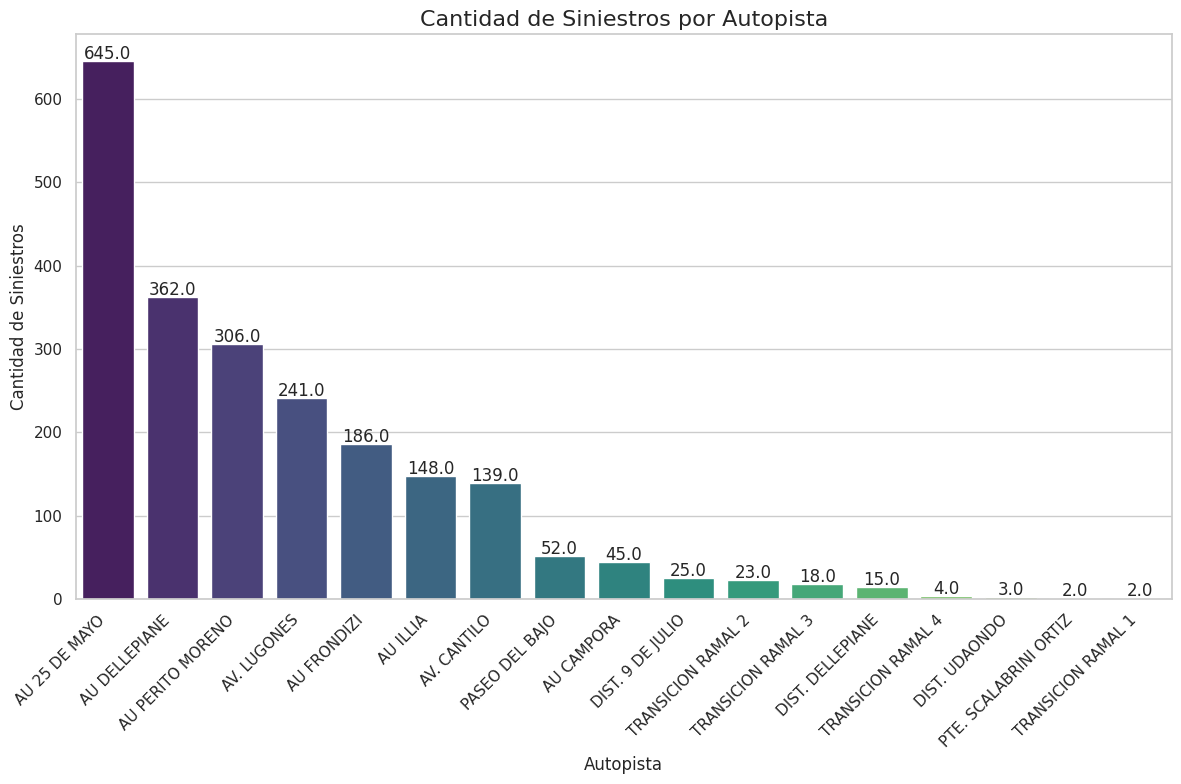

In [ ]:
df = df_ausa.copy()

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Contar los siniestros por autopista
siniestros_por_autopista = df['AUTOPISTA'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=siniestros_por_autopista.index, y=siniestros_por_autopista.values, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Cantidad de Siniestros por Autopista', fontsize=16)
plt.xlabel('Autopista', fontsize=12)
plt.ylabel('Cantidad de Siniestros', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para que no se superpongan
plt.tight_layout() # Ajusta el gráfico para que todo encaje bien

# Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Mostrar el gráfico
plt.show()

### Siniestro hora y dia + ramal


In [ ]:
# Crear una tabla de contingencia múltiple
# Contamos cuántos siniestros hay para cada combinación de día, hora y banda/ramal
siniestros_por_direccion_hora_dia = df_filtrado.groupby(['DIASEMANA', 'HORA', 'BANDA_o_RAMAL']).size().reset_index(name='CANTIDAD')

# Reordenar los días de la semana
dias_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
# Convertimos DIASEMANA a tipo categórico con el orden correcto
siniestros_por_direccion_hora_dia['DIASEMANA'] = pd.Categorical(siniestros_por_direccion_hora_dia['DIASEMANA'], categories=dias_ordenados, ordered=True)

# Filtramos para las direcciones principales (ASCENDENTE y DESCENDENTE)
# (Puedes ajustar esto si hay otras direcciones importantes en tu dataset)
df_ascendente = siniestros_por_direccion_hora_dia[siniestros_por_direccion_hora_dia['BANDA_o_RAMAL'] == 'ASCENDENTE']
df_descendente = siniestros_por_direccion_hora_dia[siniestros_por_direccion_hora_dia['BANDA_o_RAMAL'] == 'DESCENDENTE']

# Pivotamos las tablas para el formato del heatmap
heatmap_ascendente = df_ascendente.pivot_table(index='DIASEMANA', columns='HORA', values='CANTIDAD', fill_value=0)
heatmap_descendente = df_descendente.pivot_table(index='DIASEMANA', columns='HORA', values='CANTIDAD', fill_value=0)

# Aseguramos que todas las horas (0-23) estén presentes como columnas
horas_completas = range(24)
heatmap_ascendente = heatmap_ascendente.reindex(columns=horas_completas, fill_value=0)
heatmap_descendente = heatmap_descendente.reindex(columns=horas_completas, fill_value=0)

/tmp/ipython-input-2418544312.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_ascendente = df_ascendente.pivot_table(index='DIASEMANA', columns='HORA', values='CANTIDAD', fill_value=0)
/tmp/ipython-input-2418544312.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_descendente = df_descendente.pivot_table(index='DIASEMANA', columns='HORA', values='CANTIDAD', fill_value=0)


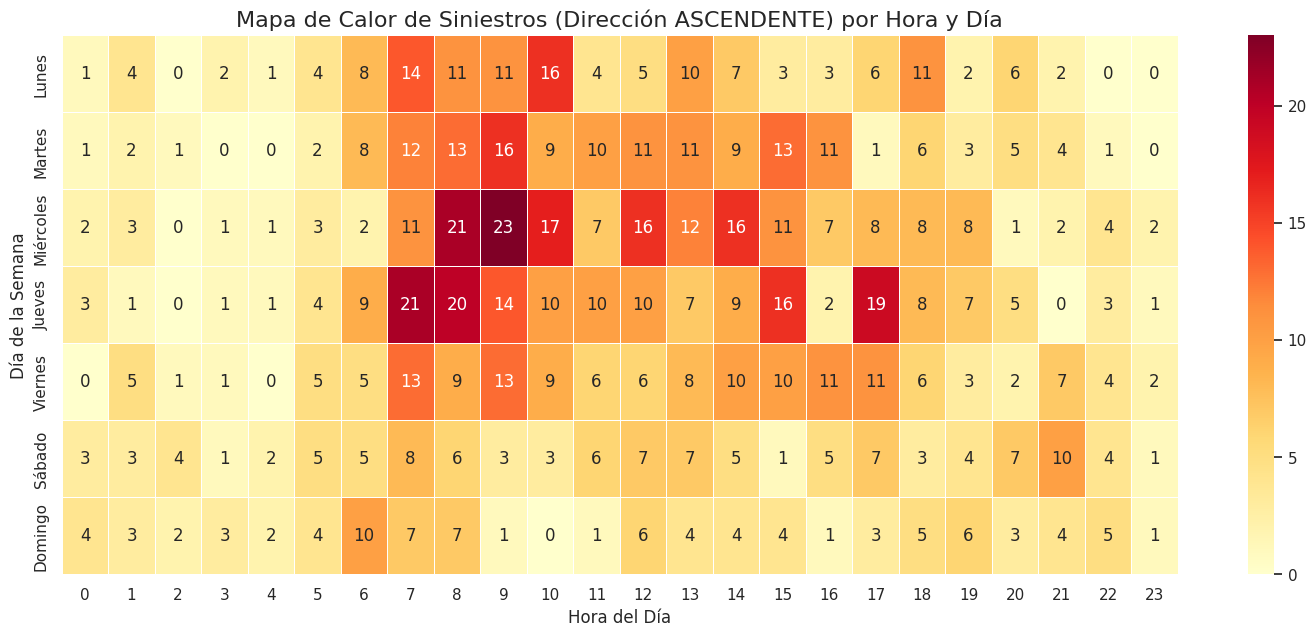

In [ ]:
# --- Mapa de Calor para Dirección ASCENDENTE ---
plt.figure(figsize=(18, 7))
sns.heatmap(heatmap_ascendente, cmap='YlOrRd', linewidths=.5, annot=True, fmt='.0f')
plt.title('Mapa de Calor de Siniestros (Dirección ASCENDENTE) por Hora y Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Día de la Semana', fontsize=12)
plt.show()

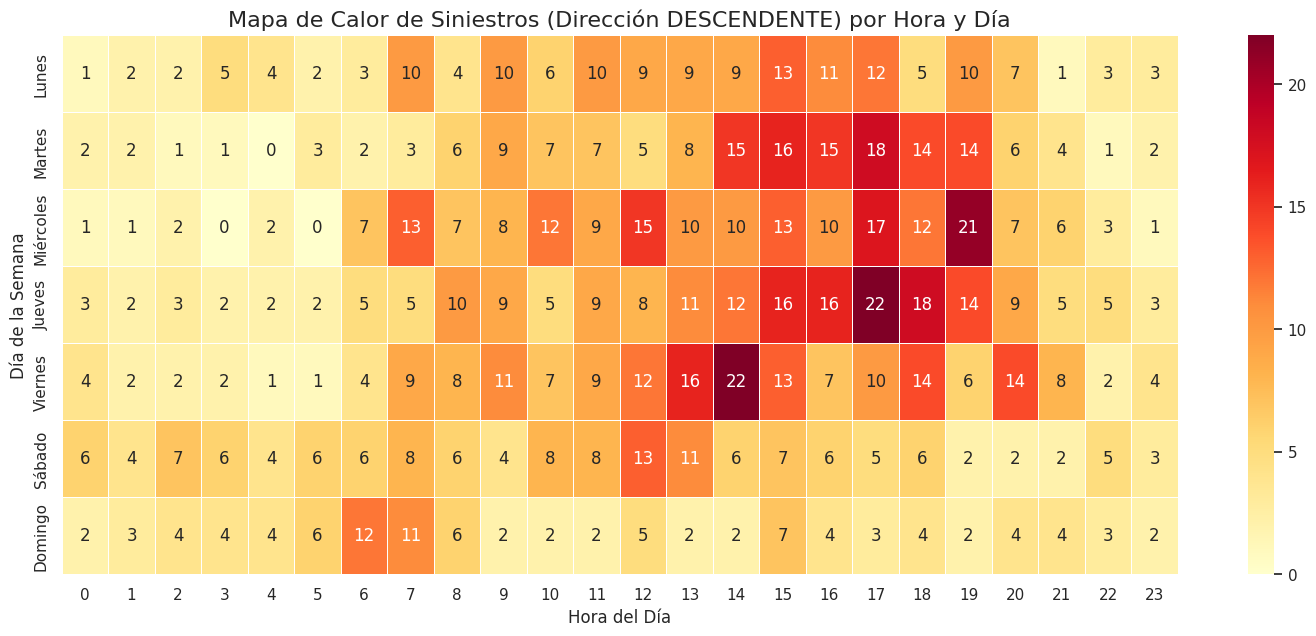

In [ ]:
# --- Mapa de Calor para Dirección DESCENDENTE ---
plt.figure(figsize=(18, 7))
sns.heatmap(heatmap_descendente, cmap='YlOrRd', linewidths=.5, annot=True, fmt='.0f', cbar_kws={'ticks': range(0, int(heatmap_descendente.values.max()) + 5, 5)})
plt.title('Mapa de Calor de Siniestros (Dirección DESCENDENTE) por Hora y Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Día de la Semana', fontsize=12)
plt.show()

###Siniestros por tipo de siniestro


/tmp/ipython-input-4281527342.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=siniestros_por_tipo.index, y=siniestros_por_tipo.values, palette='viridis')


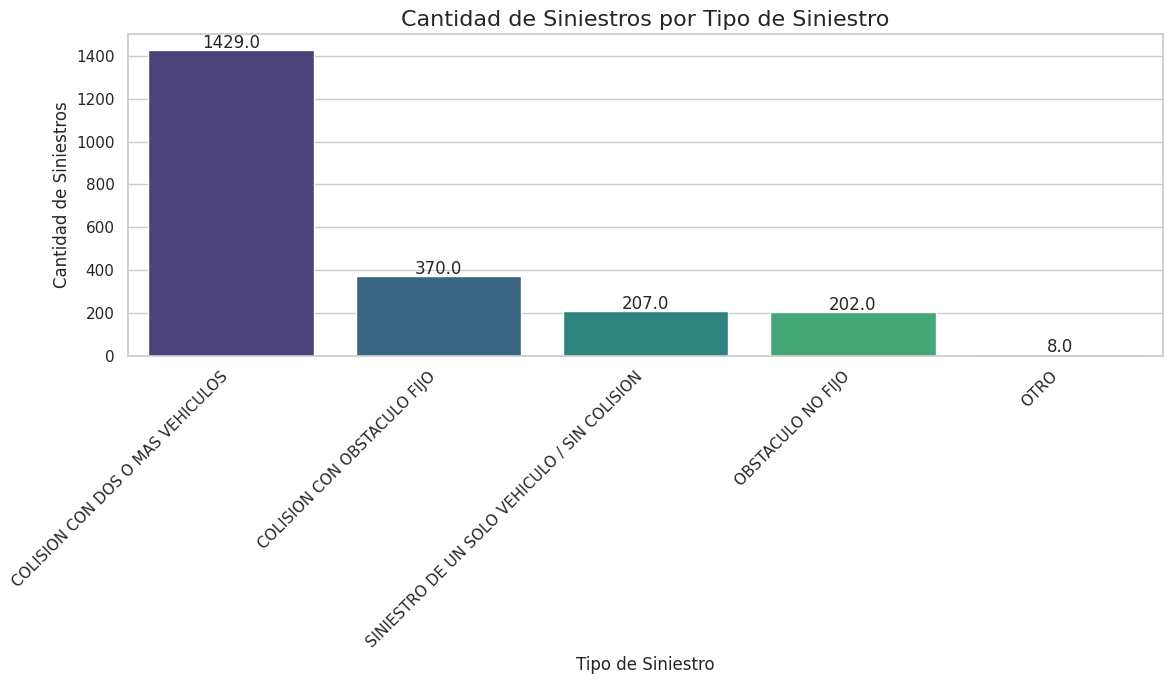

In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Contar la cantidad de siniestros por tipo
siniestros_por_tipo = df_filtrado['TIPO_DE_SINIESTRO'].value_counts()

# Crear el gráfico de barras (histograma)
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=siniestros_por_tipo.index, y=siniestros_por_tipo.values, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Cantidad de Siniestros por Tipo de Siniestro', fontsize=16)
plt.xlabel('Tipo de Siniestro', fontsize=12)
plt.ylabel('Cantidad de Siniestros', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para que no se superpongan
plt.tight_layout() # Ajusta el gráfico para que todo encaje bien

# Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Mostrar el gráfico
plt.show()

### lesionados y fallecidos x condicion meteorologica

/tmp/ipython-input-2518228174.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lesionados_por_clima.index, y=lesionados_por_clima.values, palette='coolwarm')


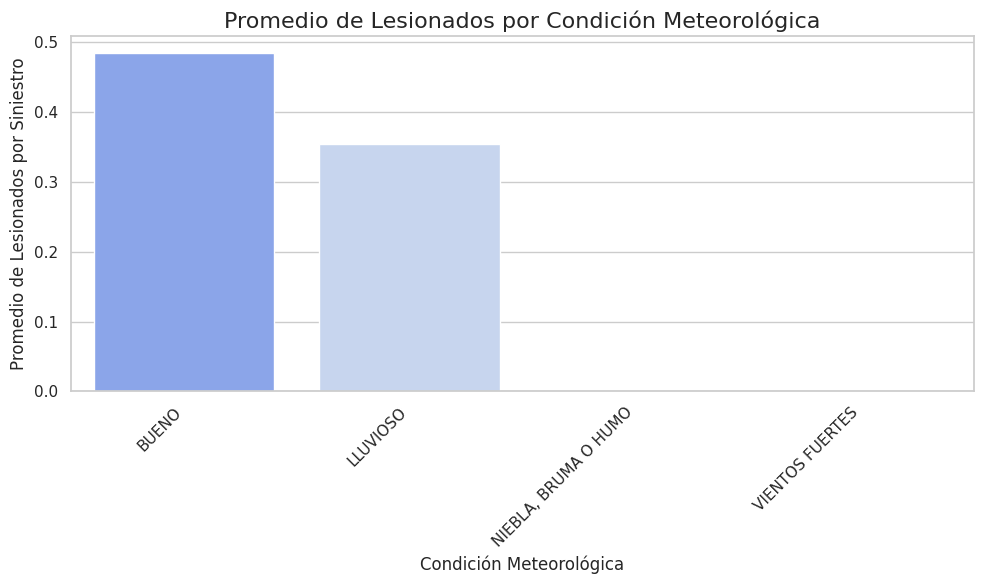

In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Calcular el promedio de lesionados por condición meteorológica
lesionados_por_clima = df_filtrado.groupby('CONDICIONES_METEOROLOGICAS')['LESIONADOS'].mean().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=lesionados_por_clima.index, y=lesionados_por_clima.values, palette='coolwarm')

# Añadir títulos y etiquetas
plt.title('Promedio de Lesionados por Condición Meteorológica', fontsize=16)
plt.xlabel('Condición Meteorológica', fontsize=12)
plt.ylabel('Promedio de Lesionados por Siniestro', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

/tmp/ipython-input-726088716.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fallecidos_por_clima.index, y=fallecidos_por_clima.values, palette='mako')


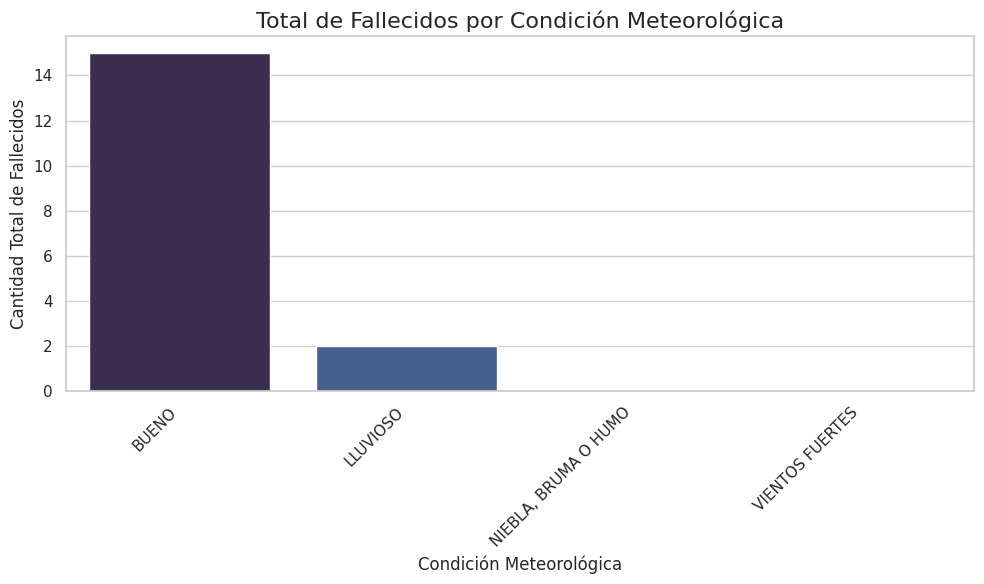

In [ ]:
# Calcular el total de fallecidos por condición meteorológica
fallecidos_por_clima = df_filtrado.groupby('CONDICIONES_METEOROLOGICAS')['FALLECIDOS'].sum().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
# Usamos una paleta diferente para distinguir de los lesionados
sns.barplot(x=fallecidos_por_clima.index, y=fallecidos_por_clima.values, palette='mako')

# Añadir títulos y etiquetas
plt.title('Total de Fallecidos por Condición Meteorológica', fontsize=16)
plt.xlabel('Condición Meteorológica', fontsize=12)
plt.ylabel('Cantidad Total de Fallecidos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Lesionados y fallecidos x estado de la via

/tmp/ipython-input-2611313484.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lesionados_por_superficie.index, y=lesionados_por_superficie.values, palette='coolwarm_r') # Usamos paleta invertida


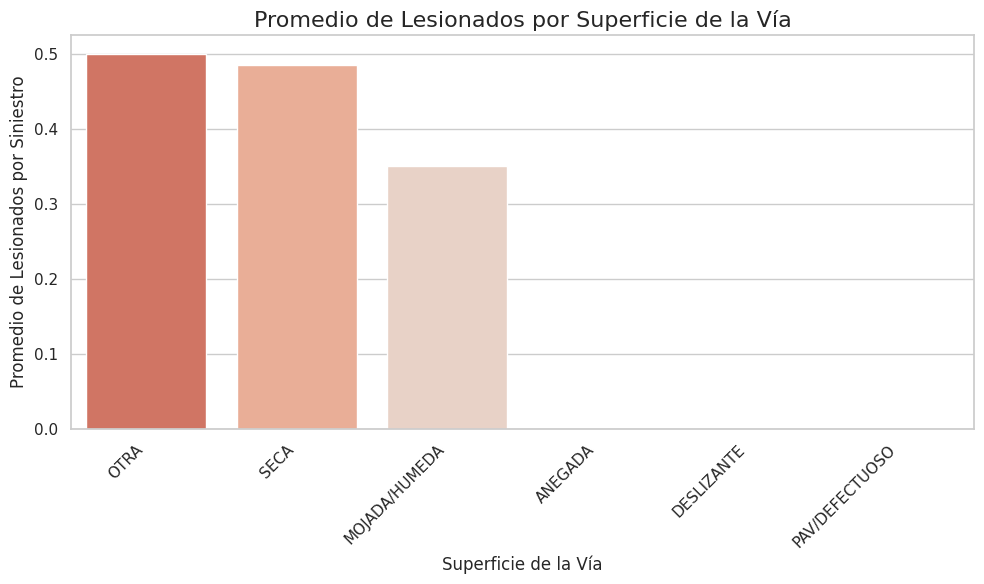

In [ ]:
# Calcular el promedio de lesionados por superficie de la vía
lesionados_por_superficie = df_filtrado.groupby('SUPERFICIE_DE_LA_VIA')['LESIONADOS'].mean().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=lesionados_por_superficie.index, y=lesionados_por_superficie.values, palette='coolwarm_r') # Usamos paleta invertida

# Añadir títulos y etiquetas
plt.title('Promedio de Lesionados por Superficie de la Vía', fontsize=16)
plt.xlabel('Superficie de la Vía', fontsize=12)
plt.ylabel('Promedio de Lesionados por Siniestro', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

/tmp/ipython-input-471650656.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fallecidos_por_superficie.index, y=fallecidos_por_superficie.values, palette='mako_r') # Usamos paleta invertida


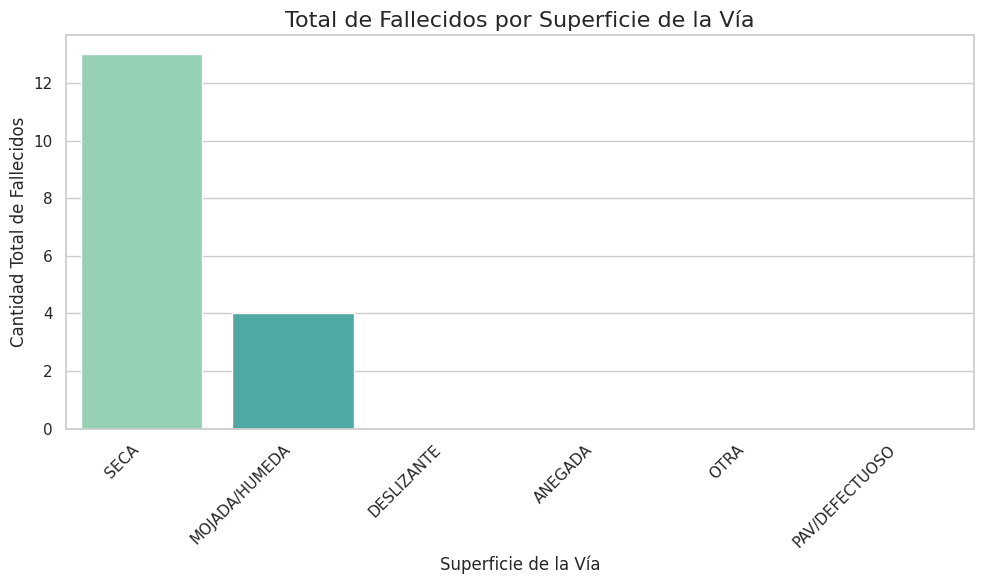

In [ ]:
# Calcular el total de fallecidos por superficie de la vía
fallecidos_por_superficie = df_filtrado.groupby('SUPERFICIE_DE_LA_VIA')['FALLECIDOS'].sum().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=fallecidos_por_superficie.index, y=fallecidos_por_superficie.values, palette='mako_r') # Usamos paleta invertida

# Añadir títulos y etiquetas
plt.title('Total de Fallecidos por Superficie de la Vía', fontsize=16)
plt.xlabel('Superficie de la Vía', fontsize=12)
plt.ylabel('Cantidad Total de Fallecidos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

####Estado de la via en base a la condicion climatica

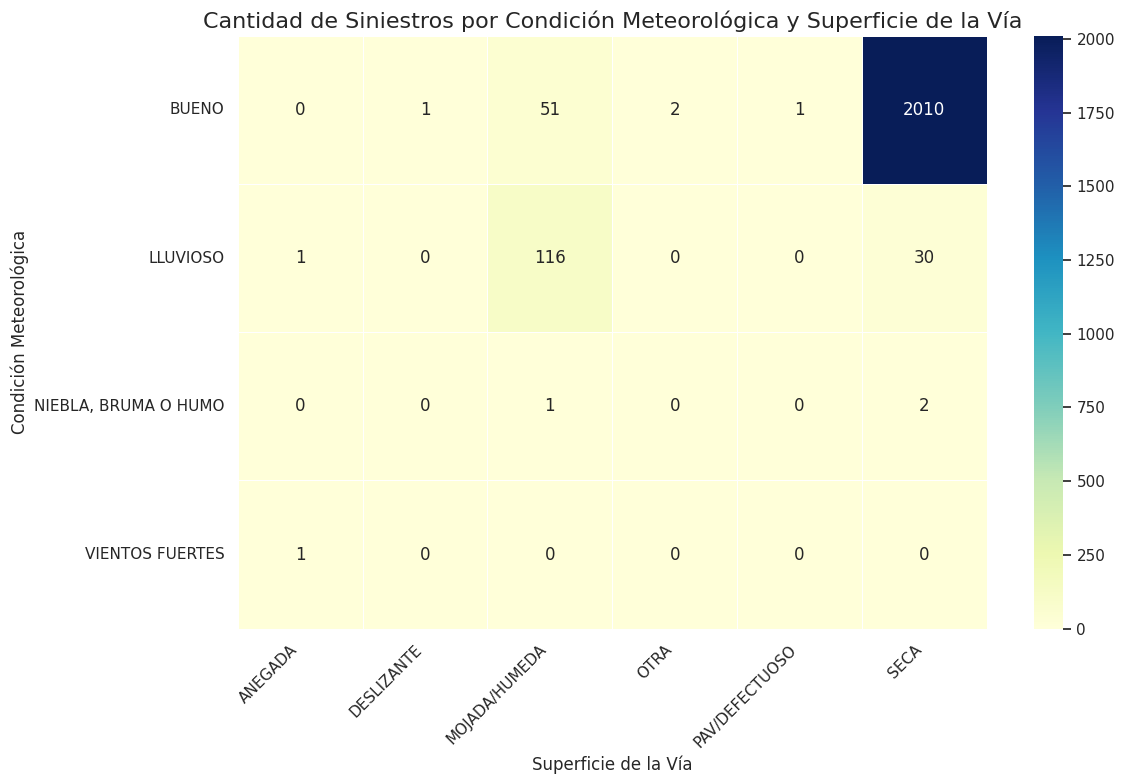


Cantidad de Siniestros por Condición Meteorológica y Superficie de la Vía:
   CONDICIONES_METEOROLOGICAS SUPERFICIE_DE_LA_VIA  Cantidad
0                       BUENO           DESLIZANTE         1
1                       BUENO        MOJADA/HUMEDA        51
2                       BUENO                 OTRA         2
3                       BUENO       PAV/DEFECTUOSO         1
4                       BUENO                 SECA      2010
5                    LLUVIOSO              ANEGADA         1
6                    LLUVIOSO        MOJADA/HUMEDA       116
7                    LLUVIOSO                 SECA        30
8        NIEBLA, BRUMA O HUMO        MOJADA/HUMEDA         1
9        NIEBLA, BRUMA O HUMO                 SECA         2
10            VIENTOS FUERTES              ANEGADA         1


In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Contar siniestros por Condición Meteorológica y Superficie de la Vía
siniestros_clima_superficie = df_filtrado.groupby(['CONDICIONES_METEOROLOGICAS', 'SUPERFICIE_DE_LA_VIA']).size().reset_index(name='Cantidad')

# Pivotear la tabla para el formato del heatmap
heatmap_clima_superficie = siniestros_clima_superficie.pivot_table(
    index='CONDICIONES_METEOROLOGICAS',
    columns='SUPERFICIE_DE_LA_VIA',
    values='Cantidad',
    fill_value=0
)

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_clima_superficie, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5) # Changed fmt='d' to fmt='.0f'

# Añadir títulos y etiquetas
plt.title('Cantidad de Siniestros por Condición Meteorológica y Superficie de la Vía', fontsize=16)
plt.xlabel('Superficie de la Vía', fontsize=12)
plt.ylabel('Condición Meteorológica', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar la tabla con los valores exactos
print("\nCantidad de Siniestros por Condición Meteorológica y Superficie de la Vía:")
print(siniestros_clima_superficie)

### Vehiculos mas implicados segun tipo de accidente

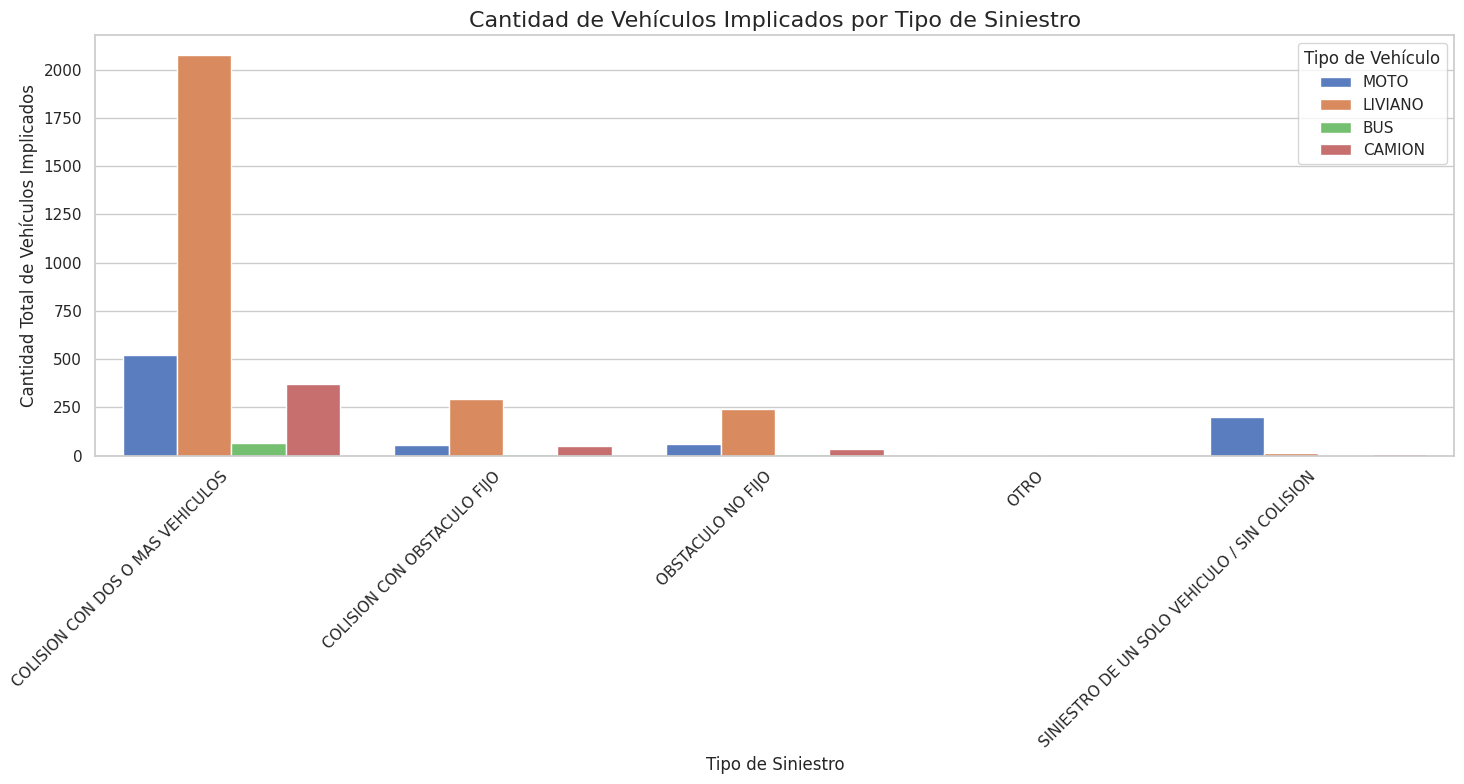

In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Agrupar por tipo de siniestro y sumar la cantidad de cada tipo de vehículo
vehiculos_por_siniestro = df_filtrado.groupby('TIPO_DE_SINIESTRO')[['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum()

# Reorganizar los datos (melt) para que sea más fácil graficar con seaborn
vehiculos_por_siniestro_melt = vehiculos_por_siniestro.reset_index().melt(id_vars='TIPO_DE_SINIESTRO', var_name='TIPO_VEHICULO', value_name='CANTIDAD')

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(15, 8))
sns.barplot(data=vehiculos_por_siniestro_melt, x='TIPO_DE_SINIESTRO', y='CANTIDAD', hue='TIPO_VEHICULO', palette='muted')

# Añadir títulos y etiquetas
plt.title('Cantidad de Vehículos Implicados por Tipo de Siniestro', fontsize=16)
plt.xlabel('Tipo de Siniestro', fontsize=12)
plt.ylabel('Cantidad Total de Vehículos Implicados', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Vehículo')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Total de vehiculo implicado en cada tipo lesionados y fallecidos

/tmp/ipython-input-1450160711.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=total_vehiculos.index, y=total_vehiculos.values, palette='viridis')


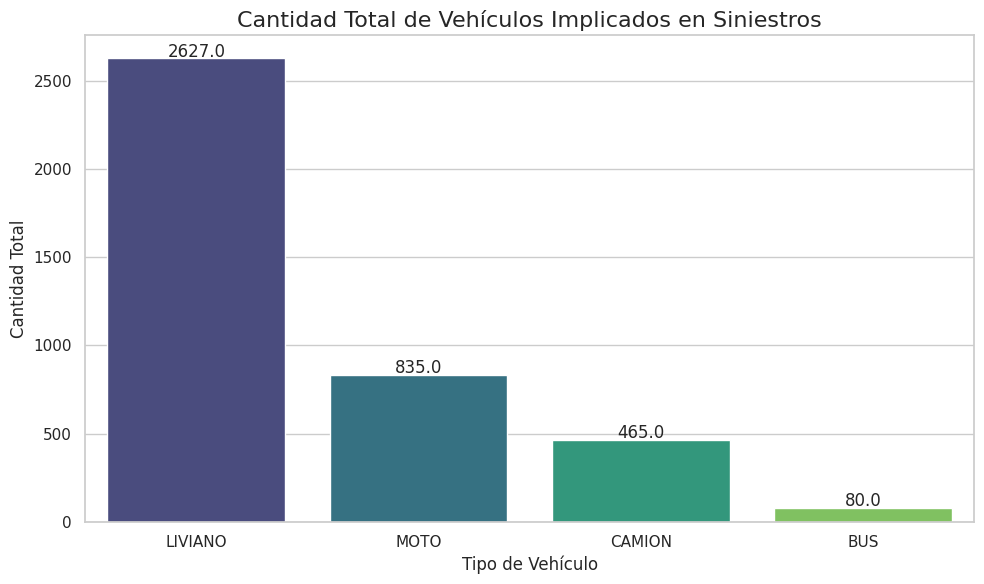


Cantidad Total de Vehículos Implicados por Tipo:
LIVIANO    2627
MOTO        835
CAMION      465
BUS          80
dtype: int64


In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Sumar la cantidad total de cada tipo de vehículo implicado en todos los siniestros
total_vehiculos = df_filtrado[['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum().sort_values(ascending=False)

# Crear el gráfico de barras (histograma)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=total_vehiculos.index, y=total_vehiculos.values, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Cantidad Total de Vehículos Implicados en Siniestros', fontsize=16)
plt.xlabel('Tipo de Vehículo', fontsize=12)
plt.ylabel('Cantidad Total', fontsize=12)
plt.xticks(rotation=0) # No necesitamos rotar si los nombres de los vehículos encajan
plt.tight_layout() # Ajusta el gráfico para que todo encaje bien

# Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Mostrar el gráfico
plt.show()

# Opcional: Mostrar la tabla con los valores exactos
print("\nCantidad Total de Vehículos Implicados por Tipo:")
print(total_vehiculos)

/tmp/ipython-input-2309727496.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vehiculos_lesionados.index, y=vehiculos_lesionados.values, palette='viridis')


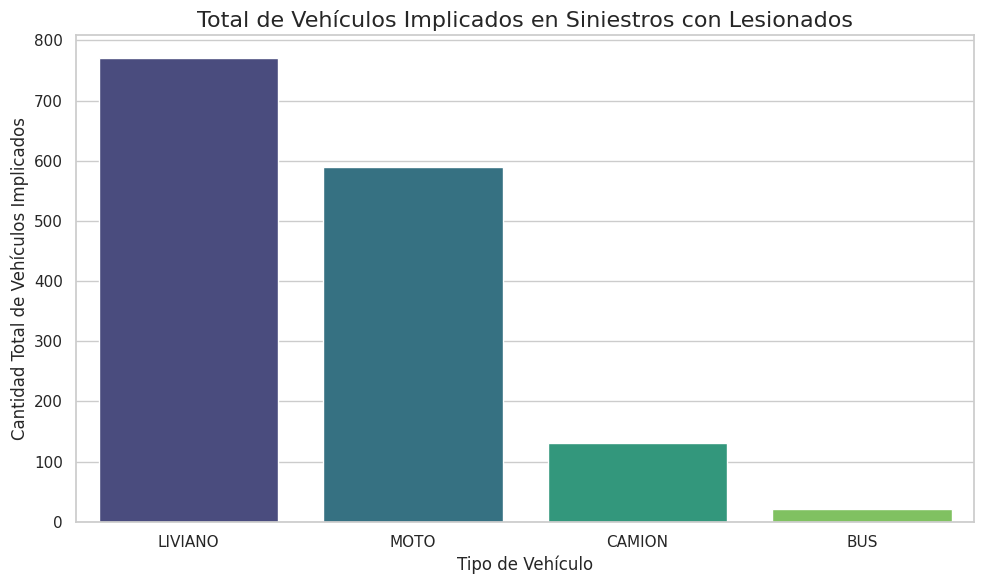

In [ ]:
# Filtrar siniestros con al menos un lesionado
siniestros_con_lesionados = df_filtrado[df_filtrado['LESIONADOS'] > 0]

# Sumar la cantidad de cada tipo de vehículo en estos siniestros
vehiculos_lesionados = siniestros_con_lesionados[['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=vehiculos_lesionados.index, y=vehiculos_lesionados.values, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Total de Vehículos Implicados en Siniestros con Lesionados', fontsize=16)
plt.xlabel('Tipo de Vehículo', fontsize=12)
plt.ylabel('Cantidad Total de Vehículos Implicados', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

/tmp/ipython-input-1750378213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vehiculos_fallecidos.index, y=vehiculos_fallecidos.values, palette='rocket')


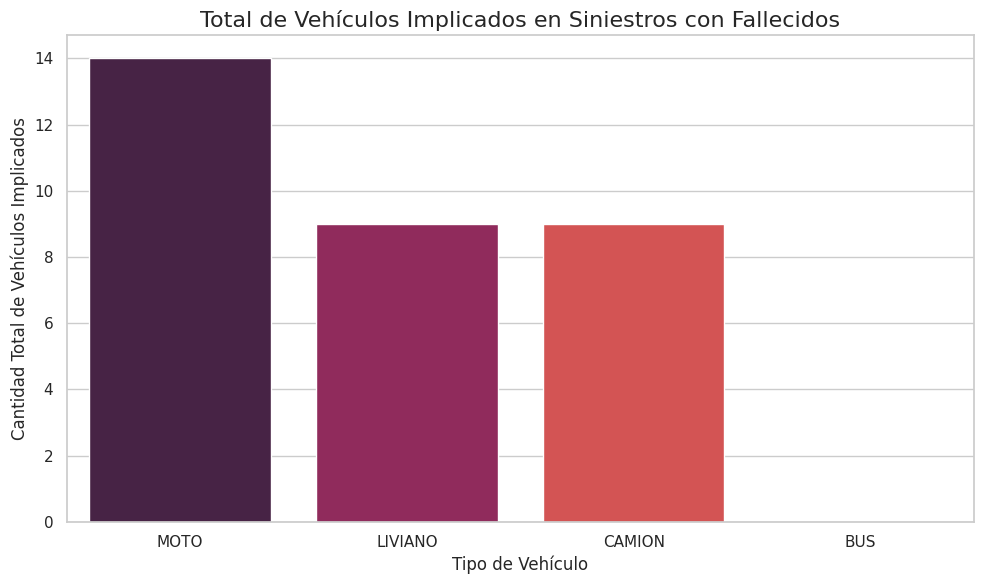

In [ ]:
# Filtrar siniestros con al menos un fallecido
siniestros_con_fallecidos = df_filtrado[df_filtrado['FALLECIDOS'] > 0]

# Sumar la cantidad de cada tipo de vehículo en estos siniestros
vehiculos_fallecidos = siniestros_con_fallecidos[['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=vehiculos_fallecidos.index, y=vehiculos_fallecidos.values, palette='rocket')

# Añadir títulos y etiquetas
plt.title('Total de Vehículos Implicados en Siniestros con Fallecidos', fontsize=16)
plt.xlabel('Tipo de Vehículo', fontsize=12)
plt.ylabel('Cantidad Total de Vehículos Implicados', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

/tmp/ipython-input-1998939831.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vehiculos_ilesos.index, y=vehiculos_ilesos.values, palette='Greens_d')


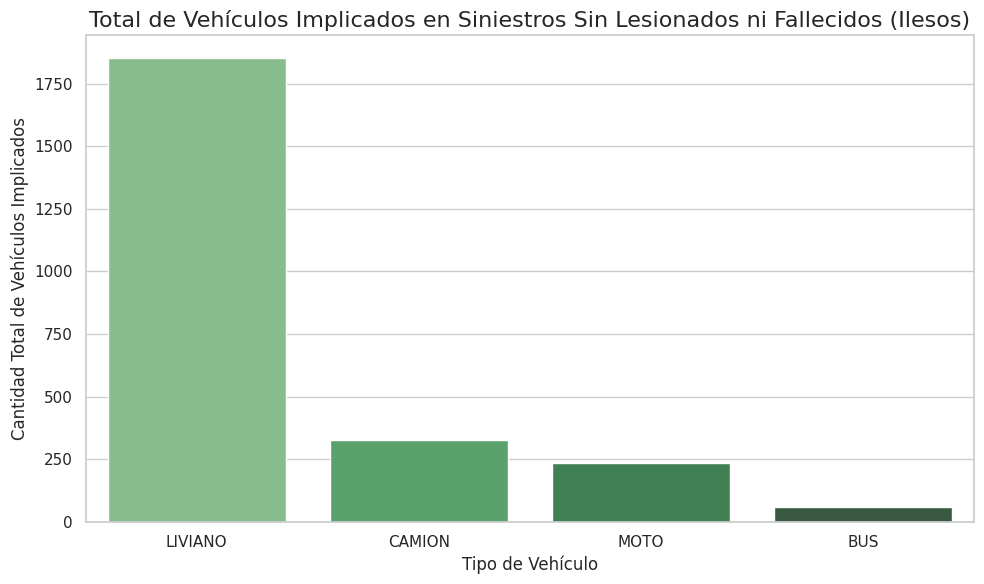


Total de Vehículos Implicados en Siniestros Ilesos:
LIVIANO    1851
CAMION      326
MOTO        234
BUS          58
dtype: int64


In [ ]:
# Filtrar siniestros sin lesionados ni fallecidos (ilesos)
siniestros_ilesos = df_filtrado[(df_filtrado['LESIONADOS'] == 0) & (df_filtrado['FALLECIDOS'] == 0)].copy()

# Sumar la cantidad de cada tipo de vehículo en estos siniestros
# Solo consideramos los vehículos que tienen un conteo mayor a 0 en estos siniestros
vehiculos_ilesos = siniestros_ilesos[['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum()

# Filtrar los tipos de vehículos que estuvieron implicados al menos una vez
vehiculos_ilesos = vehiculos_ilesos[vehiculos_ilesos > 0].sort_values(ascending=False)

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=vehiculos_ilesos.index, y=vehiculos_ilesos.values, palette='Greens_d')

# Añadir títulos y etiquetas
plt.title('Total de Vehículos Implicados en Siniestros Sin Lesionados ni Fallecidos (Ilesos)', fontsize=16)
plt.xlabel('Tipo de Vehículo', fontsize=12)
plt.ylabel('Cantidad Total de Vehículos Implicados', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar la tabla con los valores exactos
print("\nTotal de Vehículos Implicados en Siniestros Ilesos:")
print(vehiculos_ilesos)

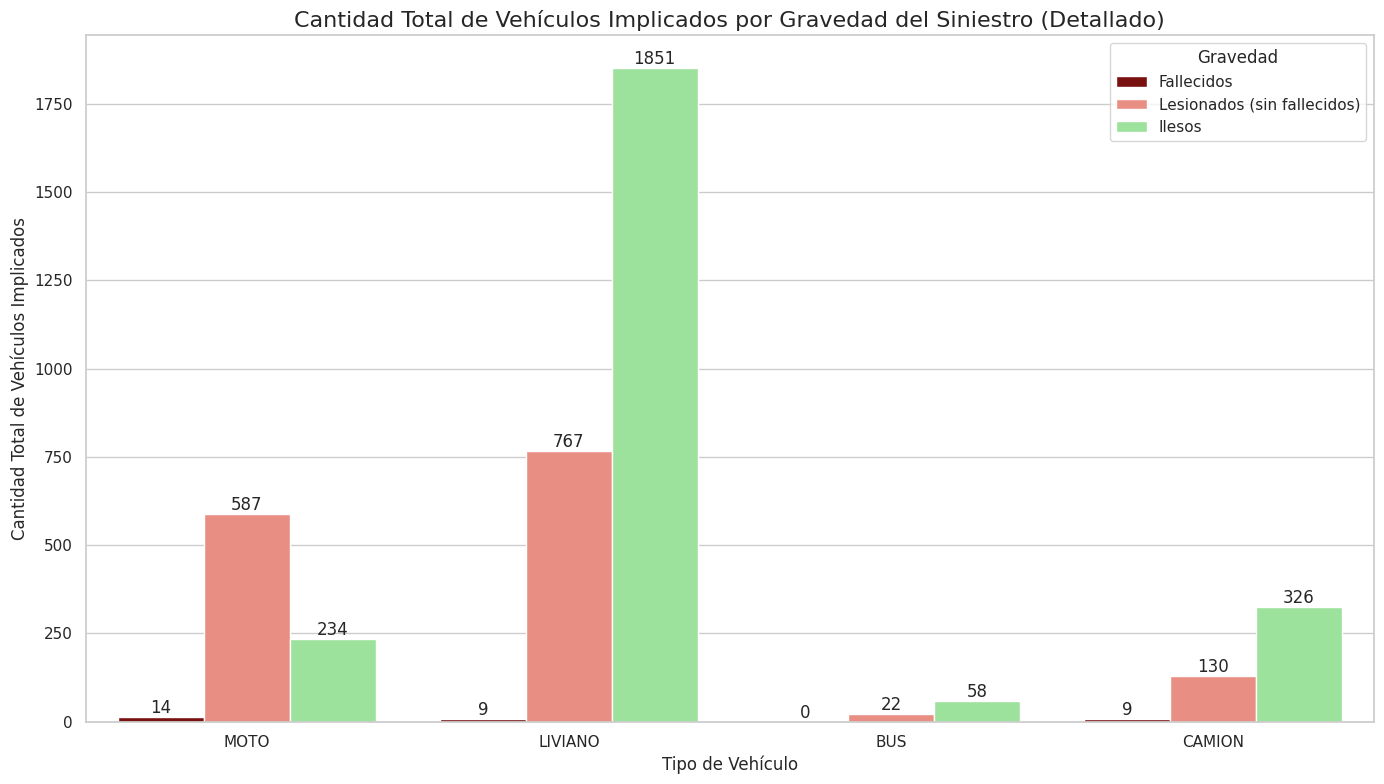


Data for Vehicles Involved by Detailed Severity:
   Vehicle_Type  Count                     Severity
0          MOTO     14                   Fallecidos
1       LIVIANO      9                   Fallecidos
2           BUS      0                   Fallecidos
3        CAMION      9                   Fallecidos
4          MOTO    587  Lesionados (sin fallecidos)
5       LIVIANO    767  Lesionados (sin fallecidos)
6           BUS     22  Lesionados (sin fallecidos)
7        CAMION    130  Lesionados (sin fallecidos)
8          MOTO    234                       Ilesos
9       LIVIANO   1851                       Ilesos
10          BUS     58                       Ilesos
11       CAMION    326                       Ilesos


In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Calculate the total number of Lesionados, Fallecidos, and Ilesos individuals by vehicle type.
# This requires iterating through each incident and summing the Lesionados/Fallecidos
# for vehicles involved in that incident, and counting ilesos vehicles.

# Initialize dictionaries to store counts
lesionados_by_vehicle = {'MOTO': 0, 'LIVIANO': 0, 'BUS': 0, 'CAMION': 0}
fallecidos_by_vehicle = {'MOTO': 0, 'LIVIANO': 0, 'BUS': 0, 'CAMION': 0}
ilesos_by_vehicle = {'MOTO': 0, 'LIVIANO': 0, 'BUS': 0, 'CAMION': 0}


# Iterate through each row (incident) in the dataframe
for index, row in df_filtrado.iterrows():
    # Check if the incident had injured individuals
    if row['LESIONADOS'] > 0:
        # Distribute the number of injured individuals among the involved vehicles
        # This is a simplification; we don't know which person was in which vehicle.
        # We'll assume the injured individuals are distributed proportionally or equally
        # among the involved vehicles of each type. A simpler approach is to just
        # count the number of vehicles of each type involved in incidents with injuries.
        # Let's go with counting vehicles in incidents with injuries/fatalities vs no injuries/fatalities.

        # The previous approach of counting vehicles involved in 'Grave' vs 'Leve' incidents was closer
        # to what the user seems to want now, but we need to clarify "implicated by each vehicle".
        # Does the user mean:
        # 1. Total individuals injured who were in a MOTO, LIVIANO, BUS, CAMION? (This data isn't directly available)
        # 2. Total number of MOTO incidents that had any Lesionados, Fallecidos, or neither? (This is what the 'Grave'/'Leve' grouping showed)
        # 3. Total count of vehicles of each type involved in incidents with Lesionados, Fallecidos, or neither? (This is what the previous code produced)

        # Let's assume the user wants to see the *number of vehicles of each type* that were involved in incidents
        # that resulted in Lesionados, Fallecidos, or were Ilesos. This aligns with the last successful plot,
        # but maybe the labels or the interpretation was confusing.

        # The previous code calculated:
        # 'Grave': Total count of vehicles of that type involved in incidents with LESIONADOS > 0 or FALLECIDOS > 0
        # 'Leve': Total count of vehicles of that type involved in incidents with LESIONADOS == 0 and FALLECIDOS == 0

        # This seems to be the most reasonable interpretation based on the available data.
        # Let's try to make the labels clearer in the plot.

        pass # The calculation is already done in the previous version of the cell


# The data structure `gravedad_por_vehiculo_counts` from the previous run
# already contains the counts of vehicles involved in 'Grave' and 'Leve' incidents.
# 'Grave' corresponds to incidents with Lesionados or Fallecidos.
# 'Leve' corresponds to incidents with Ilesos.

# We can rename 'Grave' to 'Lesionados/Fallecidos' and 'Leve' to 'Ilesos' for clarity in the plot.
# Or, we can separate 'Lesionados' and 'Fallecidos' if the user wants that level of detail.

# Based on the user's request "cantidad de fallecidos, lesionados e ilesos implicados por cada vehiculo",
# it's likely they want to see three bars per vehicle type: total vehicles in incidents with Lesionados,
# total vehicles in incidents with Fallecidos, and total vehicles in incidents with Ilesos.
# However, an incident can have both Lesionados and Fallecidos.
# A better approach is to calculate:
# 1. Total vehicles of type X involved in incidents with at least one Lesionado.
# 2. Total vehicles of type X involved in incidents with at least one Fallecido.
# 3. Total vehicles of type X involved in incidents with zero Lesionados AND zero Fallecidos (Ilesos).

# This still has overlap (a vehicle can be in an incident with both Lesionados and Fallecidos).
# The clearest representation might be:
# - Total vehicles in incidents with Fallecidos > 0
# - Total vehicles in incidents with Lesionados > 0 AND Fallecidos == 0
# - Total vehicles in incidents with Lesionados == 0 AND Fallecidos == 0 (Ilesos)

# Let's calculate these three categories for each vehicle type.

vehiculos_con_fallecidos = df_filtrado[df_filtrado['FALLECIDOS'] > 0][['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum().reset_index(name='Count')
vehiculos_con_fallecidos['Severity'] = 'Fallecidos'
vehiculos_con_fallecidos.rename(columns={'index': 'Vehicle_Type'}, inplace=True)

vehiculos_solo_lesionados = df_filtrado[(df_filtrado['LESIONADOS'] > 0) & (df_filtrado['FALLECIDOS'] == 0)][['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum().reset_index(name='Count')
vehiculos_solo_lesionados['Severity'] = 'Lesionados (sin fallecidos)'
vehiculos_solo_lesionados.rename(columns={'index': 'Vehicle_Type'}, inplace=True)


vehiculos_ilesos_incidents = df_filtrado[(df_filtrado['LESIONADOS'] == 0) & (df_filtrado['FALLECIDOS'] == 0)][['MOTO', 'LIVIANO', 'BUS', 'CAMION']].sum().reset_index(name='Count')
vehiculos_ilesos_incidents['Severity'] = 'Ilesos'
vehiculos_ilesos_incidents.rename(columns={'index': 'Vehicle_Type'}, inplace=True)

# Concatenate the results
gravedad_por_vehiculo_detailed = pd.concat([vehiculos_con_fallecidos, vehiculos_solo_lesionados, vehiculos_ilesos_incidents], ignore_index=True)

# Create the grouped bar plot with the new detailed categories
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=gravedad_por_vehiculo_detailed, x='Vehicle_Type', y='Count', hue='Severity', palette={'Fallecidos': 'darkred', 'Lesionados (sin fallecidos)': 'salmon', 'Ilesos': 'lightgreen'}) # Adjusted palette


# Añadir títulos y etiquetas
plt.title('Cantidad Total de Vehículos Implicados por Gravedad del Siniestro (Detallado)', fontsize=16)
plt.xlabel('Tipo de Vehículo', fontsize=12)
plt.ylabel('Cantidad Total de Vehículos Implicados', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Gravedad')
plt.tight_layout()

# Add values at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')


# Mostrar el gráfico
plt.show()

# Optional: Display the data used for the plot
print("\nData for Vehicles Involved by Detailed Severity:")
print(gravedad_por_vehiculo_detailed)

### Tendencia x mes/anio de siniestros

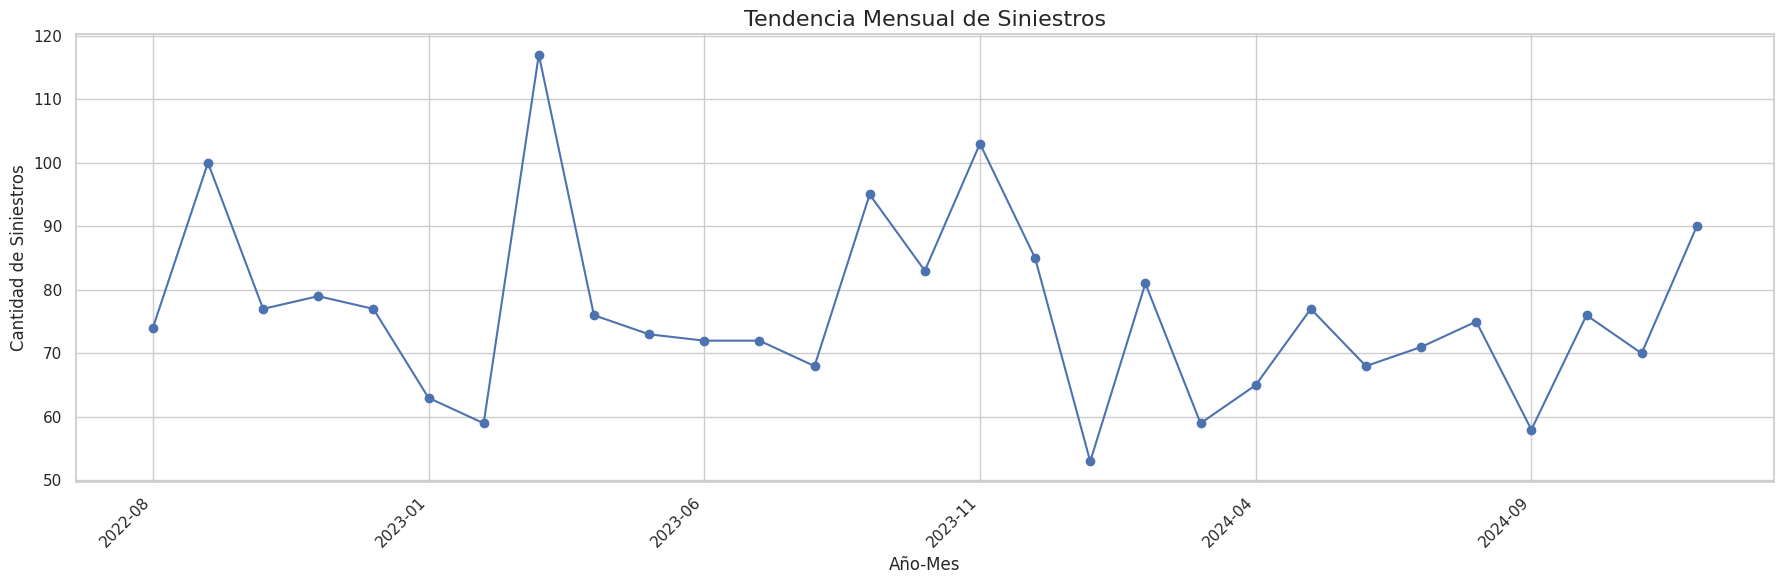

In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Asegurar que MES y AÑO son strings para concatenar, añadiendo cero si es necesario
df_filtrado['MES_STR'] = df_filtrado['MES'].astype(str).str.zfill(2)
df_filtrado['AÑO_STR'] = df_filtrado['AÑO'].astype(str)
df_filtrado['AÑO_MES'] = df_filtrado['AÑO_STR'] + '-' + df_filtrado['MES_STR']

# Contar siniestros por AÑO_MES
siniestros_mensuales = df_filtrado.groupby('AÑO_MES').size()

# Crear el gráfico de líneas
plt.figure(figsize=(18, 6))
siniestros_mensuales.plot(kind='line', marker='o', linestyle='-')

# Añadir títulos y etiquetas
plt.title('Tendencia Mensual de Siniestros', fontsize=16)
plt.xlabel('Año-Mes', fontsize=12)
plt.ylabel('Cantidad de Siniestros', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True) # Aseguramos que la grilla esté visible
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Opcional: Eliminar columnas temporales si ya no las uso
# por ahora quedan igual es un copy
# df_filtrado.drop(columns=['MES_STR', 'AÑO_STR', 'AÑO_MES'], inplace=True)

#### Tendencia simplemente anual

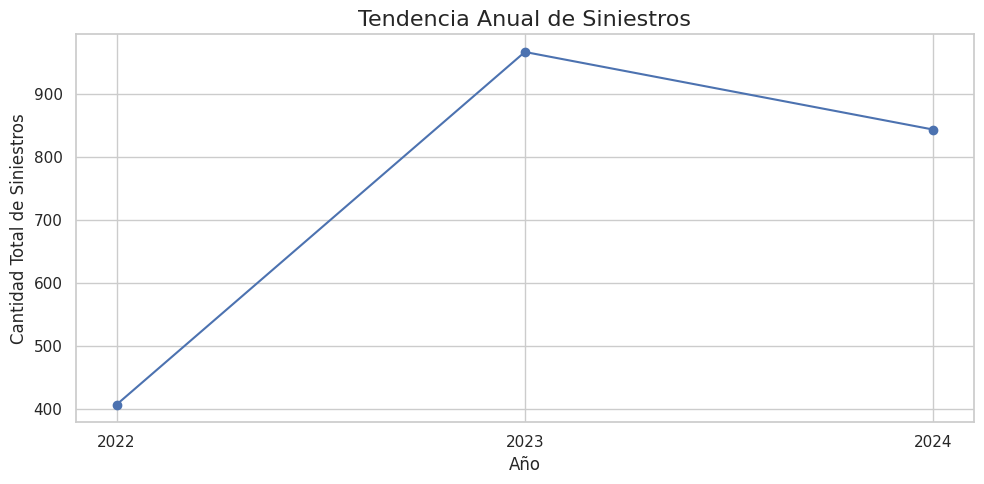

In [ ]:
# Contar siniestros por AÑO
siniestros_anuales = df_filtrado.groupby('AÑO').size()

# Crear el gráfico de líneas
plt.figure(figsize=(10, 5))
siniestros_anuales.plot(kind='line', marker='o', linestyle='-')

# Añadir títulos y etiquetas
plt.title('Tendencia Anual de Siniestros', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad Total de Siniestros', fontsize=12)
# Aseguramos que los años se muestren como enteros en el eje X
plt.xticks(siniestros_anuales.index)
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### PK con mas siniestros

/tmp/ipython-input-896115539.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_15_autopista_pk['Etiqueta'] = top_15_autopista_pk['AUTOPISTA'] + ' - PK ' + top_15_autopista_pk['PK'].astype(str)
/tmp/ipython-input-896115539.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Etiqueta', y='Cantidad', data=top_15_autopista_pk, palette='magma') # Usamos la nueva columna 'Etiqueta'


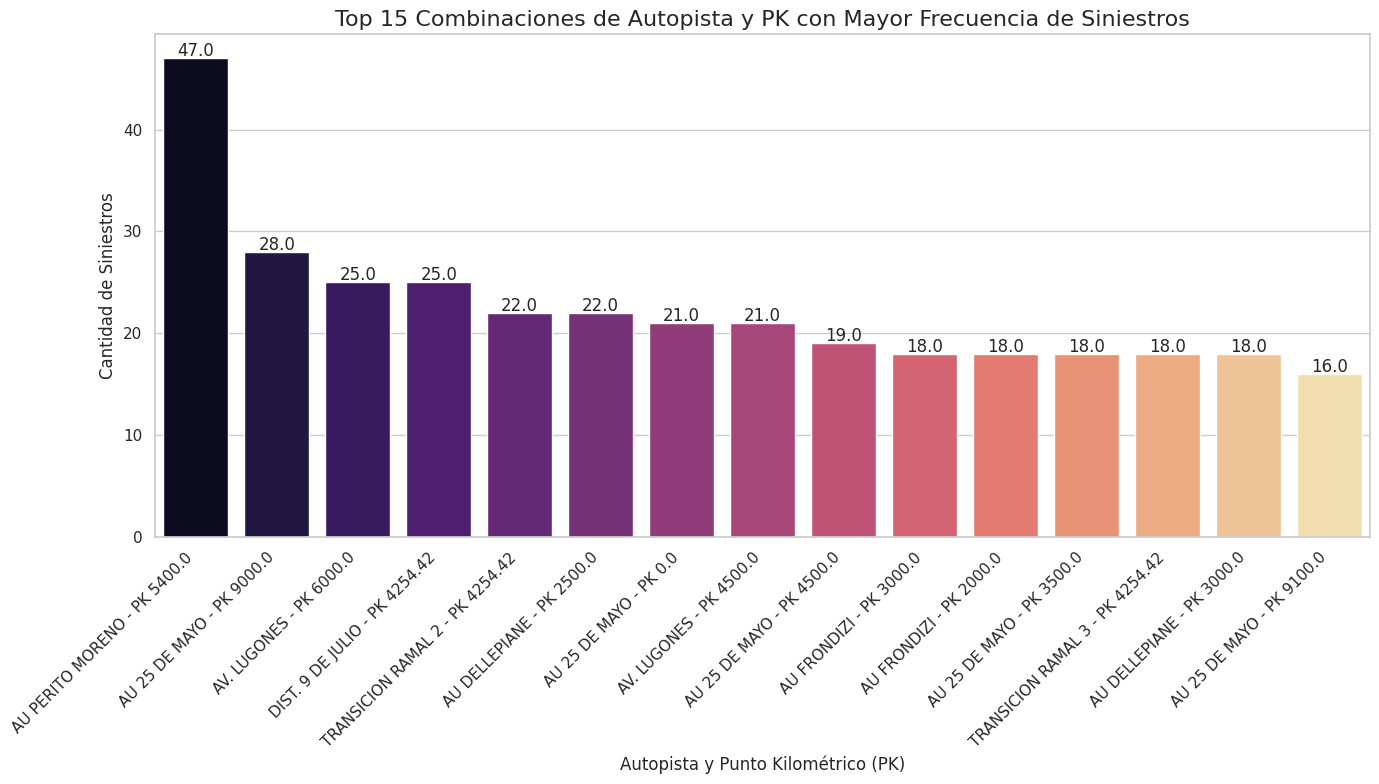


Top 15 Combinaciones de Autopista y PK con más siniestros:
         AUTOPISTA      PK  Cantidad
  AU PERITO MORENO 5400.00        47
     AU 25 DE MAYO 9000.00        28
       AV. LUGONES 6000.00        25
  DIST. 9 DE JULIO 4254.42        25
TRANSICION RAMAL 2 4254.42        22
     AU DELLEPIANE 2500.00        22
     AU 25 DE MAYO    0.00        21
       AV. LUGONES 4500.00        21
     AU 25 DE MAYO 4500.00        19
       AU FRONDIZI 3000.00        18
       AU FRONDIZI 2000.00        18
     AU 25 DE MAYO 3500.00        18
TRANSICION RAMAL 3 4254.42        18
     AU DELLEPIANE 3000.00        18
     AU 25 DE MAYO 9100.00        16


In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Contar la frecuencia de cada combinación de Autopista y PK
autopista_pk_counts = df_filtrado.groupby(['AUTOPISTA', 'PK']).size().reset_index(name='Cantidad')

# Ordenar por la cantidad de siniestros en orden descendente
autopista_pk_counts_sorted = autopista_pk_counts.sort_values(by='Cantidad', ascending=False)

# Seleccionar las 15 combinaciones de Autopista y PK más frecuentes
top_15_autopista_pk = autopista_pk_counts_sorted.head(15)

# Crear una etiqueta combinada para el eje X
top_15_autopista_pk['Etiqueta'] = top_15_autopista_pk['AUTOPISTA'] + ' - PK ' + top_15_autopista_pk['PK'].astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(14, 8)) # Aumentar el tamaño de la figura para que quepan las etiquetas
ax = sns.barplot(x='Etiqueta', y='Cantidad', data=top_15_autopista_pk, palette='magma') # Usamos la nueva columna 'Etiqueta'

# Añadir títulos y etiquetas
plt.title('Top 15 Combinaciones de Autopista y PK con Mayor Frecuencia de Siniestros', fontsize=16)
plt.xlabel('Autopista y Punto Kilométrico (PK)', fontsize=12)
plt.ylabel('Cantidad de Siniestros', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para que no se superpongan
plt.tight_layout() # Ajusta el gráfico para que todo encaje bien

# Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Mostrar el gráfico
plt.show()

# Mostrar la tabla con los valores exactos
print("\nTop 15 Combinaciones de Autopista y PK con más siniestros:")
print(top_15_autopista_pk[['AUTOPISTA', 'PK', 'Cantidad']].to_string(index=False))

#### Mayores pk son siniestros en las autopistas mas siniestradas

/tmp/ipython-input-2373285968.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pk_autopista.index.astype(str), y=top_pk_autopista.values, palette='viridis')


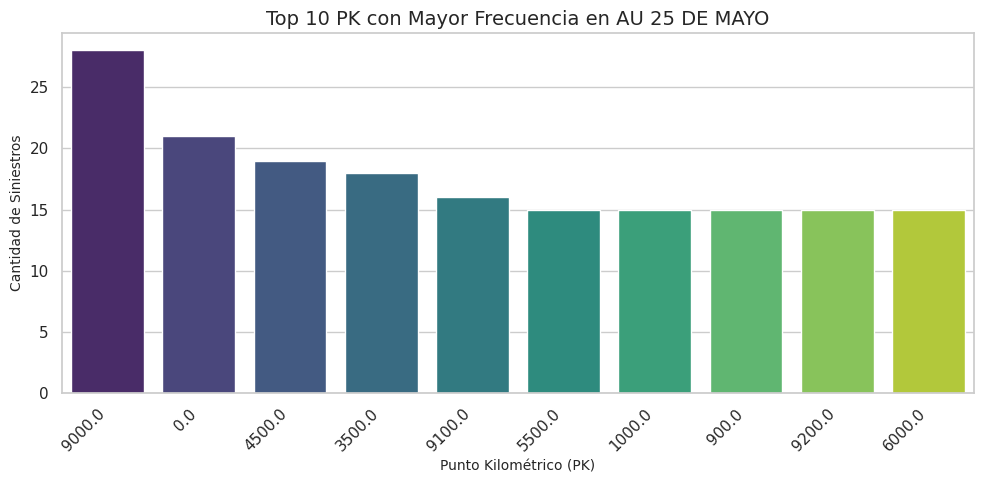


Top 10 PK en AU 25 DE MAYO:
PK
9000.0    28
0.0       21
4500.0    19
3500.0    18
9100.0    16
5500.0    15
1000.0    15
900.0     15
9200.0    15
6000.0    15
Name: count, dtype: int64


/tmp/ipython-input-2373285968.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pk_autopista.index.astype(str), y=top_pk_autopista.values, palette='viridis')


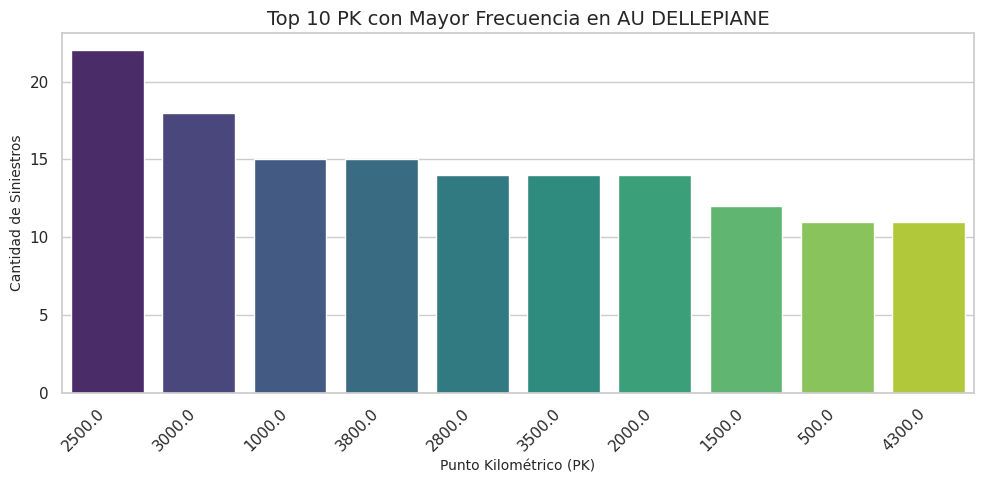


Top 10 PK en AU DELLEPIANE:
PK
2500.0    22
3000.0    18
1000.0    15
3800.0    15
2800.0    14
3500.0    14
2000.0    14
1500.0    12
500.0     11
4300.0    11
Name: count, dtype: int64


/tmp/ipython-input-2373285968.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pk_autopista.index.astype(str), y=top_pk_autopista.values, palette='viridis')


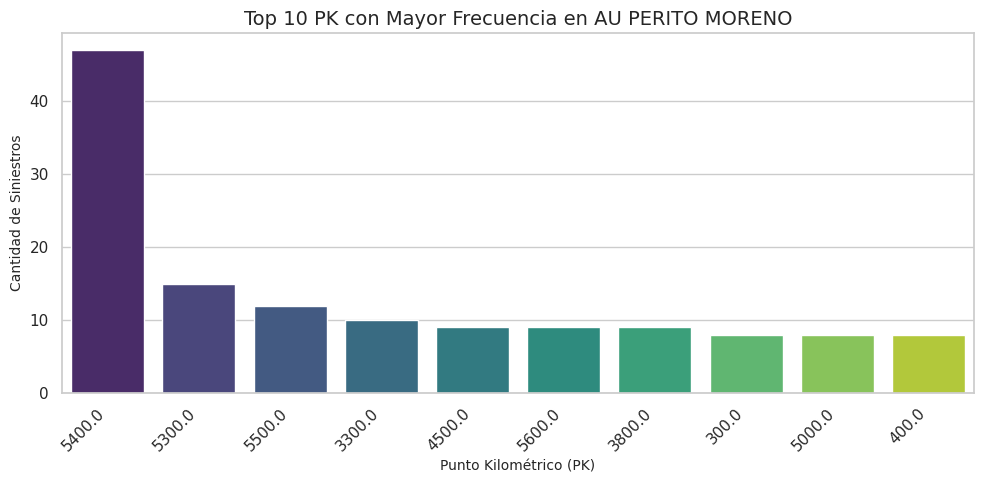


Top 10 PK en AU PERITO MORENO:
PK
5400.0    47
5300.0    15
5500.0    12
3300.0    10
4500.0     9
5600.0     9
3800.0     9
300.0      8
5000.0     8
400.0      8
Name: count, dtype: int64


In [ ]:
# Identificar las 3 autopistas con más siniestros
top_autopistas = df_filtrado['AUTOPISTA'].value_counts().head(3).index.tolist()

# Iterar sobre cada una de las autopistas principales
for autopista in top_autopistas:
    # Filtrar el DataFrame para la autopista actual
    df_autopista = df_filtrado[df_filtrado['AUTOPISTA'] == autopista]

    # Contar la frecuencia de PK para esa autopista
    pk_counts_autopista = df_autopista['PK'].value_counts()

    # Seleccionar los 10 PK más frecuentes (o menos si no hay tantos)
    top_pk_autopista = pk_counts_autopista.head(10)

    # Crear el gráfico de barras si hay datos para graficar
    if not top_pk_autopista.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_pk_autopista.index.astype(str), y=top_pk_autopista.values, palette='viridis')

        # Añadir títulos y etiquetas
        plt.title(f'Top 10 PK con Mayor Frecuencia en {autopista}', fontsize=14)
        plt.xlabel('Punto Kilométrico (PK)', fontsize=10)
        plt.ylabel('Cantidad de Siniestros', fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        # Mostrar el gráfico
        plt.show()

        # Mostrar la tabla con los valores exactos
        print(f"\nTop 10 PK en {autopista}:")
        print(top_pk_autopista)
    else:
        print(f"\nNo hay suficientes datos de PK para graficar en {autopista}.")

### Dias con mas siniestros (me llamo la atencion del cuadro de los anios y meses ver que paso en marzo)

/tmp/ipython-input-3937453541.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_dias.index.strftime('%Y-%m-%d'), y=top_10_dias.values, palette='plasma')


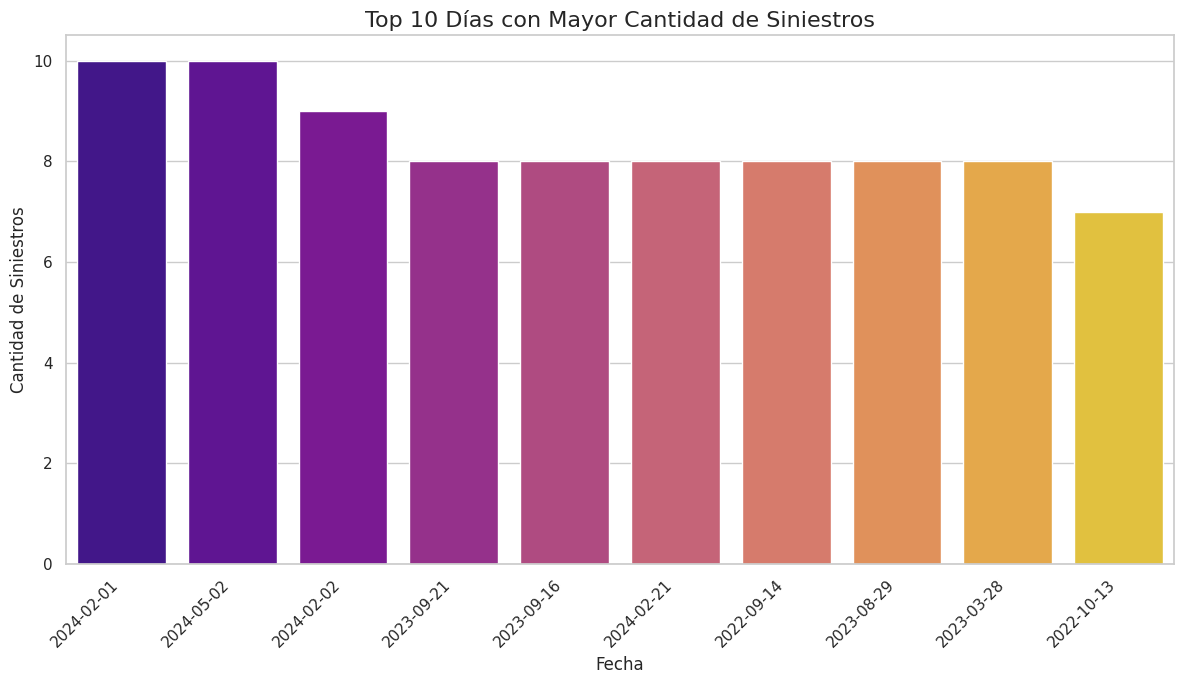


Top 10 Días con más siniestros:
  Cantidad  count
2024-02-01     10
2024-05-02     10
2024-02-02      9
2023-09-21      8
2023-09-16      8
2024-02-21      8
2022-09-14      8
2023-08-29      8
2023-03-28      8
2022-10-13      7


In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# --- 1. Crear la columna de fecha completa (si no existe ya) ---
# Asegurarnos de que las columnas de fecha son del tipo correcto
df_filtrado['AÑO'] = df_filtrado['AÑO'].astype(int)
df_filtrado['MES'] = df_filtrado['MES'].astype(int)
df_filtrado['DIA'] = df_filtrado['DIA'].astype(int)

# Crear la columna 'FECHA_COMPLETA' de tipo datetime
# Usamos 'coerce' para manejar posibles errores si alguna combinación de fecha no es válida
df_filtrado['FECHA_COMPLETA'] = pd.to_datetime(df_filtrado[['AÑO', 'MES', 'DIA']].rename(columns={'AÑO': 'year', 'MES': 'month', 'DIA': 'day'}), errors='coerce')

# Eliminar filas donde la fecha no se pudo crear (si las hubiera)
df_filtrado.dropna(subset=['FECHA_COMPLETA'], inplace=True)

# --- 2. Contar siniestros por fecha ---
siniestros_por_dia = df_filtrado['FECHA_COMPLETA'].value_counts()

# --- 3. Seleccionar los 10 días con más siniestros ---
top_10_dias = siniestros_por_dia.head(10)

# --- 4. Crear el gráfico de barras ---
plt.figure(figsize=(12, 7))
# Convertimos el índice (fechas) a string para una mejor visualización en el eje X
sns.barplot(x=top_10_dias.index.strftime('%Y-%m-%d'), y=top_10_dias.values, palette='plasma')

# Añadir títulos y etiquetas
plt.title('Top 10 Días con Mayor Cantidad de Siniestros', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de Siniestros', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# --- 5. Mostrar la tabla con los valores exactos ---
print("\nTop 10 Días con más siniestros:")
# Formateamos el índice para mostrar solo la fecha
print(top_10_dias.reset_index().rename(columns={'index': 'Fecha', 'FECHA_COMPLETA': 'Cantidad'}).to_string(index=False))

####Lesionados/Fallecidos x Dia de la semana

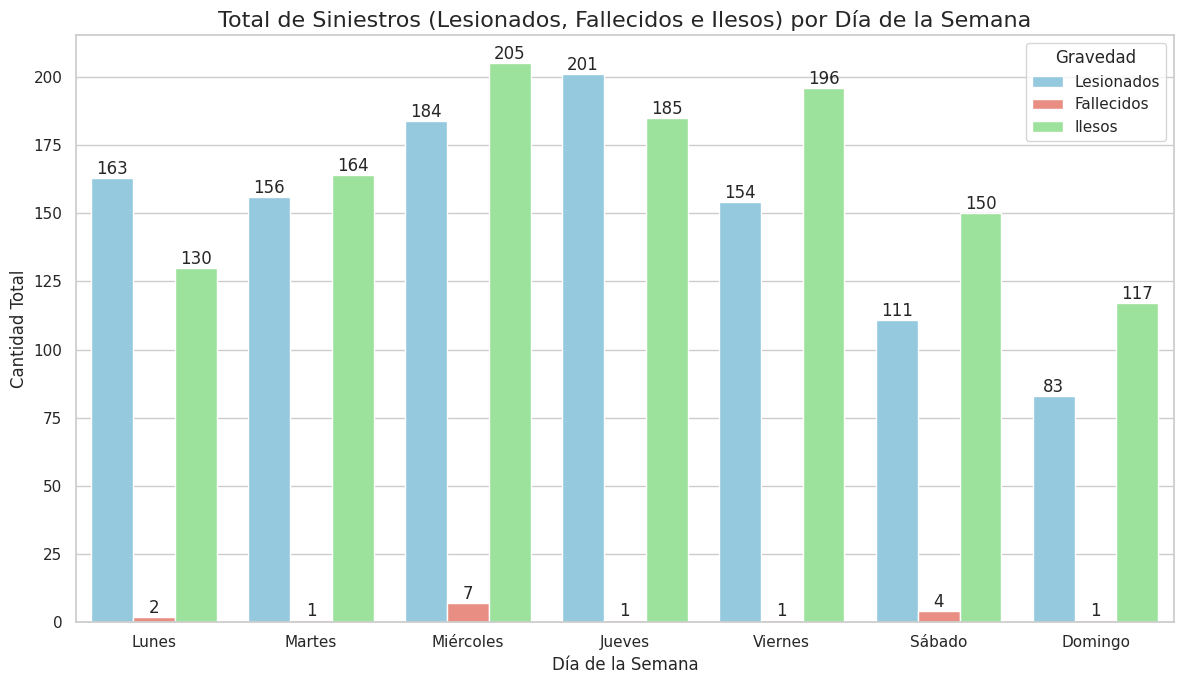


Total de Siniestros (Lesionados, Fallecidos e Ilesos) por Día de la Semana:
   DIASEMANA  total_lesionados  total_fallecidos  total_siniestros  \
0      Lunes               163                 2               295   
1     Martes               156                 1               321   
2  Miércoles               184                 7               396   
3     Jueves               201                 1               387   
4    Viernes               154                 1               351   
5     Sábado               111                 4               265   
6    Domingo                83                 1               201   

   total_ilesos  
0           130  
1           164  
2           205  
3           185  
4           196  
5           150  
6           117  


In [ ]:
import seaborn as sns
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Agrupar por día de la semana y sumar lesionados y fallecidos
gravedad_por_diasemana = df_filtrado.groupby('DIASEMANA').agg(
    total_lesionados=('LESIONADOS', 'sum'),
    total_fallecidos=('FALLECIDOS', 'sum'),
    total_siniestros=('DIASEMANA', 'count') # Agregar el conteo total de siniestros por día
)

# Calcular siniestros "ilesos" (sin lesionados ni fallecidos)
gravedad_por_diasemana['total_ilesos'] = gravedad_por_diasemana['total_siniestros'] - gravedad_por_diasemana['total_lesionados'] - gravedad_por_diasemana['total_fallecidos']


# Reordenar los días de la semana para el gráfico
dias_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
gravedad_por_diasemana = gravedad_por_diasemana.reindex(dias_ordenados)

# Resetear el índice para que DIASEMANA sea una columna
gravedad_por_diasemana = gravedad_por_diasemana.reset_index()

# "Derretir" el DataFrame para tener una columna para el tipo de gravedad (Lesionados/Fallecidos/Ilesos)
gravedad_melted = gravedad_por_diasemana.melt(id_vars='DIASEMANA', var_name='Tipo_Gravedad', value_name='Total', value_vars=['total_lesionados', 'total_fallecidos', 'total_ilesos'])

# Mapear nombres de columnas a etiquetas más amigables para el gráfico
gravedad_melted['Tipo_Gravedad'] = gravedad_melted['Tipo_Gravedad'].map({
    'total_lesionados': 'Lesionados',
    'total_fallecidos': 'Fallecidos',
    'total_ilesos': 'Ilesos' # Agregar la etiqueta para ilesos
})


# Crear el gráfico de barras agrupadas
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=gravedad_melted, x='DIASEMANA', y='Total', hue='Tipo_Gravedad', palette={'Lesionados': 'skyblue', 'Fallecidos': 'salmon', 'Ilesos': 'lightgreen'}) # Agregar color para ilesos

# Añadir títulos y etiquetas
plt.title('Total de Siniestros (Lesionados, Fallecidos e Ilesos) por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Cantidad Total', fontsize=12)
plt.xticks(rotation=0) # No necesitamos rotar si los nombres de los días encajan
plt.legend(title='Gravedad')
plt.tight_layout() # Ajusta el gráfico para que todo encaje bien

# Add values at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

# Mostrar el gráfico
plt.show()

# Mostrar la tabla con los valores exactos
print("\nTotal de Siniestros (Lesionados, Fallecidos e Ilesos) por Día de la Semana:")
print(gravedad_por_diasemana)

#### Detalle de cada dia

In [ ]:
# --- Asegurarnos de tener las variables necesarias del paso anterior ---

# --- Iterar y analizar cada uno de los top 10 días ---
print("--- Análisis Detallado de los Top 10 Días con Más Siniestros ---")

for fecha, cantidad in top_10_dias.items():
    fecha_str = fecha.strftime('%Y-%m-%d')
    print(f"\n=========================================================")
    print(f"Fecha: {fecha_str} - Total Siniestros: {cantidad}")
    print(f"=========================================================")

    # Filtrar el DataFrame para obtener solo los datos de esa fecha
    df_dia_especifico = df_filtrado[df_filtrado['FECHA_COMPLETA'] == fecha]

    # Análisis para ese día
    print("\n--- Distribución por Hora ---")
    print(df_dia_especifico['HORA'].value_counts().sort_index())

    print("\n--- Autopistas Afectadas ---")
    print(df_dia_especifico['AUTOPISTA'].value_counts())

    print("\n--- Tipos de Siniestro ---")
    print(df_dia_especifico['TIPO_DE_SINIESTRO'].value_counts())

    print("\n--- Gravedad ---")
    lesionados_dia = df_dia_especifico['LESIONADOS'].sum()
    fallecidos_dia = df_dia_especifico['FALLECIDOS'].sum()
    print(f"Total Lesionados: {lesionados_dia}")
    print(f"Total Fallecidos: {fallecidos_dia}")

    print("\n--- Condiciones ---")
    print("Meteorológicas:")
    print(df_dia_especifico['CONDICIONES_METEOROLOGICAS'].value_counts())
    print("Superficie:")
    print(df_dia_especifico['SUPERFICIE_DE_LA_VIA'].value_counts())

    print("\n--- Dirección (Banda/Ramal) ---")
    print(df_dia_especifico['BANDA_o_RAMAL'].value_counts())
    print(f"---------------------------------------------------------")

--- Análisis Detallado de los Top 10 Días con Más Siniestros ---

Fecha: 2024-02-01 - Total Siniestros: 10

--- Distribución por Hora ---
HORA
1     1
8     1
9     3
12    1
15    1
18    2
19    1
Name: count, dtype: int64

--- Autopistas Afectadas ---
AUTOPISTA
AU 25 DE MAYO       4
AU PERITO MORENO    3
AU DELLEPIANE       1
AU FRONDIZI         1
PASEO DEL BAJO      1
Name: count, dtype: int64

--- Tipos de Siniestro ---
TIPO_DE_SINIESTRO
COLISION CON DOS O MAS VEHICULOS    7
OBSTACULO NO FIJO                   2
COLISION CON OBSTACULO FIJO         1
Name: count, dtype: int64

--- Gravedad ---
Total Lesionados: 2
Total Fallecidos: 0

--- Condiciones ---
Meteorológicas:
CONDICIONES_METEOROLOGICAS
BUENO    10
Name: count, dtype: int64
Superficie:
SUPERFICIE_DE_LA_VIA
SECA    10
Name: count, dtype: int64

--- Dirección (Banda/Ramal) ---
BANDA_o_RAMAL
DESCENDENTE    5
ASCENDENTE     5
Name: count, dtype: int64
---------------------------------------------------------

Fecha: 2024-05-02

--- Generando Gráficos Detallados para los Top 10 Días ---


/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

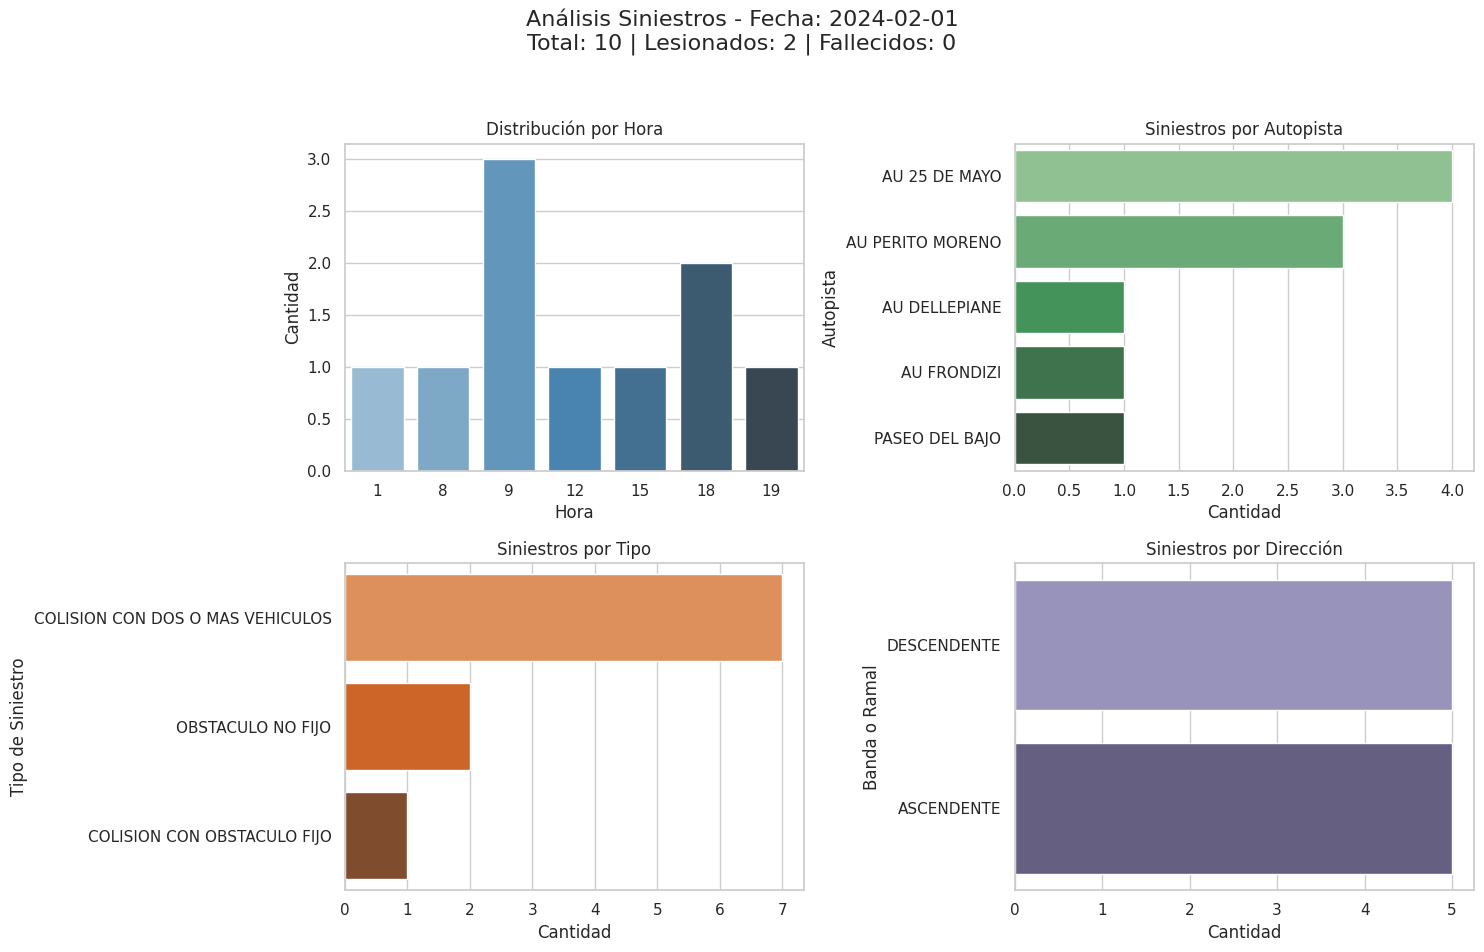

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

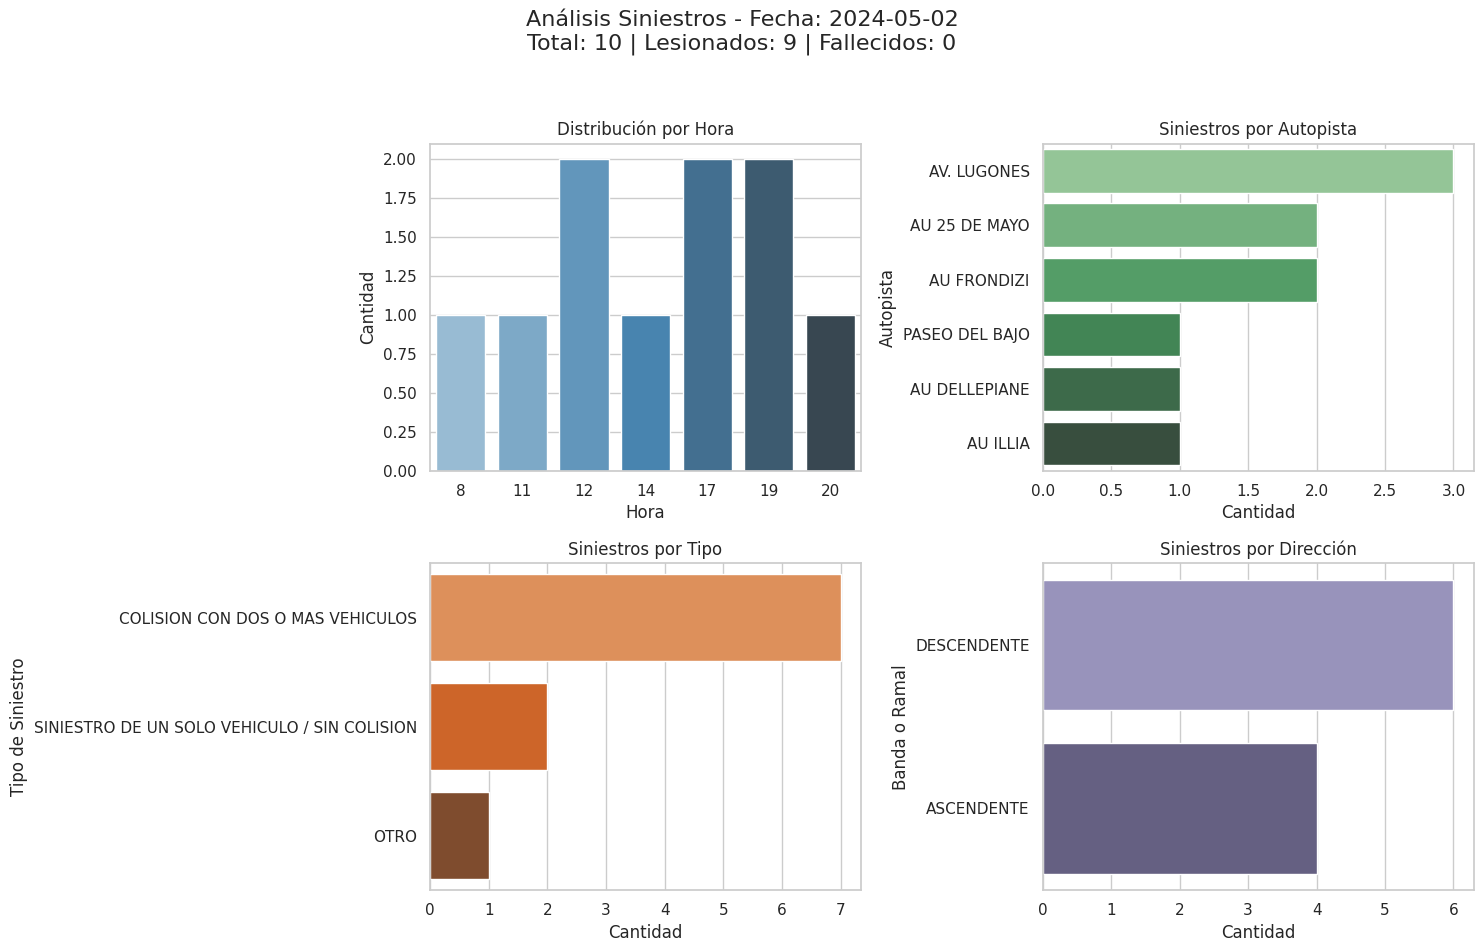

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

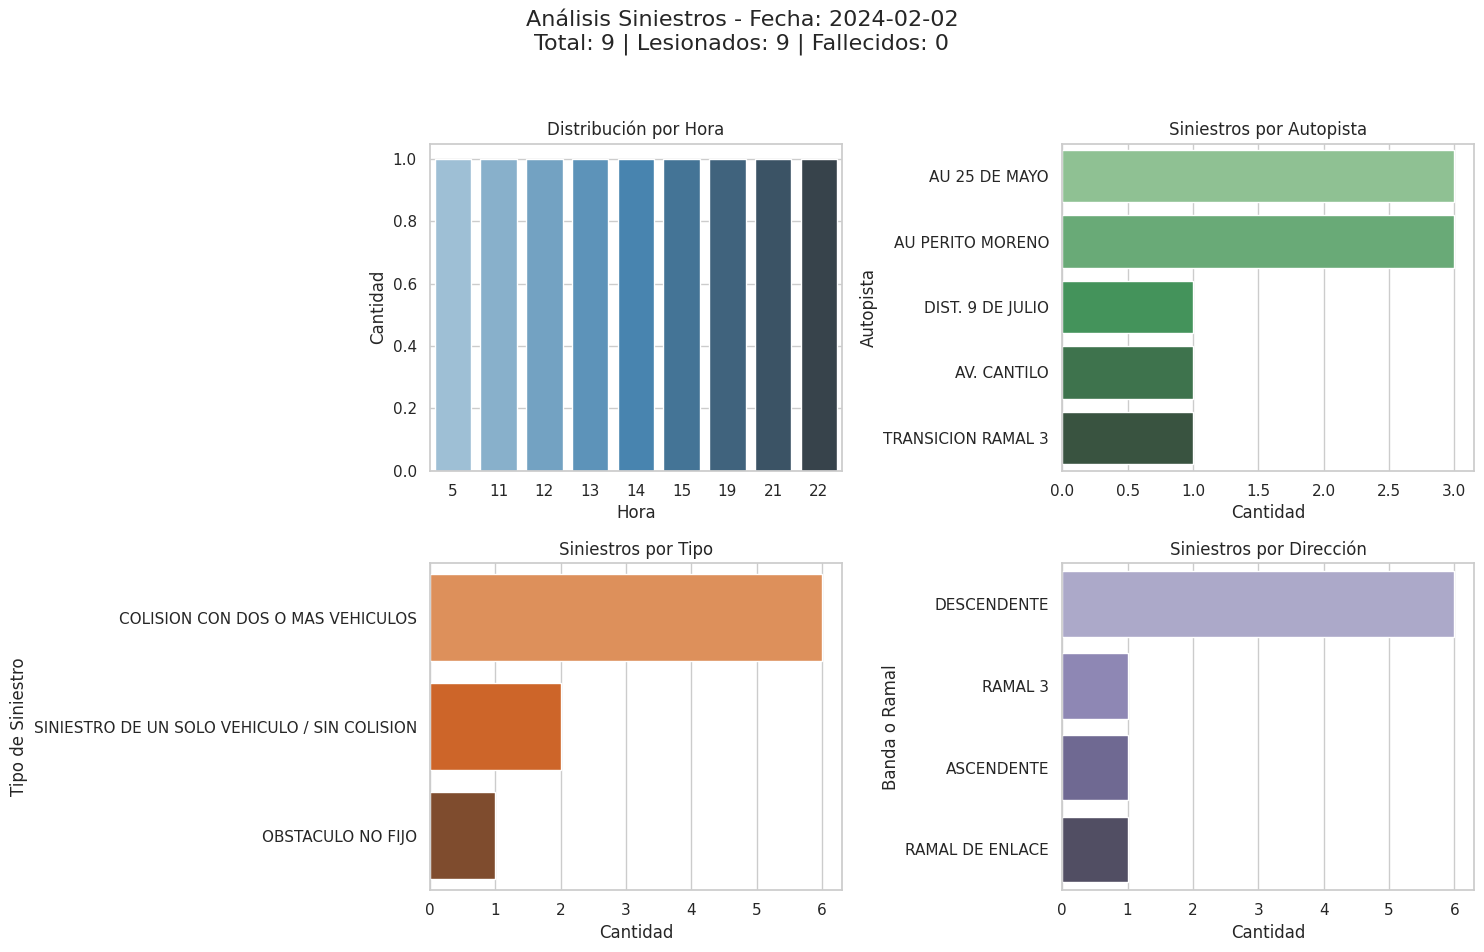

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

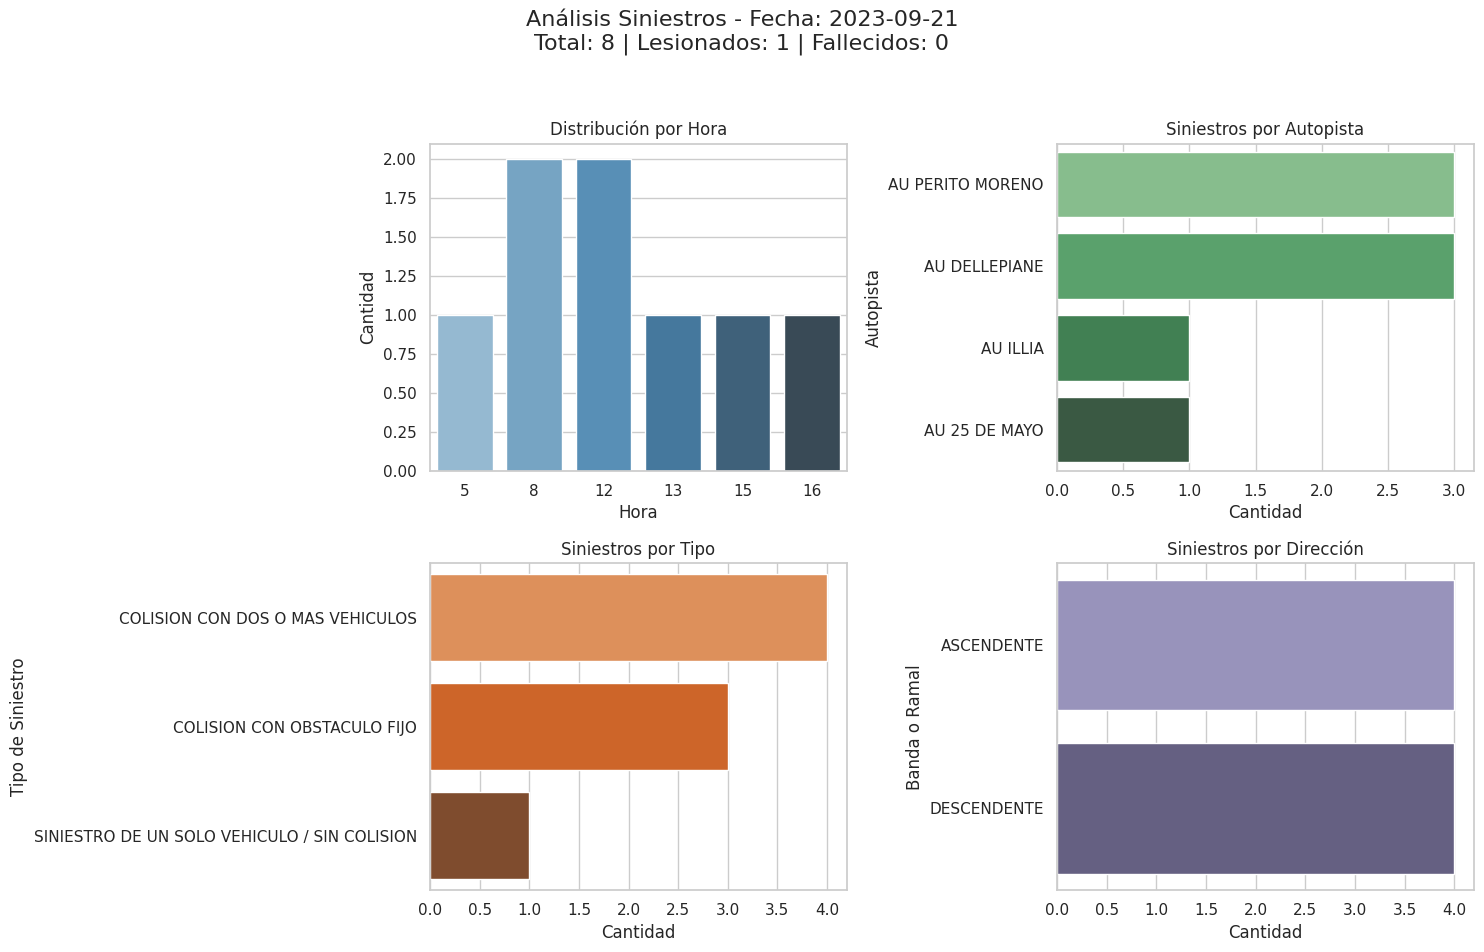

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

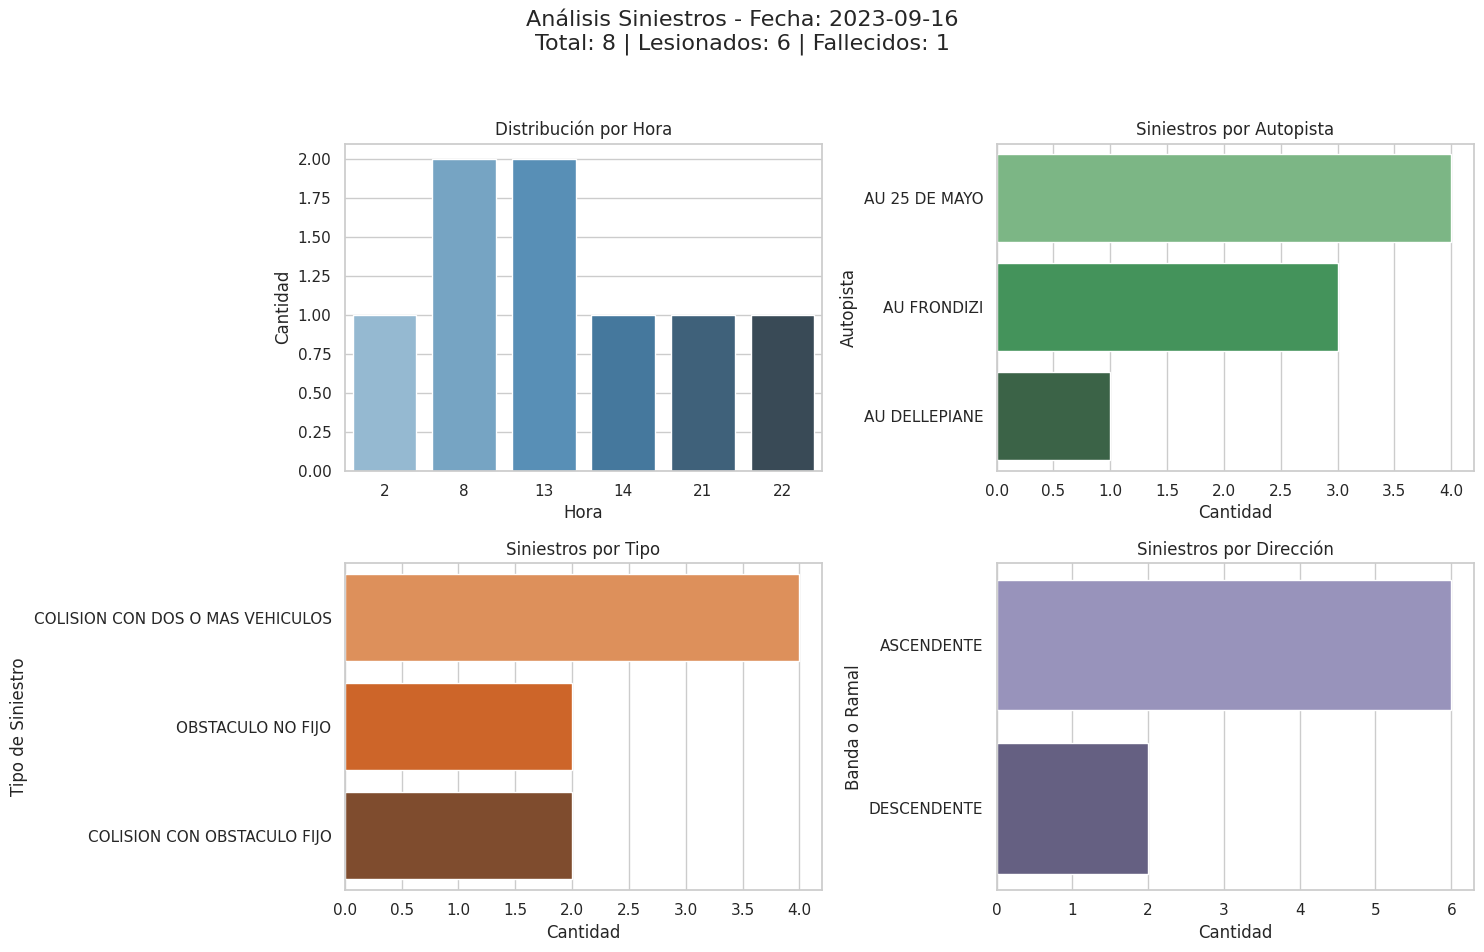

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

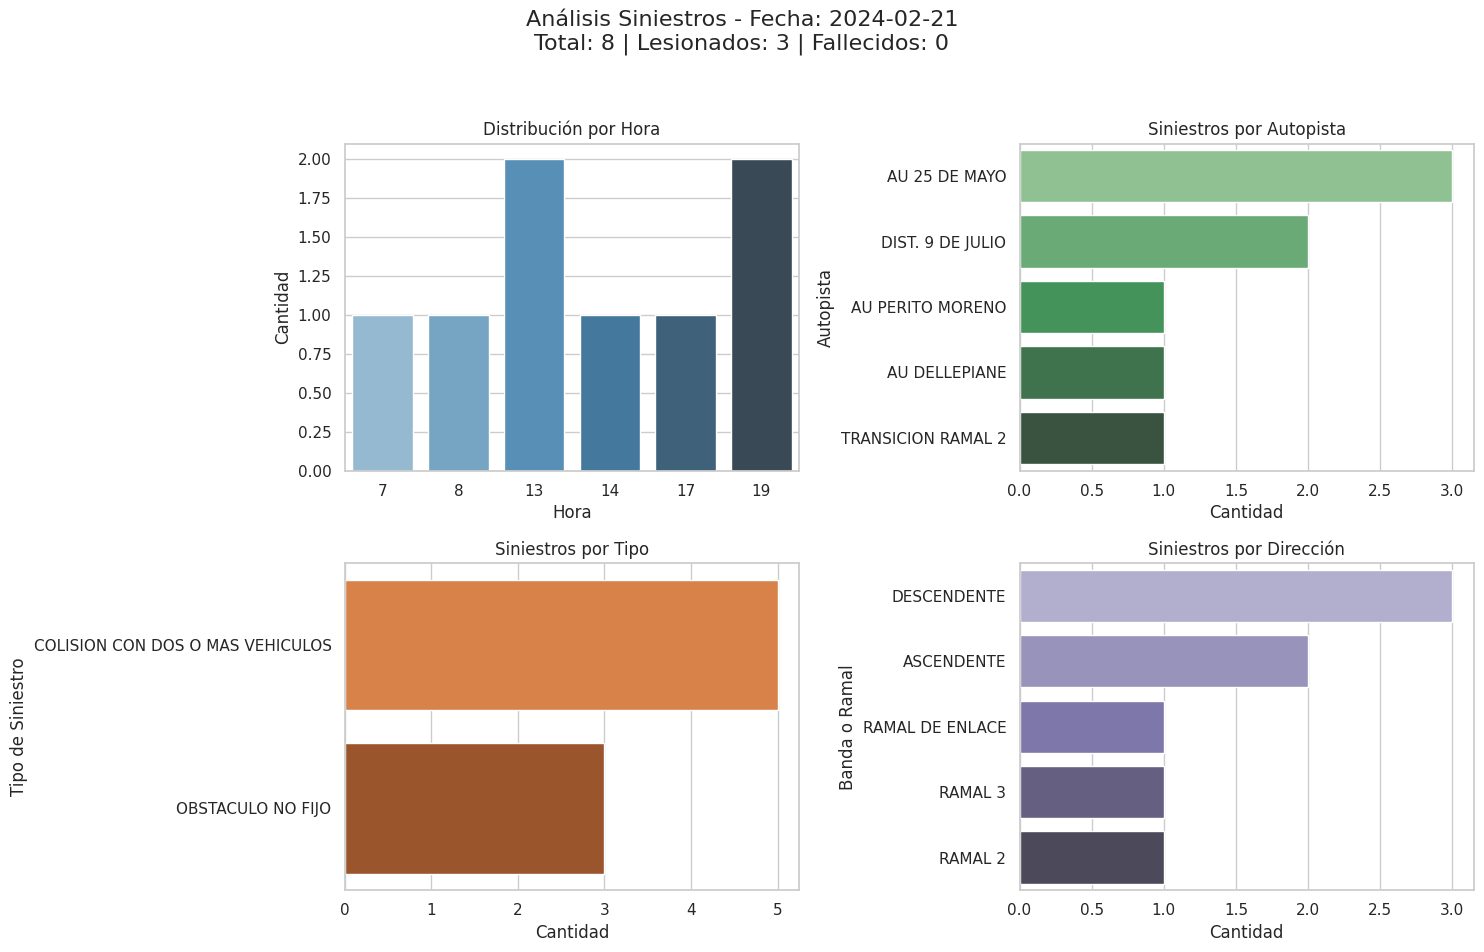

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

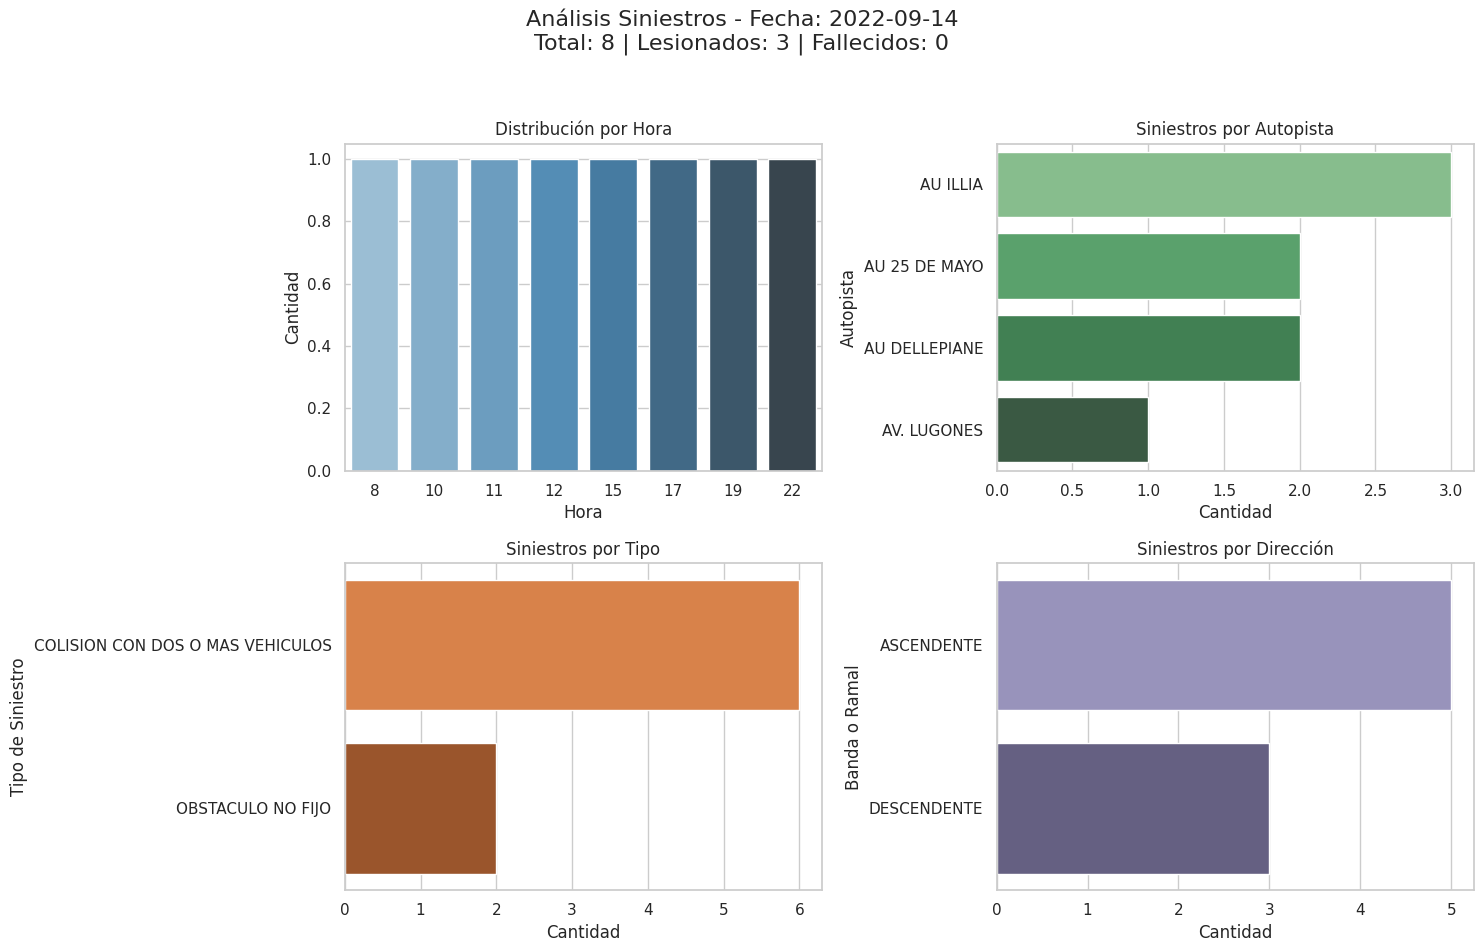

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

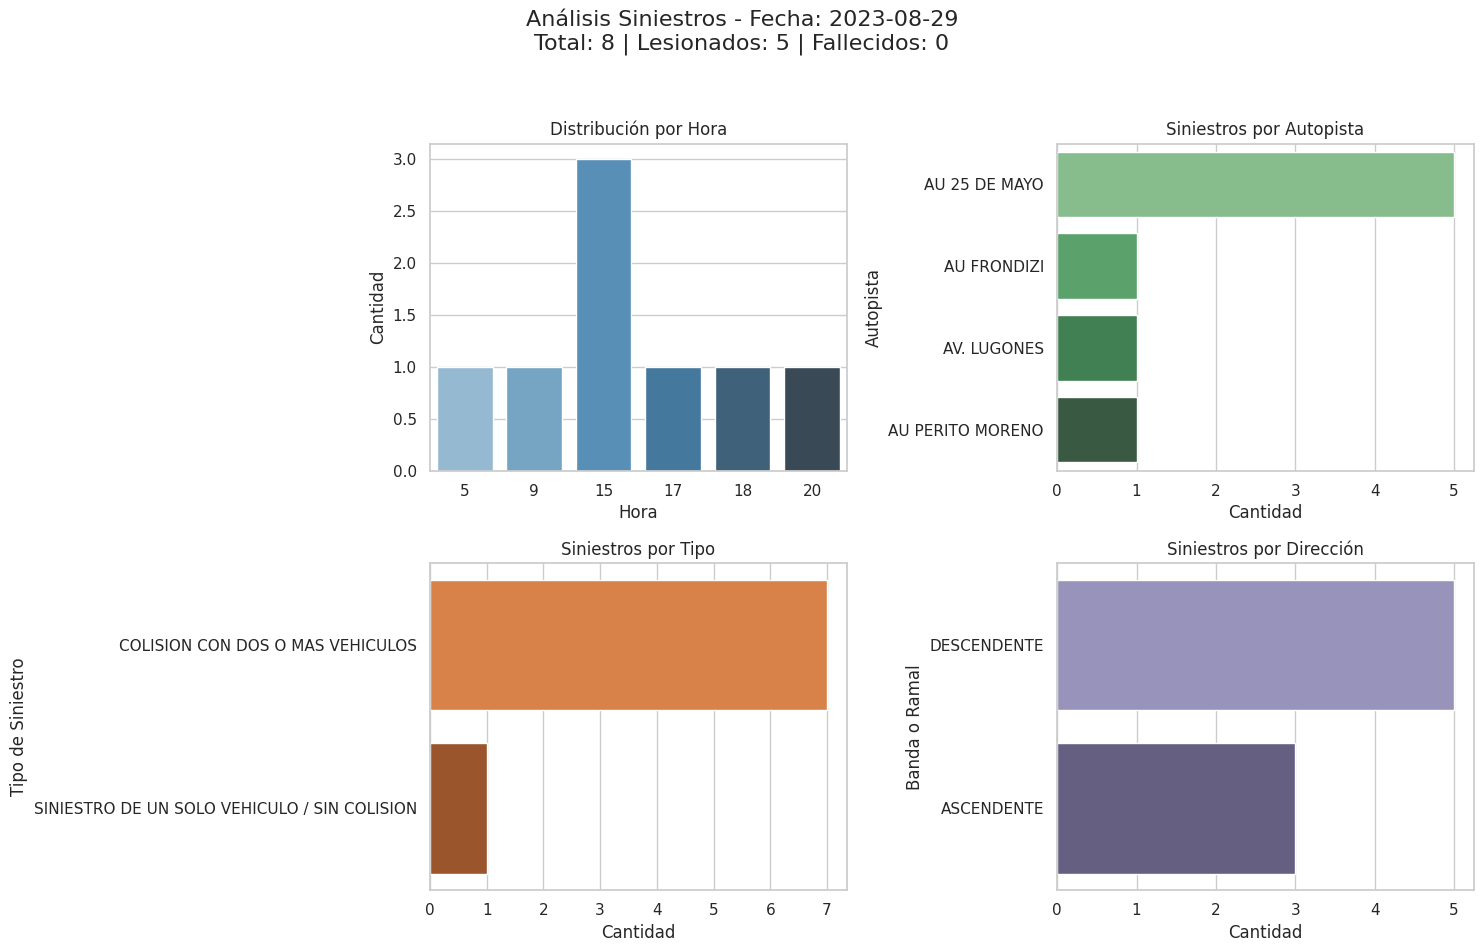

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

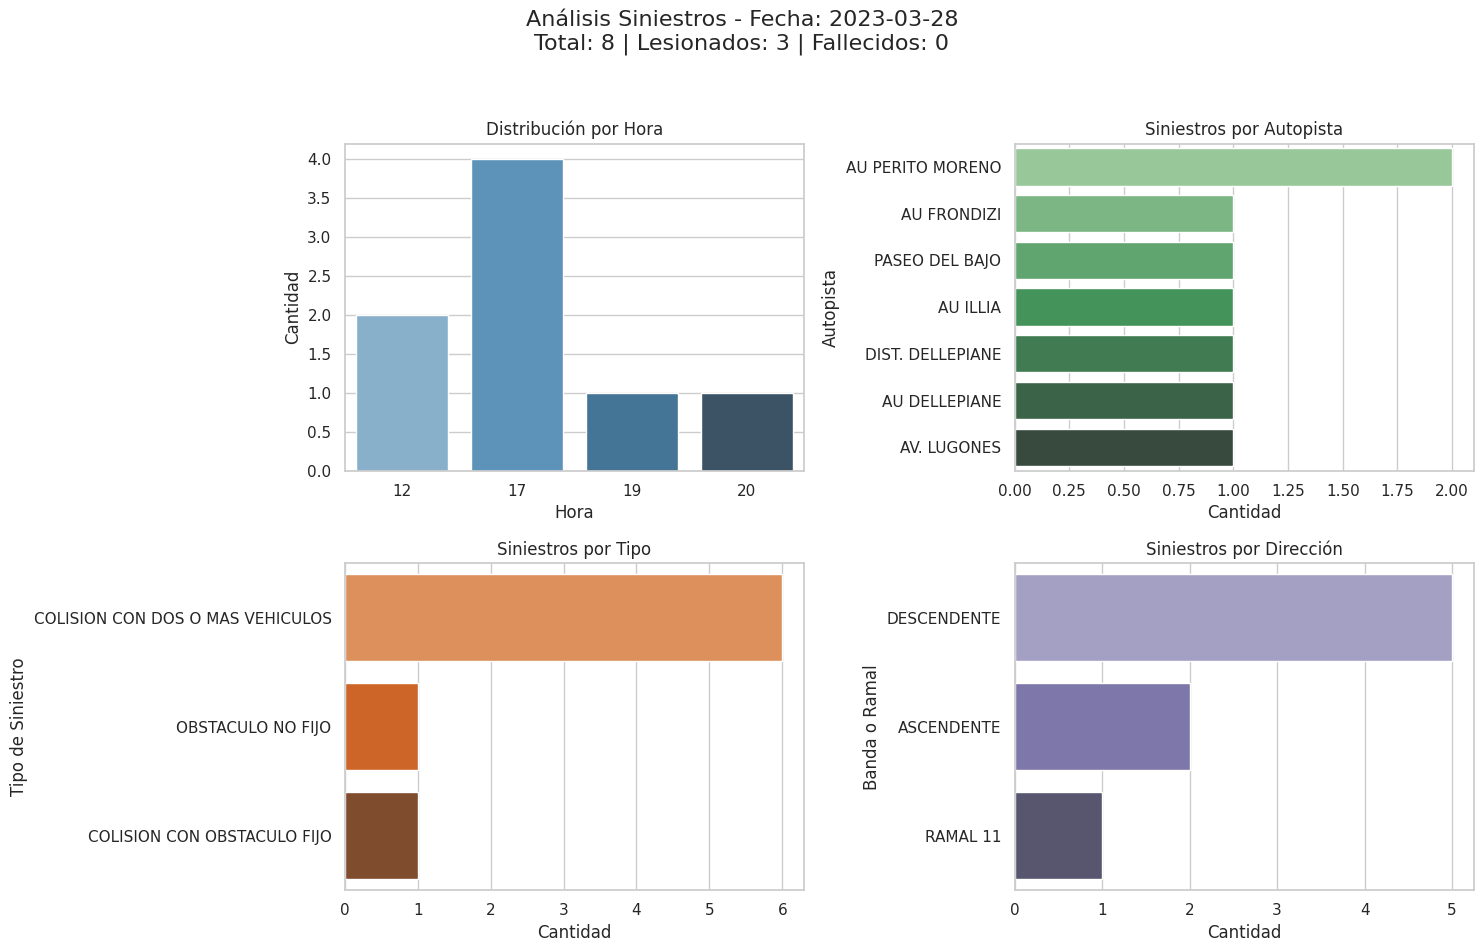

/tmp/ipython-input-3001249631.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-3001249631.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
/tmp/ipython-input-3001249631.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df

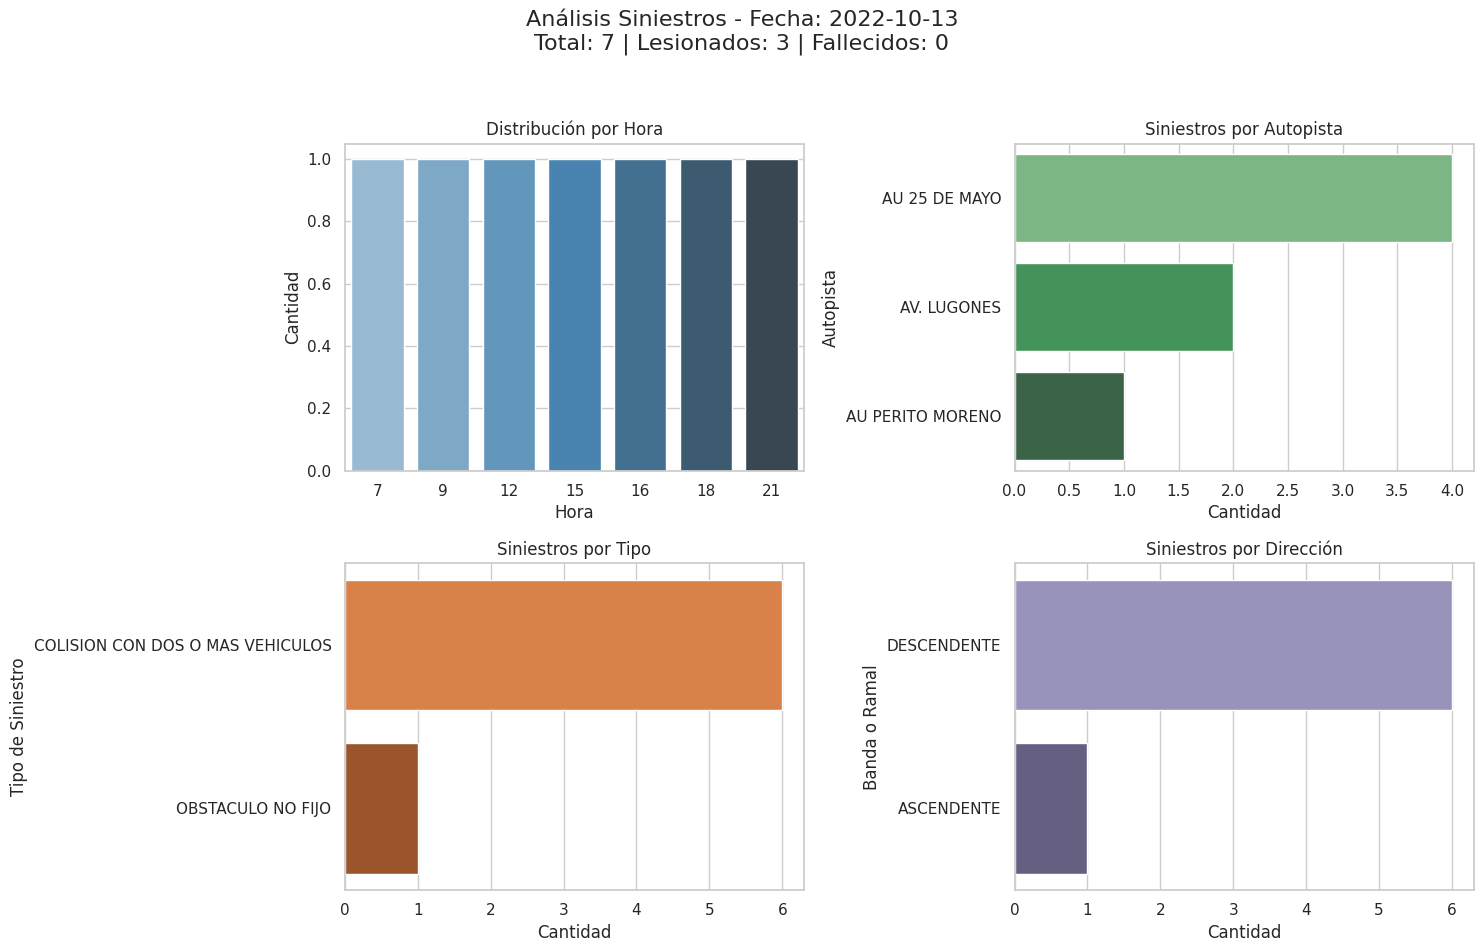


--- Fin de la generación de gráficos ---


In [ ]:
# --- Configuración de estilo ---
sns.set_style("whitegrid")

# --- Iterar y Graficar cada uno de los top 10 días ---
print("--- Generando Gráficos Detallados para los Top 10 Días ---")

for fecha, cantidad in top_10_dias.items():
    fecha_str = fecha.strftime('%Y-%m-%d')
    df_dia_especifico = df_filtrado[df_filtrado['FECHA_COMPLETA'] == fecha].copy() #copia por las deudas

    # Calcular totales de gravedad
    lesionados_dia = df_dia_especifico['LESIONADOS'].sum()
    fallecidos_dia = df_dia_especifico['FALLECIDOS'].sum()

    # Crear figura con 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Análisis Siniestros - Fecha: {fecha_str}\n"
                 f"Total: {cantidad} | Lesionados: {lesionados_dia} | Fallecidos: {fallecidos_dia}",
                 fontsize=16)

    # 1. Distribución por Hora
    sns.countplot(data=df_dia_especifico, x='HORA', ax=axes[0, 0], palette='Blues_d')
    axes[0, 0].set_title('Distribución por Hora')
    axes[0, 0].set_xlabel('Hora')
    axes[0, 0].set_ylabel('Cantidad')
    # Ajustar ticks del eje x si hay muchas horas
    if df_dia_especifico['HORA'].nunique() > 10:
         max_hour = df_dia_especifico['HORA'].max()
         step = max(1, int(np.ceil(max_hour / 10))) # Mostrar ~10 ticks
         axes[0, 0].set_xticks(range(0, max_hour + 1, step))


    # 2. Siniestros por Autopista
    sns.countplot(data=df_dia_especifico, y='AUTOPISTA', ax=axes[0, 1], palette='Greens_d', order=df_dia_especifico['AUTOPISTA'].value_counts().index)
    axes[0, 1].set_title('Siniestros por Autopista')
    axes[0, 1].set_xlabel('Cantidad')
    axes[0, 1].set_ylabel('Autopista')

    # 3. Siniestros por Tipo
    sns.countplot(data=df_dia_especifico, y='TIPO_DE_SINIESTRO', ax=axes[1, 0], palette='Oranges_d', order=df_dia_especifico['TIPO_DE_SINIESTRO'].value_counts().index)
    axes[1, 0].set_title('Siniestros por Tipo')
    axes[1, 0].set_xlabel('Cantidad')
    axes[1, 0].set_ylabel('Tipo de Siniestro')

    # 4. Siniestros por Dirección (Banda/Ramal)
    sns.countplot(data=df_dia_especifico, y='BANDA_o_RAMAL', ax=axes[1, 1], palette='Purples_d', order=df_dia_especifico['BANDA_o_RAMAL'].value_counts().index)
    axes[1, 1].set_title('Siniestros por Dirección')
    axes[1, 1].set_xlabel('Cantidad')
    axes[1, 1].set_ylabel('Banda o Ramal')

    # Ajustar layout y mostrar
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para dejar espacio al supertítulo
    plt.show()

print("\n--- Fin de la generación de gráficos ---")

## Entrenamiento y creacion de tablas o columnas temporales para Machine Learning

---

### Predecir grave y/o lev

DataFrame 'df_ausa' ya existe. Omitiendo la carga.

--- Balance de Clases para 'GRAVEDAD' ---
0 = Leve
1 = Grave

Conteo Absoluto:
GRAVEDAD
0    1388
1     828
Name: count, dtype: int64

Porcentaje:
GRAVEDAD
0    62.635379
1    37.364621
Name: proportion, dtype: float64


/tmp/ipython-input-1074628312.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GRAVEDAD', data=df_ausa, palette='pastel')


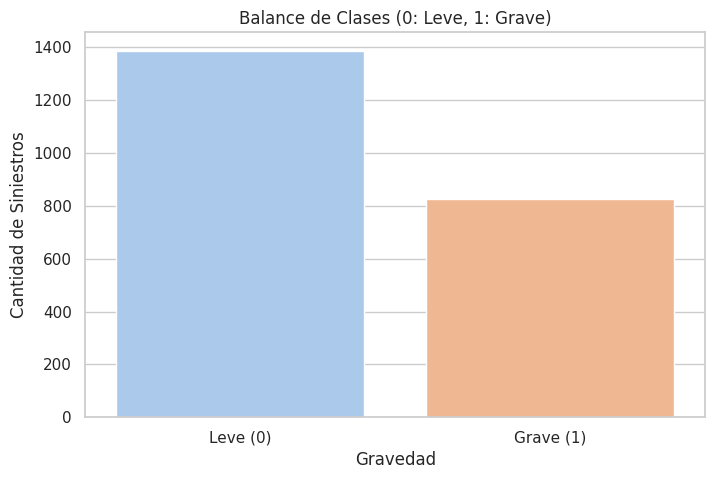

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Carga de Datos ---
# (Asegurándonos de que df_ausa esté cargado como en el bloque anterior)
try:
    df_ausa
    print("DataFrame 'df_ausa' ya existe. Omitiendo la carga.")
except NameError:
    print("Cargando DataFrame 'df_ausa' desde el archivo...")
    file_name = 'df_ausa (2).csv'
    try:
        df_ausa = pd.read_csv(file_name, sep=';')
        print("Carga exitosa.")
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {file_name}. Asegúrate de que esté en el directorio correcto.")
        # Detener la ejecución si el archivo no se carga
        raise

# --- Creación de la Variable Objetivo 'GRAVEDAD' ---

# Rellenar NaNs con 0 en columnas de gravedad (buena práctica antes de operaciones)
df_ausa['LESIONADOS'] = df_ausa['LESIONADOS'].fillna(0)
df_ausa['FALLECIDOS'] = df_ausa['FALLECIDOS'].fillna(0)

# 1 = Grave (hubo lesionados O fallecidos)
# 0 = Leve (no hubo ni lesionados NI fallecidos)
df_ausa['GRAVEDAD'] = ((df_ausa['FALLECIDOS'] > 0) | (df_ausa['LESIONADOS'] > 0)).astype(int)

# --- Verificar Balance de Clases ---
print("\n--- Balance de Clases para 'GRAVEDAD' ---")
print("0 = Leve")
print("1 = Grave")

# Mostramos los conteos y el porcentaje
class_balance_abs = df_ausa['GRAVEDAD'].value_counts()
class_balance_pct = df_ausa['GRAVEDAD'].value_counts(normalize=True) * 100

print("\nConteo Absoluto:")
print(class_balance_abs)
print("\nPorcentaje:")
print(class_balance_pct)

# Visualizar el balance
plt.figure(figsize=(8, 5))
sns.countplot(x='GRAVEDAD', data=df_ausa, palette='pastel')
plt.title('Balance de Clases (0: Leve, 1: Grave)')
plt.xlabel('Gravedad')
plt.ylabel('Cantidad de Siniestros')
plt.xticks([0, 1], ['Leve (0)', 'Grave (1)'])
plt.savefig('balance_de_clases.png')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# --- 1. Definir Features (X) y Target (y) ---

# Seleccionamos las columnas categóricas que usaremos
features_categoricas = [
    'AUTOPISTA',
    'BANDA_o_RAMAL',
    'CONDICIONES_METEOROLOGICAS',
    'SUPERFICIE_DE_LA_VIA',
    'TIPO_DE_SINIESTRO',
    'DIASEMANA'
]

# Seleccionamos las columnas numéricas
features_numericas = [
    'PK',
    'MOTO',
    'LIVIANO',
    'BUS',
    'CAMION',
    'AÑO',
    'MES',
    'DIA',
    'HORA'
]

# Combinamos la lista de features
features_finales = features_categoricas + features_numericas

# Creamos X (features)
X = df_ausa[features_finales]

# Creamos y (target)
y = df_ausa['GRAVEDAD']

# --- 2. Separar en Entrenamiento (train) y Prueba (test) ---

# Usamos test_size=0.2 (20% para prueba) y random_state=42 (para reproducibilidad)
# ¡Crucial usar stratify=y para mantener el balance de clases!
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- 3. Verificar los resultados ---
print("--- Formas de los sets de datos ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\n--- Verificación de Estratificación (Balance en y_train) ---")
print(y_train.value_counts(normalize=True) * 100)

print("\n--- Verificación de Estratificación (Balance en y_test) ---")
print(y_test.value_counts(normalize=True) * 100)

--- Formas de los sets de datos ---
X_train shape: (1772, 15)
X_test shape: (444, 15)
y_train shape: (1772,)
y_test shape: (444,)

--- Verificación de Estratificación (Balance en y_train) ---
GRAVEDAD
0    62.641084
1    37.358916
Name: proportion, dtype: float64

--- Verificación de Estratificación (Balance en y_test) ---
GRAVEDAD
0    62.612613
1    37.387387
Name: proportion, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. Verificar NaNs en X_train ---
# (Esto nos confirma si los imputers son necesarios)
print("--- Verificando NaNs en X_train (features numéricas) ---")
print(X_train[features_numericas].isnull().sum())

print("\n--- Verificando NaNs en X_train (features categóricas) ---")
print(X_train[features_categoricas].isnull().sum())
# Nota: Si el script original limpió todo, veremos 0 NaNs.
# AUN ASÍ, incluiremos imputers en el pipeline por robustez
# (es una buena práctica).

# --- 2. Definir el Pipeline Numérico ---
# Pasos:
# 1. Imputar NaNs (usando la mediana, que es robusta a outliers)
# 2. Escalar los datos (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- 3. Definir el Pipeline Categórico ---
# Pasos:
# 1. Imputar NaNs (usando el valor más frecuente)
# 2. Codificar con OneHotEncoder (crea columnas dummy)
#    handle_unknown='ignore' evita errores si una categoría rara aparece en el test set
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- 4. Combinar con ColumnTransformer ---
# Aplicamos los transformadores a las listas de columnas que definimos antes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numericas),
        ('cat', categorical_transformer, features_categoricas)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (aunque aquí usamos todas)
)

# --- 5. Mostrar el Pipeline de Preprocesamiento ---
# (Este objeto 'preprocessor' está listo para ser enchufado
# a un modelo)
print("\n--- Pipeline de Preprocesamiento Creado ---")
print(preprocessor)

--- Verificando NaNs en X_train (features numéricas) ---
PK         0
MOTO       0
LIVIANO    0
BUS        0
CAMION     0
AÑO        0
MES        0
DIA        0
HORA       0
dtype: int64

--- Verificando NaNs en X_train (features categóricas) ---
AUTOPISTA                     0
BANDA_o_RAMAL                 0
CONDICIONES_METEOROLOGICAS    0
SUPERFICIE_DE_LA_VIA          0
TIPO_DE_SINIESTRO             0
DIASEMANA                     0
dtype: int64

--- Pipeline de Preprocesamiento Creado ---
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['PK', 'MOTO', 'LIVIANO', 'BUS', 'CAMION',
                                  'AÑO', 'MES', 'DIA', 'HORA']),
                                ('cat',
            

--- Entrenando el Pipeline (Random Forest con class_weight='balanced') ---
--- ¡Entrenamiento Completo! ---

--- Evaluación en el set de PRUEBA (Test set) ---

--- Reporte de Clasificación (Random Forest) ---
              precision    recall  f1-score   support

    Leve (0)       0.80      0.84      0.82       278
   Grave (1)       0.71      0.64      0.68       166

    accuracy                           0.77       444
   macro avg       0.75      0.74      0.75       444
weighted avg       0.76      0.77      0.77       444


--- Generando Matriz de Confusión... ---


<Figure size 800x600 with 0 Axes>

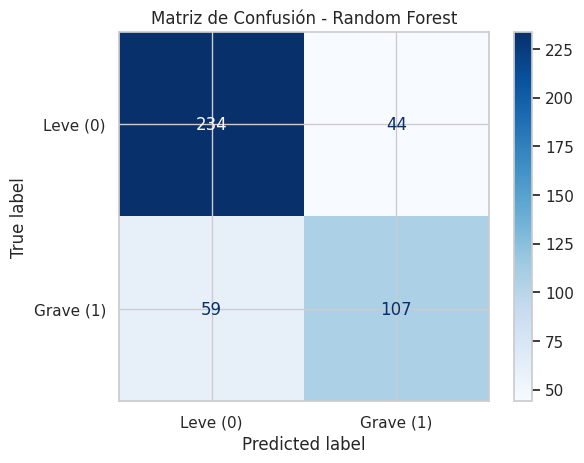

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# --- 1. Crear el Pipeline Completo (Preprocesador + Modelo) ---

# Instanciamos el modelo
# ¡class_weight='balanced' es la clave para priorizar la clase minoritaria (Grave)!
modelo_rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

# Creamos el pipeline final
full_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),  # El preprocesador del Bloque 3
    ('classifier', modelo_rf)       # El clasificador
])

# --- 2. Entrenar el Modelo ---
print("--- Entrenando el Pipeline (Random Forest con class_weight='balanced') ---")
full_pipeline_rf.fit(X_train, y_train)
print("--- ¡Entrenamiento Completo! ---")


# --- 3. Evaluación del Modelo ---
print("\n--- Evaluación en el set de PRUEBA (Test set) ---")

# Predecir sobre los datos de X_test
y_pred_rf = full_pipeline_rf.predict(X_test)

# --- 4. Reporte de Clasificación ---
# Aquí veremos el RECALL (exhaustividad) que tanto nos importa
print("\n--- Reporte de Clasificación (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=['Leve (0)', 'Grave (1)']))


# --- 5. Matriz de Confusión ---
# Visualizamos los errores:
# Queremos que la celda [1, 0] (Falsos Negativos) sea lo más baja posible.
print("\n--- Generando Matriz de Confusión... ---")

cm = confusion_matrix(y_test, y_pred_rf)

# Etiquetas para la matriz
labels = ['Predicho Leve', 'Predicho Grave']
true_labels = ['Real Leve', 'Real Grave']

# Graficar la matriz
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Leve (0)', 'Grave (1)']
)
disp.plot(cmap='Blues', values_format='d') # 'd' para formato de número entero
plt.title('Matriz de Confusión - Random Forest')
plt.savefig('matriz_confusion_rf.png')
plt.show()

--- Usando scale_pos_weight para XGBoost: 1.68 ---
(Esto significa que la clase 'Grave' pesará 1.68 veces más)

--- Entrenando el Pipeline (XGBoost) ---
--- ¡Entrenamiento Completo! ---

--- Evaluación en el set de PRUEBA (Test set) ---

--- Reporte de Clasificación (XGBoost) ---
              precision    recall  f1-score   support

    Leve (0)       0.79      0.80      0.80       278
   Grave (1)       0.66      0.65      0.65       166

    accuracy                           0.74       444
   macro avg       0.73      0.72      0.73       444
weighted avg       0.74      0.74      0.74       444


--- Generando Matriz de Confusión (XGBoost)... ---


<Figure size 800x600 with 0 Axes>

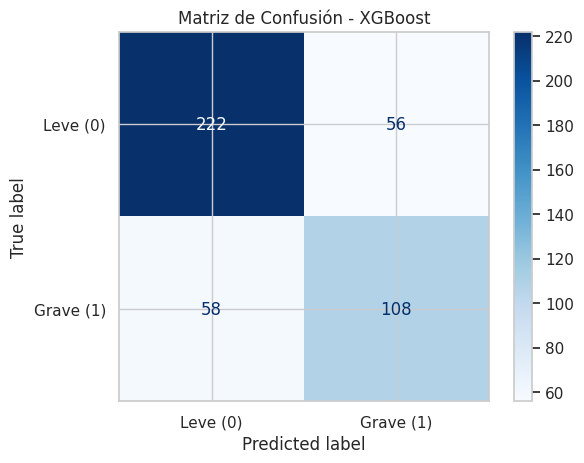

In [ ]:
import xgboost as xgb # Necesitarás tener instalado xgboost (en Colab ya viene)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Calcular el 'scale_pos_weight' para XGBoost ---
# Esto le dice a XGBoost cuánto más importante es la clase 'Grave' (1)
# que la clase 'Leve' (0).
# Usamos los conteos de y_train
conteo_leves = y_train.value_counts()[0]
conteo_graves = y_train.value_counts()[1]
scale_pos_weight = conteo_leves / conteo_graves

print(f"--- Usando scale_pos_weight para XGBoost: {scale_pos_weight:.2f} ---")
print(f"(Esto significa que la clase 'Grave' pesará {scale_pos_weight:.2f} veces más)\n")

# --- 2. Crear el Pipeline Completo (XGBoost) ---
modelo_xgb = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight, # ¡El parámetro clave!
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss' # Métrica de evaluación interna
)

full_pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Mismo preprocesador del Bloque 3
    ('classifier', modelo_xgb)
])

# --- 3. Entrenar el Modelo XGBoost ---
print("--- Entrenando el Pipeline (XGBoost) ---")
# Usamos .values en y_train por compatibilidad con algunas versiones de XGBoost
full_pipeline_xgb.fit(X_train, y_train)
print("--- ¡Entrenamiento Completo! ---")


# --- 4. Evaluación del Modelo XGBoost ---
print("\n--- Evaluación en el set de PRUEBA (Test set) ---")
y_pred_xgb = full_pipeline_xgb.predict(X_test)

# --- 5. Reporte de Clasificación ---
print("\n--- Reporte de Clasificación (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Leve (0)', 'Grave (1)']))

# --- 6. Matriz de Confusión ---
print("\n--- Generando Matriz de Confusión (XGBoost)... ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
disp_xgb = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb,
    display_labels=['Leve (0)', 'Grave (1)']
)
disp_xgb.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - XGBoost')
plt.savefig('matriz_confusion_xgb.png')
plt.show()

--- Obteniendo probabilidades con validación cruzada (puede tardar un momento)... ---
--- Probabilidades obtenidas. ---


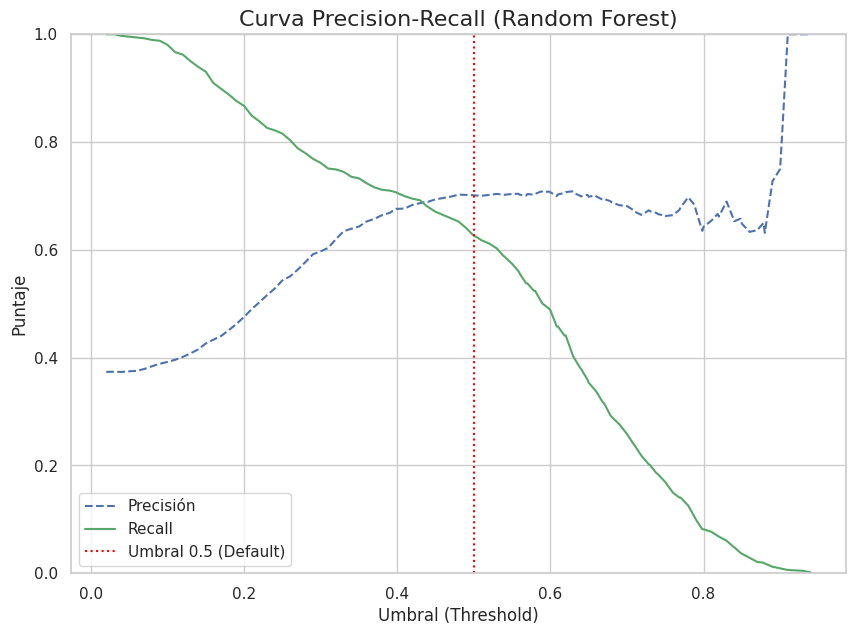


--- Búsqueda de Umbral para Recall >= 80.0% ---
Umbral sugerido: 0.0200
Con este umbral, el Recall en entrenamiento sería: ~80.0%
La Precisión en entrenamiento bajaría a: ~0.37


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# --- 1. Obtener probabilidades de predicción ---
# Usamos cross_val_predict en el set de ENTRENAMIENTO (X_train, y_train)
# Esto evita el sobreajuste al buscar el umbral.
# Queremos la probabilidad de la clase '1' (Grave)
print("--- Obteniendo probabilidades con validación cruzada (puede tardar un momento)... ---")
y_scores_rf = cross_val_predict(
    full_pipeline_rf,
    X_train,
    y_train,
    cv=5,            # 5-fold cross-validation
    method='predict_proba' # ¡Queremos las probabilidades, no la predicción final!
)

# Obtenemos solo las probabilidades de la clase positiva (Grave=1)
y_scores_rf = y_scores_rf[:, 1]

print("--- Probabilidades obtenidas. ---")

# --- 2. Calcular la Curva Precision-Recall ---
# Compara las probabilidades (scores) con los valores reales (y_train)
precisiones, recalls, umbrales = precision_recall_curve(y_train, y_scores_rf)

# --- 3. Graficar la Curva Precision-Recall ---
plt.figure(figsize=(10, 7))
plt.plot(umbrales, precisiones[:-1], "b--", label="Precisión")
plt.plot(umbrales, recalls[:-1], "g-", label="Recall")
plt.title('Curva Precision-Recall (Random Forest)', fontsize=16)
plt.xlabel('Umbral (Threshold)', fontsize=12)
plt.ylabel('Puntaje', fontsize=12)
plt.legend(loc='center left')
plt.grid(True)
plt.ylim([0, 1])
plt.axvline(x=0.5, color='red', linestyle=':', label='Umbral 0.5 (Default)')
plt.legend()
plt.savefig('curva_precision_recall.png')
plt.show()

# --- 4. Encontrar un Umbral para un Recall Específico ---
# Por ejemplo, busquemos el primer umbral que nos da al menos 80% de Recall
target_recall = 0.80
umbral_objetivo = umbrales[np.argmax(recalls >= target_recall)]
precision_en_objetivo = precisiones[np.argmax(recalls >= target_recall)]

print(f"\n--- Búsqueda de Umbral para Recall >= {target_recall*100}% ---")
print(f"Umbral sugerido: {umbral_objetivo:.4f}")
print(f"Con este umbral, el Recall en entrenamiento sería: ~{target_recall*100}%")
print(f"La Precisión en entrenamiento bajaría a: ~{precision_en_objetivo:.2f}")

--- Aplicando Umbral Personalizado de 0.3581 en el TEST SET ---

--- Reporte de Clasificación (RF c/ Umbral Ajustado) ---
              precision    recall  f1-score   support

    Leve (0)       0.81      0.79      0.80       278
   Grave (1)       0.66      0.70      0.68       166

    accuracy                           0.75       444
   macro avg       0.74      0.74      0.74       444
weighted avg       0.76      0.75      0.76       444


--- Generando Matriz de Confusión (RF c/ Umbral Ajustado)... ---


<Figure size 800x600 with 0 Axes>

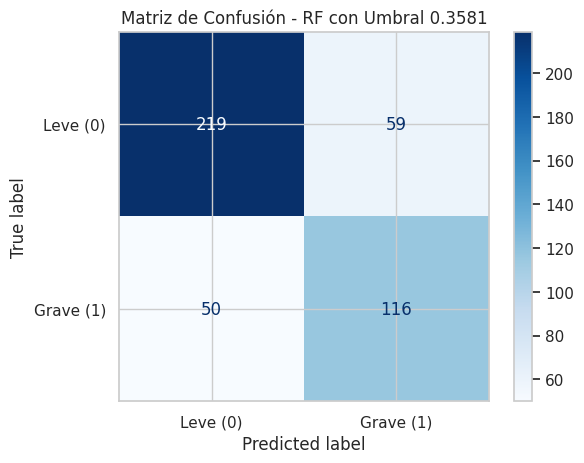

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Definir el umbral objetivo ---
# Este es el valor que encontramos en el Bloque 6
umbral_objetivo = 0.3581

print(f"--- Aplicando Umbral Personalizado de {umbral_objetivo} en el TEST SET ---")

# --- 2. Obtener probabilidades en el set de PRUEBA ---
# Usamos el pipeline de Random Forest YA ENTRENADO (full_pipeline_rf)
y_proba_rf = full_pipeline_rf.predict_proba(X_test)

# Nos quedamos solo con las probabilidades de la clase '1' (Grave)
y_scores_test = y_proba_rf[:, 1]

# --- 3. Aplicar el umbral personalizado ---
# Si la probabilidad es >= umbral_objetivo, predecir 1 (Grave), si no, 0 (Leve)
y_pred_rf_custom_threshold = (y_scores_test >= umbral_objetivo).astype(int)

# --- 4. Evaluación del Modelo (con umbral ajustado) ---
print("\n--- Reporte de Clasificación (RF c/ Umbral Ajustado) ---")
# Comparamos y_test (reales) con nuestras predicciones personalizadas
print(classification_report(y_test, y_pred_rf_custom_threshold, target_names=['Leve (0)', 'Grave (1)']))

# --- 5. Matriz de Confusión (con umbral ajustado) ---
print("\n--- Generando Matriz de Confusión (RF c/ Umbral Ajustado)... ---")
cm_rf_custom = confusion_matrix(y_test, y_pred_rf_custom_threshold)

plt.figure(figsize=(8, 6))
disp_rf_custom = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_custom,
    display_labels=['Leve (0)', 'Grave (1)']
)
disp_rf_custom.plot(cmap='Blues', values_format='d')
plt.title(f'Matriz de Confusión - RF con Umbral {umbral_objetivo:.4f}')
plt.savefig('matriz_confusion_rf_custom.png')
plt.show()

--- Top 15 Features más importantes para el Modelo ---
                                              Feature  Importance
1                                                MOTO    0.211530
0                                                  PK    0.106744
8                                                HORA    0.096815
7                                                 DIA    0.093746
6                                                 MES    0.072053
2                                             LIVIANO    0.058928
5                                                 AÑO    0.036187
4                                              CAMION    0.021820
9                             AUTOPISTA_AU 25 DE MAYO    0.016159
26                           BANDA_o_RAMAL_ASCENDENTE    0.015104
66                                DIASEMANA_Miércoles    0.014976
57  TIPO_DE_SINIESTRO_COLISION CON DOS O MAS VEHIC...    0.014962
27                          BANDA_o_RAMAL_DESCENDENTE    0.014898
12                   

/tmp/ipython-input-1941785920.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


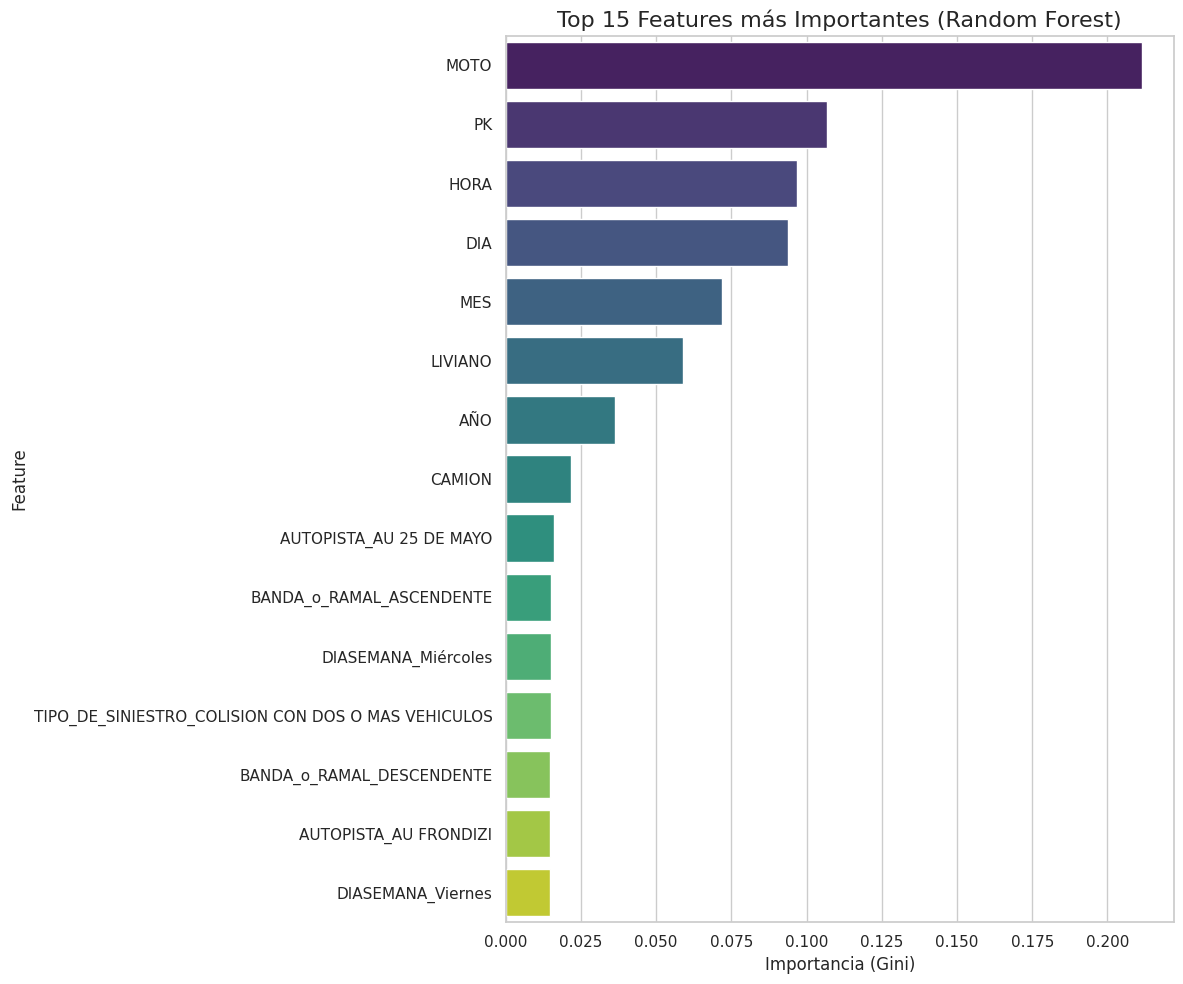

In [ ]:
# --- 1. Obtener los pasos del Pipeline ---
# (Asegúrate de que 'full_pipeline_rf' sea tu pipeline de Random Forest)
try:
    preprocessor = full_pipeline_rf.named_steps['preprocessor']
    modelo_rf = full_pipeline_rf.named_steps['classifier']
except NameError:
    print("Error: El objeto 'full_pipeline_rf' no está definido.")
    # Detener si el pipeline no existe
    raise

# --- 2. Obtener los nombres de las features procesadas ---
# El OneHotEncoder crea nombres nuevos (ej. 'DIASEMANA_Lunes')
# Necesitamos obtener esos nombres del paso 'preprocessor'

# Accedemos al transformador 'cat' (categórico) dentro del preprocessor,
# y luego al paso 'onehot' dentro de ese transformador.
try:
    feature_names_cat = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(features_categoricas)
except AttributeError:
    # Versiones más antiguas de sklearn usan 'categories_'
    # Este es un fallback por si acaso
    print("Usando fallback para get_feature_names_out()...")
    feature_names_cat = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()


# Unimos los nombres de las features numéricas (que no cambian)
# con los nuevos nombres de las features categóricas
feature_names_finales = np.concatenate([
    np.array(features_numericas),
    feature_names_cat
])


# --- 3. Obtener la importancia de las features del modelo ---
importances = modelo_rf.feature_importances_

# --- 4. Crear un DataFrame para visualizar ---
df_importances = pd.DataFrame({
    'Feature': feature_names_finales,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- 5. Mostrar las 15 features más importantes ---
print("--- Top 15 Features más importantes para el Modelo ---")
print(df_importances.head(15))

# --- 6. Graficar la importancia ---
plt.figure(figsize=(12, 10))
sns.barplot(
    data=df_importances.head(15),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('Top 15 Features más Importantes (Random Forest)', fontsize=16)
plt.xlabel('Importancia (Gini)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

#### probar con nuevos valores

In [ ]:
from sklearn.metrics import classification_report

# --- 1. Definir el umbral ---
umbral_objetivo = 0.3581 # El que encontramos en Bloque 6

# --- 2. Predicciones en set de ENTRENAMIENTO (Train) ---
# (Ya tenemos las probabilidades 'y_scores_rf' del Bloque 6)
try:
    y_pred_train_custom = (y_scores_rf >= umbral_objetivo).astype(int)
except NameError:
    print("Ejecutando predicciones de entrenamiento (Train)...")
    y_proba_train = full_pipeline_rf.predict_proba(X_train)
    y_scores_rf = y_proba_train[:, 1]
    y_pred_train_custom = (y_scores_rf >= umbral_objetivo).astype(int)

# --- 3. Predicciones en set de PRUEBA (Test) ---
# (Ya tenemos 'y_pred_rf_custom_threshold' del Bloque 7)
# y_pred_rf_custom_threshold = (y_scores_test >= umbral_objetivo).astype(int)


# --- 4. Comparar Reportes ---
print("==========================================================")
print("--- MÉTRICAS EN DATOS DE ENTRENAMIENTO (Train Set) ---")
print(classification_report(y_train, y_pred_train_custom, target_names=['Leve (0)', 'Grave (1)']))
print("==========================================================")
print("\n--- MÉTRICAS EN DATOS DE PRUEBA (Test Set) ---")
print("    (Estos son los 'datos nuevos' simulados)")
print(classification_report(y_test, y_pred_rf_custom_threshold, target_names=['Leve (0)', 'Grave (1)']))
print("==========================================================")

--- MÉTRICAS EN DATOS DE ENTRENAMIENTO (Train Set) ---
              precision    recall  f1-score   support

    Leve (0)       0.82      0.77      0.80      1110
   Grave (1)       0.65      0.72      0.69       662

    accuracy                           0.75      1772
   macro avg       0.74      0.75      0.74      1772
weighted avg       0.76      0.75      0.76      1772


--- MÉTRICAS EN DATOS DE PRUEBA (Test Set) ---
    (Estos son los 'datos nuevos' simulados)
              precision    recall  f1-score   support

    Leve (0)       0.81      0.79      0.80       278
   Grave (1)       0.66      0.70      0.68       166

    accuracy                           0.75       444
   macro avg       0.74      0.74      0.74       444
weighted avg       0.76      0.75      0.76       444



In [ ]:
import pandas as pd

# --- 1. Definir los siniestros "nuevos" ---
# (Usamos las columnas originales de 'X')
data_nueva = [
    {
        # --- Escenario 1: ALTO RIESGO ---
        'MOTO': 1,              # <-- Feature más importante
        'LIVIANO': 1,
        'PK': 9200.0,           # <-- PK alto (basado en el análisis de features)
        'HORA': 8,              # <-- Hora pico
        'DIASEMANA': 'Viernes',   # <-- Día de alto tránsito
        'AUTOPISTA': 'AU 25 DE MAYO', # <-- Feature importante
        'TIPO_DE_SINIESTRO': 'COLISION CON DOS O MAS VEHICULOS',
        'BANDA_o_RAMAL': 'ASCENDENTE',
        'CONDICIONES_METEOROLOGICAS': 'BUENO',
        'SUPERFICIE_DE_LA_VIA': 'SECA',
        'BUS': 0, 'CAMION': 0, 'AÑO': 2024, 'MES': 10, 'DIA': 28
    },
    {
        # --- Escenario 2: BAJO RIESGO ---
        'MOTO': 0,              # <-- Sin moto
        'LIVIANO': 2,
        'PK': 1500.0,
        'HORA': 14,             # <-- Hora valle
        'DIASEMANA': 'Miércoles',
        'AUTOPISTA': 'AU PERITO MORENO',
        'TIPO_DE_SINIESTRO': 'COLISION CON DOS O MAS VEHICULOS',
        'BANDA_o_RAMAL': 'DESCENDENTE',
        'CONDICIONES_METEOROLOGICAS': 'BUENO',
        'SUPERFICIE_DE_LA_VIA': 'SECA',
        'BUS': 0, 'CAMION': 0, 'AÑO': 2024, 'MES': 10, 'DIA': 30
    }
]

# --- 2. Crear DataFrame con las columnas en el orden correcto ---
# (El pipeline es sensible al orden de las columnas)
df_nuevos_siniestros = pd.DataFrame(data_nueva, columns=features_finales)

print("--- Datos Nuevos a Predecir: ---")
print(df_nuevos_siniestros[['MOTO', 'PK', 'HORA', 'AUTOPISTA']])


# --- 3. Predecir con el modelo final ---
# (full_pipeline_rf y umbral_objetivo deben estar definidos)

# a. Obtener probabilidades
probabilidades_nuevas = full_pipeline_rf.predict_proba(df_nuevos_siniestros)
prob_grave_nuevas = probabilidades_nuevas[:, 1] # Probabilidad de ser Grave (1)

# b. Aplicar umbral
predicciones_nuevas = (prob_grave_nuevas >= umbral_objetivo).astype(int)


# --- 4. Mostrar Resultados ---
print("\n--- Resultados de la Predicción ---")
for i, (prob, pred) in enumerate(zip(prob_grave_nuevas, predicciones_nuevas)):
    resultado = "GRAVE" if pred == 1 else "LEVE"
    print(f"\nSiniestro #{i+1}:")
    print(f"  -> Probabilidad de ser Grave: {prob:.2f} ({prob*100:.0f}%)")
    print(f"  -> Predicción (con umbral {umbral_objetivo:.4f}): {resultado} ({pred})")

--- Datos Nuevos a Predecir: ---
   MOTO      PK  HORA         AUTOPISTA
0     1  9200.0     8     AU 25 DE MAYO
1     0  1500.0    14  AU PERITO MORENO

--- Resultados de la Predicción ---

Siniestro #1:
  -> Probabilidad de ser Grave: 0.78 (78%)
  -> Predicción (con umbral 0.3581): GRAVE (1)

Siniestro #2:
  -> Probabilidad de ser Grave: 0.09 (9%)
  -> Predicción (con umbral 0.3581): LEVE (0)


### Prediccion de accidentes a futuro


--- Nuevo DataFrame Diario (más rico) ---
            N_SINIESTROS  N_MOTOS  N_GRAVES  HUBO_LLUVIA
2022-08-01             1      0.0       0.0          0.0
2022-08-02             1      0.0       0.0          0.0
2022-08-03             2      1.0       1.0          0.0
2022-08-04             6      3.0       3.0          0.0
2022-08-05             1      0.0       1.0          0.0

--- Últimas filas del DataFrame de Serie Temporal Diaria ---
            N_SINIESTROS  N_MOTOS  N_GRAVES  HUBO_LLUVIA
2024-12-27             4      2.0       2.0          0.0
2024-12-28             0      0.0       0.0          0.0
2024-12-29             1      1.0       1.0          0.0
2024-12-30             2      1.0       1.0          0.0
2024-12-31             2      2.0       2.0          0.0

Datos desde 2022-08-01 00:00:00 hasta 2024-12-31 00:00:00


<Figure size 1800x600 with 0 Axes>

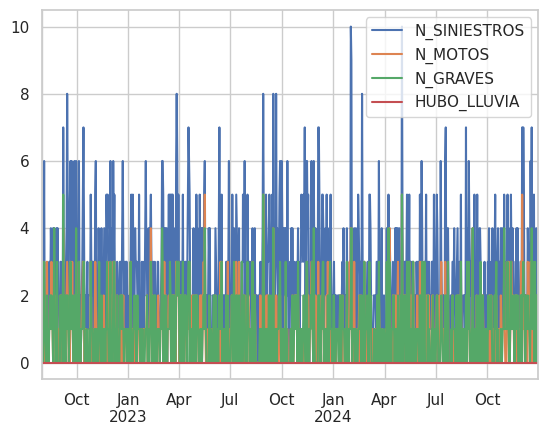

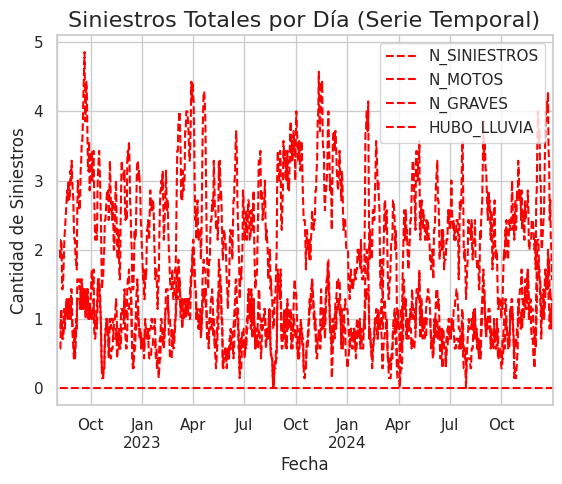

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Asegurar que 'FECHA_COMPLETA' es datetime ---
# (Esto puede venir del script original, pero lo aseguramos)
try:
    df_ausa['FECHA_COMPLETA'] = pd.to_datetime(df_ausa['FECHA_COMPLETA'], errors='coerce')
except KeyError:
    # Si 'FECHA_COMPLETA' no existe, la creamos
    df_ausa['AÑO'] = df_ausa['AÑO'].astype(int)
    df_ausa['MES'] = df_ausa['MES'].astype(int)
    df_ausa['DIA'] = df_ausa['DIA'].astype(int)
    df_ausa['FECHA_COMPLETA'] = pd.to_datetime(
        df_ausa[['AÑO', 'MES', 'DIA']].rename(columns={'AÑO': 'year', 'MES': 'month', 'DIA': 'day'}),
        errors='coerce'
    )
df_ausa.dropna(subset=['FECHA_COMPLETA'], inplace=True)


# --- 2. Crear la Serie Temporal Diaria ---
# Contamos el número de siniestros por día
# Usamos .size() que cuenta filas.
# --- Propuesta de MEJORA para el Bloque 11 ---

# 1. Asegurarnos que 'FECHA_COMPLETA' es el índice de df_ausa
df_ausa['FECHA_COMPLETA'] = pd.to_datetime(df_ausa['FECHA_COMPLETA'])
df_ausa = df_ausa.set_index('FECHA_COMPLETA')

# 2. Crear una base diaria (para mantener los días con 0 siniestros)
df_diario = pd.DataFrame(index=pd.date_range(
    start=df_ausa.index.min(),
    end=df_ausa.index.max(),
    freq='D'
))

# 3. Agregar los datos por día
# Contar el total de siniestros (como antes)
df_diario['N_SINIESTROS'] = df_ausa.resample('D').size().fillna(0)

# (¡AQUÍ LA MAGIA!)
# Contar cuántas MOTOS hubo ese día
df_diario['N_MOTOS'] = df_ausa[df_ausa['MOTO'] > 0].resample('D').size().fillna(0)

# Contar cuántos siniestros GRAVES hubo ese día
df_diario['N_GRAVES'] = df_ausa[df_ausa['GRAVEDAD'] == 1].resample('D').size().fillna(0)

# ¿Llovió ese día? (Creamos una feature binaria)
# (Esto asume que 'LLUVIA' está en 'CONDICIONES_METEOROLOGICAS')
df_diario['HUBO_LLUVIA'] = df_ausa[
    df_ausa['CONDICIONES_METEOROLOGICAS'].str.contains('LLUVIA', na=False)
].resample('D').size().apply(lambda x: 1 if x > 0 else 0)

# Rellenar cualquier NaN que quede en las nuevas features
df_diario = df_diario.fillna(0)

print("--- Nuevo DataFrame Diario (más rico) ---")
print(df_diario.head())
print("\n--- Últimas filas del DataFrame de Serie Temporal Diaria ---")
print(df_diario.tail())
print(f"\nDatos desde {df_diario.index.min()} hasta {df_diario.index.max()}")


# --- 5. Visualizar la Serie Temporal ---
plt.figure(figsize=(18, 6))
df_diario.plot(label='Siniestros por Día')
# Añadimos una media móvil para ver la tendencia (ej. 7 días)
df_diario.rolling(window=7).mean().plot(color='red', linestyle='--', label='Media Móvil (7 días)')
plt.title('Siniestros Totales por Día (Serie Temporal)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de Siniestros', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('serie_temporal_diaria.png')
plt.show()

In [ ]:
import pandas as pd

# (Asumiendo que 'df_diario' existe del bloque anterior)
# Convertimos el objeto Series a DataFrame para añadir columnas
df_ts = df_diario # Remove .to_frame() as df_diario is already a DataFrame

# --- 1. Crear Features de Lags (Desplazamientos) ---
# Usamos .shift(n) para tomar el valor de hace 'n' días.
# El lag 1 es el valor de "ayer".
# El lag 7 es el valor del "mismo día de la semana pasada".

df_ts['lag_1'] = df_ts['N_SINIESTROS'].shift(1)
df_ts['lag_7'] = df_ts['N_SINIESTROS'].shift(7)
df_ts['lag_14'] = df_ts['N_SINIESTROS'].shift(14)


# --- 2. Crear Features de Ventana Móvil (Rolling Window) ---
# Media móvil de los últimos 7 días (sin incluir el día actual)
# Usamos .shift(1) ANTES del .rolling() para evitar usar
# la información del día actual (fuga de datos).
df_ts['rolling_mean_7'] = df_ts['N_SINIESTROS'].shift(1).rolling(window=7).mean()
df_ts['rolling_mean_14'] = df_ts['N_SINIESTROS'].shift(1).rolling(window=14).mean()


# --- 3. Crear Features Basadas en la Fecha ---
# El día de la semana es probablemente la feature más importante aquí.
df_ts['dia_de_semana'] = df_ts.index.dayofweek  # Lunes=0, Domingo=6
df_ts['mes'] = df_ts.index.month
df_ts['dia_del_año'] = df_ts.index.dayofyear


# --- 4. Limpiar NaNs ---
# Los lags y rolling means crean valores NaN (nulos) al principio
# de los datos (ej. los primeros 14 días no tienen 'lag_14').
# Debemos eliminarlos para poder entrenar.
print(f"Filas antes de limpiar NaNs: {len(df_ts)}")
df_ts_clean = df_ts.dropna()
print(f"Filas después de limpiar NaNs: {len(df_ts_clean)}")


# --- 5. Inspeccionar el DataFrame final ---
print("\n--- DataFrame con Features para Time Series ---")
# Mostramos cómo 'N_SINIESTROS' (y) se alinea con las features (X)
print(df_ts_clean[['N_SINIESTROS', 'lag_1', 'lag_7', 'rolling_mean_7', 'dia_de_semana']].head())

Filas antes de limpiar NaNs: 884
Filas después de limpiar NaNs: 870

--- DataFrame con Features para Time Series ---
            N_SINIESTROS  lag_1  lag_7  rolling_mean_7  dia_de_semana
2022-08-15             2    3.0    0.0        1.857143              0
2022-08-16             4    2.0    3.0        2.142857              1
2022-08-17             3    4.0    2.0        2.285714              2
2022-08-18             2    3.0    1.0        2.428571              3
2022-08-19             2    2.0    1.0        2.571429              4


--- División de Series Temporales (Cronológica) ---
Total de datos: 870
Datos de Entrenamiento (Train): 696 (desde 2022-08-15 00:00:00 hasta 2024-07-10 00:00:00)
Datos de Prueba (Test): 174 (desde 2024-07-11 00:00:00 hasta 2024-12-31 00:00:00)


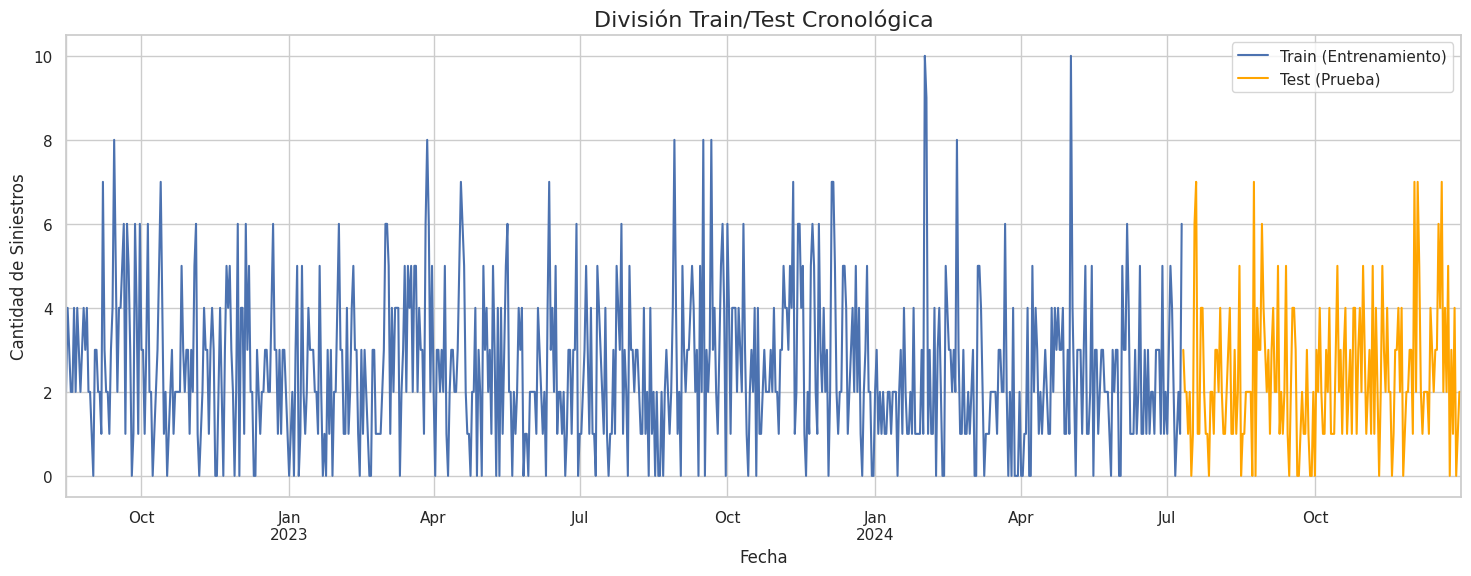

In [ ]:
import numpy as np

# --- 1. Definir X e y ---
# (Asumiendo que 'df_ts_clean' existe del bloque anterior)
target = 'N_SINIESTROS'
features = [col for col in df_ts_clean.columns if col != target]

X = df_ts_clean[features]
y = df_ts_clean[target]

# --- 2. Calcular el punto de corte (split) ---
# Usamos el 80% para entrenar (train) y el 20% para probar (test)
split_percentage = 0.8
split_point = int(len(X) * split_percentage)

# --- 3. Realizar la división cronológica ---
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# --- 4. Verificar la división ---
print("--- División de Series Temporales (Cronológica) ---")
print(f"Total de datos: {len(X)}")
print(f"Datos de Entrenamiento (Train): {len(X_train)} (desde {X_train.index.min()} hasta {X_train.index.max()})")
print(f"Datos de Prueba (Test): {len(X_test)} (desde {X_test.index.min()} hasta {X_test.index.max()})")

# --- 5. Visualizar la división ---
plt.figure(figsize=(18, 6))
y_train.plot(label='Train (Entrenamiento)')
y_test.plot(label='Test (Prueba)', color='orange')
plt.title('División Train/Test Cronológica', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Siniestros')
plt.legend()
plt.grid(True)
plt.savefig('train_test_split_temporal.png')
plt.show()

--- División de Series Temporales (Cronológica) ---
Total de datos: 870
Datos de Entrenamiento (Train): 696 (desde 2022-08-15 00:00:00 hasta 2024-07-10 00:00:00)
Datos de Prueba (Test): 174 (desde 2024-07-11 00:00:00 hasta 2024-12-31 00:00:00)


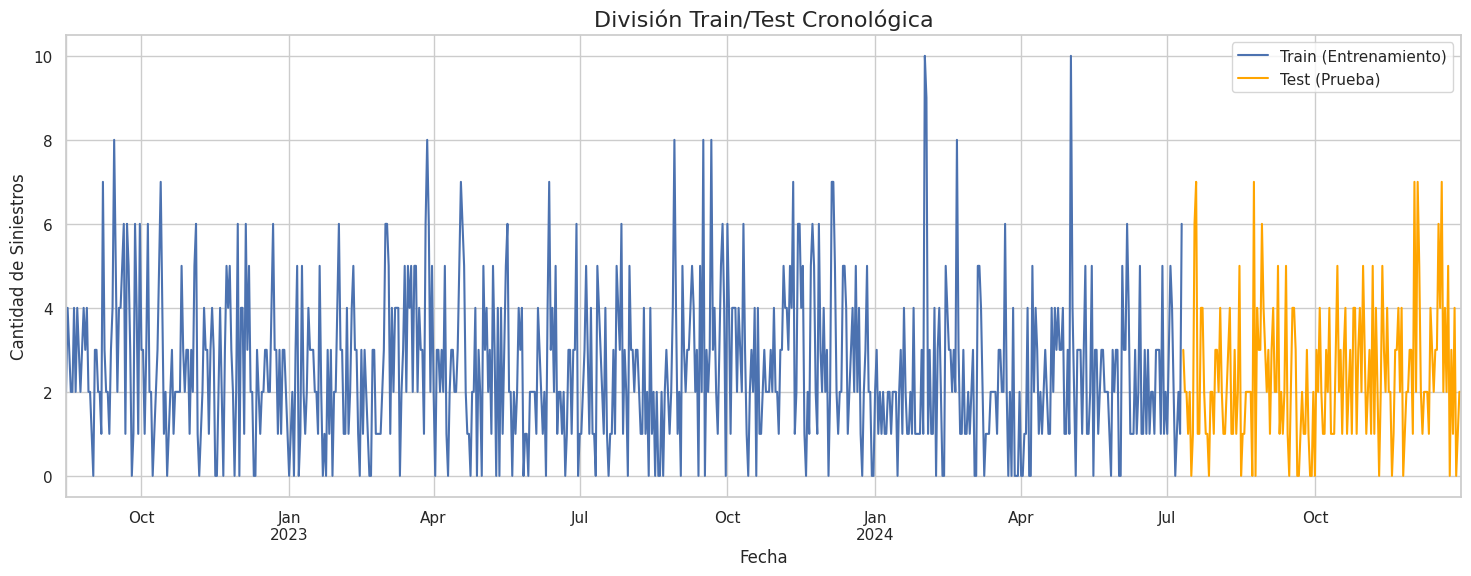

In [ ]:
import numpy as np

# --- 1. Definir X e y ---
# (Asumiendo que 'df_ts_clean' existe del bloque anterior)
target = 'N_SINIESTROS'
features = [col for col in df_ts_clean.columns if col != target]

X = df_ts_clean[features]
y = df_ts_clean[target]

# --- 2. Calcular el punto de corte (split) ---
# Usamos el 80% para entrenar (train) y el 20% para probar (test)
split_percentage = 0.8
split_point = int(len(X) * split_percentage)

# --- 3. Realizar la división cronológica ---
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# --- 4. Verificar la división ---
print("--- División de Series Temporales (Cronológica) ---")
print(f"Total de datos: {len(X)}")
print(f"Datos de Entrenamiento (Train): {len(X_train)} (desde {X_train.index.min()} hasta {X_train.index.max()})")
print(f"Datos de Prueba (Test): {len(X_test)} (desde {X_test.index.min()} hasta {X_test.index.max()})")

# --- 5. Visualizar la división ---
plt.figure(figsize=(18, 6))
y_train.plot(label='Train (Entrenamiento)')
y_test.plot(label='Test (Prueba)', color='orange')
plt.title('División Train/Test Cronológica', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Siniestros')
plt.legend()
plt.grid(True)
plt.savefig('train_test_split_temporal.png')
plt.show()

--- Entrenando el Modelo de Time Series (XGBoost)... ---
--- ¡Entrenamiento Completo! ---

--- Métricas de Evaluación (en el Test Set) ---
Error Absoluto Medio (MAE): 1.026
Raíz del Error Cuadrático Medio (RMSE): 1.241
Promedio de Siniestros Reales (Test): 2.385


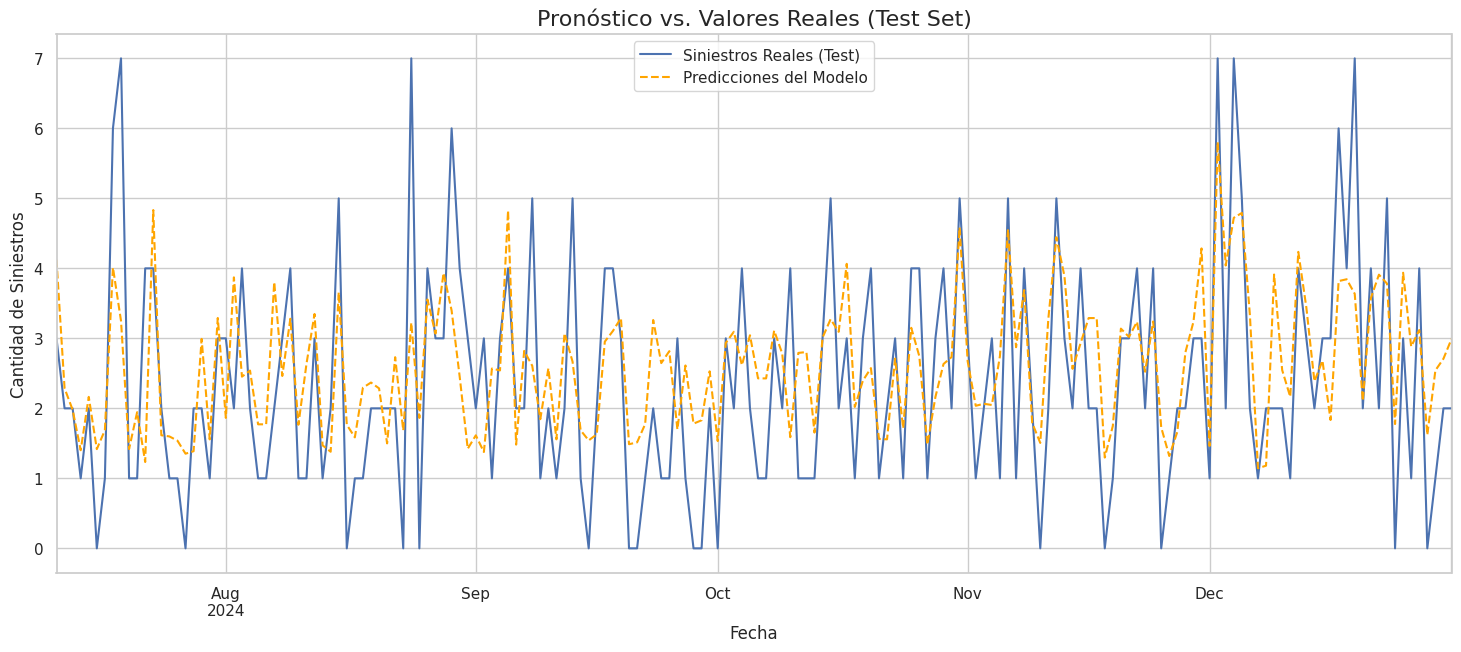

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- 1. Crear y Entrenar el Modelo ---
# (Asumiendo que X_train, y_train existen del bloque anterior)

# Usamos 'objective':'reg:squarederror' para regresión
modelo_ts = xgb.XGBRegressor(
    n_estimators=1000,       # 1000 "árboles"
    early_stopping_rounds=50, # Parará si no mejora en 50 rondas
    learning_rate=0.01,
    random_state=42,
    objective='reg:squarederror'
)

print("--- Entrenando el Modelo de Time Series (XGBoost)... ---")

# Usamos el set de TEST como set de evaluación para el 'early_stopping'
# Esto es una práctica común en series temporales
modelo_ts.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Poner True si quieres ver el proceso de entrenamiento
)

print("--- ¡Entrenamiento Completo! ---")

# --- 2. Realizar Predicciones ---
# Predecimos sobre el set de prueba (el "futuro")
y_pred_ts = modelo_ts.predict(X_test)

# --- 3. Evaluar las Métricas ---
mae = mean_absolute_error(y_test, y_pred_ts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ts))

print("\n--- Métricas de Evaluación (en el Test Set) ---")
print(f"Error Absoluto Medio (MAE): {mae:.3f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.3f}")
print(f"Promedio de Siniestros Reales (Test): {y_test.mean():.3f}")

# --- 4. Visualizar Predicciones vs. Reales ---
# Creamos un DataFrame para graficar fácilmente
df_resultados = pd.DataFrame({
    'Reales': y_test,
    'Predichos': y_pred_ts
})

plt.figure(figsize=(18, 7))
df_resultados['Reales'].plot(label='Siniestros Reales (Test)')
df_resultados['Predichos'].plot(
    label='Predicciones del Modelo',
    color='orange',
    linestyle='--'
)
plt.title('Pronóstico vs. Valores Reales (Test Set)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Siniestros')
plt.legend()
plt.grid(True)
plt.savefig('prediccion_vs_real.png')
plt.show()

In [ ]:
import pandas as pd

# --- 1. Reutilizar las variables del Bloque 14 ---
# (Este código asume que has ejecutado el Bloque 14 y que
# las variables 'y_pred_ts' y 'y_test' ya existen en memoria)

try:
    # --- 2. Crear el DataFrame de Pronósticos ---
    # Usamos el índice de 'y_test' (que contiene las fechas)
    # y los datos de 'y_pred_ts' (las predicciones)

    df_pronostico = pd.DataFrame(
        y_pred_ts,
        index=y_test.index,
        columns=['Cantidad_Predicha']
    )

    # Renombramos el índice para mayor claridad
    df_pronostico.index.name = 'Fecha'

    # --- 3. Ajustar y Mostrar los Resultados ---

    # Las predicciones de regresión pueden dar decimales (ej. 3.7 siniestros).
    # Las redondeamos al entero más cercano.
    df_pronostico['Cantidad_Predicha'] = df_pronostico['Cantidad_Predicha'].round(0).astype(int)

    # Imprimimos los primeros 15 días del pronóstico (el inicio del Test Set)
    print("--- Pronóstico de Siniestros (Inicia el 2025-01-21) ---")
    print(df_pronostico.head(15))


    # --- Opcional: Comparar con los Reales ---
    # (Esto recrea el 'df_resultados' del Bloque 14)

    print("\n--- Comparativa (Predichos vs. Reales) ---")

    # Añadimos la columna de los valores reales ('y_test') para comparar
    df_pronostico_comparativo = df_pronostico.copy()
    df_pronostico_comparativo['Cantidad_Real'] = y_test

    # Reordenamos columnas
    df_pronostico_comparativo = df_pronostico_comparativo[['Cantidad_Real', 'Cantidad_Predicha']]

    print(df_pronostico_comparativo.head(15))


except NameError:
    print("¡Error!")
    print("Asegúrate de haber ejecutado los bloques 11, 12, 13 y 14.")
    print("Las variables 'y_pred_ts' y 'y_test' no fueron encontradas.")

--- Pronóstico de Siniestros (Inicia el 2025-01-21) ---
            Cantidad_Predicha
Fecha                        
2024-07-11                  4
2024-07-12                  2
2024-07-13                  2
2024-07-14                  1
2024-07-15                  2
2024-07-16                  1
2024-07-17                  2
2024-07-18                  4
2024-07-19                  3
2024-07-20                  1
2024-07-21                  2
2024-07-22                  1
2024-07-23                  5
2024-07-24                  2
2024-07-25                  2

--- Comparativa (Predichos vs. Reales) ---
            Cantidad_Real  Cantidad_Predicha
Fecha                                       
2024-07-11              3                  4
2024-07-12              2                  2
2024-07-13              2                  2
2024-07-14              1                  1
2024-07-15              2                  2
2024-07-16              0                  1
2024-07-17              1     

## Acomodado para looker

---


In [ ]:
import pandas as pd

# (Asumiendo que 'df_ausa' es tu DataFrame limpio y listo)
try:
    # Seleccionamos las columnas más útiles para un dashboard
    # (Excluimos las columnas temporales que creamos para ML)
    columnas_para_looker = [
        'AUTOPISTA', 'BANDA_o_RAMAL', 'PK', 'CONDICIONES_METEOROLOGICAS',
        'SUPERFICIE_DE_LA_VIA', 'TIPO_DE_SINIESTRO', 'DIASEMANA', 'HORA',
        'DIA', 'MES', 'AÑO', 'MOTO', 'LIVIANO', 'BUS', 'CAMION',
        'LESIONADOS', 'FALLECIDOS', 'GRAVEDAD', 'FECHA_COMPLETA'
    ]

    # Asegurarnos de que todas las columnas existan
    columnas_existentes = [col for col in columnas_para_looker if col in df_ausa.columns]

    df_para_looker = df_ausa[columnas_existentes].copy()

    # Guardar en CSV
    df_para_looker.to_csv('datos_para_dashboard_eda.csv', index=False, sep=';', encoding='utf-8-sig')

    print("¡Archivo 'datos_para_dashboard_eda.csv' guardado con éxito!")
    print(f"Contiene {len(df_para_looker)} filas y {len(columnas_existentes)} columnas.")

except NameError:
    print("Error: El DataFrame 'df_ausa' no está definido.")
except Exception as e:
    print(f"Un error ocurrió: {e}")

¡Archivo 'datos_para_dashboard_eda.csv' guardado con éxito!
Contiene 2216 filas y 18 columnas.


In [ ]:
import joblib

# (Asegúrate de haber corrido todo el código de entrenamiento anterior
# para que 'full_pipeline_rf' y 'modelo_ts' existan)

print("--- Guardando modelos entrenados... ---")

# --- 1. Guardar el Pipeline de Clasificación ---
try:
    joblib.dump(full_pipeline_rf, 'modelo_clasificador_rf.joblib')
    print("Modelo 'modelo_clasificador_rf.joblib' guardado.")
except NameError:
    print("Error: El pipeline 'full_pipeline_rf' no está definido.")

# --- 2. Guardar el Modelo de Pronóstico ---
try:
    joblib.dump(modelo_ts, 'modelo_pronostico_ts.joblib')
    print("Modelo 'modelo_pronostico_ts.joblib' guardado.")
except NameError:
    print("Error: El modelo 'modelo_ts' no está definido.")

# --- 3. Guardar la lista de features del Clasificador ---
try:
    joblib.dump(features_finales, 'features_clasificador.joblib')
    print("Lista 'features_clasificador.joblib' guardada.")
except NameError:
    print("Error: La lista 'features_finales' no está definida.")

print("--- ¡Archivos listos! ---")

--- Guardando modelos entrenados... ---
Modelo 'modelo_clasificador_rf.joblib' guardado.
Modelo 'modelo_pronostico_ts.joblib' guardado.
Lista 'features_clasificador.joblib' guardada.
--- ¡Archivos listos! ---


In [ ]:
import pandas as pd
import numpy as np
import joblib

# --- Parte 1: CSV para el Dashboard de EDA ---
print("--- Generando CSV para EDA (Looker) ---")
try:
    columnas_para_looker = [
        'AUTOPISTA', 'BANDA_o_RAMAL', 'PK', 'CONDICIONES_METEOROLOGICAS',
        'SUPERFICIE_DE_LA_VIA', 'TIPO_DE_SINIESTRO', 'DIASEMANA', 'HORA',
        'DIA', 'MES', 'AÑO', 'MOTO', 'LIVIANO', 'BUS', 'CAMION',
        'LESIONADOS', 'FALLECIDOS', 'GRAVEDAD', 'FECHA_COMPLETA'
    ]
    columnas_existentes = [col for col in columnas_para_looker if col in df_ausa.columns]
    df_para_looker = df_ausa[columnas_existentes].copy()

    df_para_looker.to_csv('datos_para_dashboard_eda.csv', index=False, sep=',', encoding='utf-8-sig')

    print("¡Archivo 'datos_para_dashboard_eda.csv' guardado con éxito!")
except NameError:
    print("Error: El DataFrame 'df_ausa' no está definido.")
except Exception as e:
    print(f"Un error ocurrió: {e}")



--- Generando CSV para EDA (Looker) ---
¡Archivo 'datos_para_dashboard_eda.csv' guardado con éxito!


## app visual


In [ ]:
import joblib

# --- 1. Guardar el Pipeline de Clasificación ---
# (Asumiendo que 'full_pipeline_rf' es tu pipeline de RF entrenado)
try:
    joblib.dump(full_pipeline_rf, 'modelo_clasificador_rf.joblib')
    print("Modelo 'modelo_clasificador_rf.joblib' guardado.")
except NameError:
    print("Error: El pipeline 'full_pipeline_rf' no está definido. Asegúrate de haber corrido el Bloque 4.")

# --- 2. Guardar el Modelo de Pronóstico ---
# (Asumiendo que 'modelo_ts' es tu modelo XGBoost de TS entrenado)
try:
    joblib.dump(modelo_ts, 'modelo_pronostico_ts.joblib')
    print("Modelo 'modelo_pronostico_ts.joblib' guardado.")
except NameError:
    print("Error: El modelo 'modelo_ts' no está definido. Asegúrate de haber corrido el Bloque 14.")

# --- 3. Guardar la lista de features del Clasificador ---
# (Asumiendo que 'features_finales' es la lista de columnas de X del Modelo 1)
try:
    joblib.dump(features_finales, 'features_clasificador.joblib')
    print("Lista 'features_clasificador.joblib' guardada.")
except NameError:
    print("Error: La lista 'features_finales' no está definida. Asegúrate de haber corrido el Bloque 2.")

# --- 4. Guardar las listas para los Dropdowns ---
# (Asumiendo que 'df_ausa' existe)
try:
    autopistas = df_ausa['AUTOPISTA'].unique().tolist()
    tipos_siniestro = df_ausa['TIPO_DE_SINIESTRO'].unique().tolist()
    diasemana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

    joblib.dump(autopistas, 'lista_autopistas.joblib')
    joblib.dump(tipos_siniestro, 'lista_tipos_siniestro.joblib')
    joblib.dump(diasemana, 'lista_diasemana.joblib')
    print("Listas para dropdowns guardadas.")
except Exception as e:
    print(f"Error al guardar listas de dropdowns: {e}. Asegúrate de que 'df_ausa' exista.")

Modelo 'modelo_clasificador_rf.joblib' guardado.
Modelo 'modelo_pronostico_ts.joblib' guardado.
Lista 'features_clasificador.joblib' guardada.
Listas para dropdowns guardadas.


In [ ]:
# --- 1. Instalar Gradio ---
!pip install gradio -q

import gradio as gr
import joblib
import pandas as pd
import numpy as np

# --- 2. Cargar los Artefactos ---
try:
    classifier_pipeline = joblib.load('modelo_clasificador_rf.joblib')
    features_clasificador = joblib.load('features_clasificador.joblib')

    # Listas para los menús desplegables
    autopistas_list = joblib.load('lista_autopistas.joblib')
    tipos_siniestro_list = joblib.load('lista_tipos_siniestro.joblib')
    diasemana_list = joblib.load('lista_diasemana.joblib')

    # El umbral que encontramos
    UMBRAL_OBJETIVO = 0.3581
    print("Modelos y listas cargados exitosamente.")
except FileNotFoundError:
    print("Error: No se encontraron los archivos .joblib. Asegúrate de correr el Bloque 15 primero.")
    # Detener la ejecución si no se pueden cargar los modelos
    raise

# --- 3. Definir la Función de Predicción (Clasificador) ---
# Esta función es el "cerebro" de la pestaña 1.
def predecir_gravedad(autopista, tipo_siniestro, diasemana, hora, pk, moto, liviano, camion, bus):

    # 1. Crear un diccionario con los datos
    # Usamos valores por defecto para las features que no pedimos
    data = {
        'AUTOPISTA': autopista,
        'TIPO_DE_SINIESTRO': tipo_siniestro,
        'DIASEMANA': diasemana,
        'HORA': int(hora),
        'PK': float(pk),
        'MOTO': int(moto),
        'LIVIANO': int(liviano),
        'CAMION': int(camion),
        'BUS': int(bus),
        # --- Valores por defecto (el modelo los necesita) ---
        'BANDA_o_RAMAL': 'ASCENDENTE', # Valor frecuente
        'CONDICIONES_METEOROLOGICAS': 'BUENO', # Valor frecuente
        'SUPERFICIE_DE_LA_VIA': 'SECA', # Valor frecuente
        'AÑO': 2024, # Año actual
        'MES': 10, # Mes actual
        'DIA': 29, # Día actual
    }

    # 2. Convertir a DataFrame (asegurando el orden de columnas)
    input_df = pd.DataFrame([data], columns=features_clasificador)

    # 3. Predecir probabilidad
    prob_grave = classifier_pipeline.predict_proba(input_df)[0, 1]

    # 4. Aplicar umbral y dar veredicto
    if prob_grave >= UMBRAL_OBJETIVO:
        veredicto = "🚨 RIESGO ALTO: GRAVE 🚨"
    else:
        veredicto = "✅ RIESGO BAJO: LEVE ✅"

    prob_str = f"Probabilidad de ser GRAVE: {prob_grave * 100:.1f} %"

    return prob_str, veredicto

# --- 4. Definir la Función de Mostrar Pronóstico ---
# Esta función simplemente muestra la imagen que ya generamos
def mostrar_pronostico():
    # El nombre del archivo que guardamos en el Bloque 14
    ruta_imagen = 'prediccion_vs_real.png'
    return ruta_imagen

# --- 5. Crear la Interfaz (Pestaña 1: Clasificador) ---
with gr.Blocks() as app_clasificador:
    gr.Markdown("# 🚀 Modelo 1: Clasificador de Gravedad de Siniestros")
    gr.Markdown("Ingrese los datos del siniestro para predecir su gravedad.")

    with gr.Row():
        with gr.Column():
            autopista = gr.Dropdown(choices=autopistas_list, label="Autopista")
            tipo_siniestro = gr.Dropdown(choices=tipos_siniestro_list, label="Tipo de Siniestro")
            diasemana = gr.Dropdown(choices=diasemana_list, label="Día de la Semana")
            hora = gr.Slider(0, 23, step=1, label="Hora (0-23)")
            pk = gr.Number(label="Punto Kilométrico (PK)")

        with gr.Column():
            moto = gr.Slider(0, 5, step=1, label="# Motos Involucradas")
            liviano = gr.Slider(0, 5, step=1, label="# Livianos Involucrados")
            camion = gr.Slider(0, 5, step=1, label="# Camiones Involucrados")
            bus = gr.Slider(0, 5, step=1, label="# Buses Involucrados")

    submit_btn = gr.Button("Predecir Gravedad")

    gr.Markdown("---")
    prob_output = gr.Label(label="Probabilidad")
    veredicto_output = gr.Label(label="Veredicto del Modelo")

    submit_btn.click(
        fn=predecir_gravedad,
        inputs=[autopista, tipo_siniestro, diasemana, hora, pk, moto, liviano, camion, bus],
        outputs=[prob_output, veredicto_output]
    )

# --- 6. Crear la Interfaz (Pestaña 2: Pronóstico) ---
with gr.Blocks() as app_pronostico:
    gr.Markdown("# 📈 Modelo 2: Pronóstico de Siniestralidad Diaria")
    gr.Markdown("Visualización del pronóstico del modelo vs. los siniestros reales (sobre el set de prueba).")

    # Cargar la imagen
    img = gr.Image('prediccion_vs_real.png', label="Pronóstico vs. Reales")

    # (Opcional) Botón para recargar la imagen
    # refresh_btn = gr.Button("Recargar Gráfico")
    # refresh_btn.click(fn=mostrar_pronostico, inputs=None, outputs=img)

# --- 7. Combinar y Lanzar la Aplicación ---
app = gr.TabbedInterface(
    [app_clasificador, app_pronostico],
    ["Clasificador de Gravedad", "Pronóstico de Siniestros"]
)

print("Lanzando la aplicación... (Busca el link .gradio.live más abajo)")
# debug=True es útil si algo falla
app.launch(debug=True)

Modelos y listas cargados exitosamente.
Lanzando la aplicación... (Busca el link .gradio.live más abajo)
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9bb4efc0b7d2b1f41e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9bb4efc0b7d2b1f41e.gradio.live
